In [1]:
import warnings

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import matplotlib.colors as mcolors
#import matplotlib.colors

import math as math

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.ticker as mticker
import pandas as pd
from matplotlib import gridspec

import numpy.ma as ma

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Read in the model data files

In [2]:
datadir='/shared/CAREER_PWC/DeepMIP-EOT/um_grid/'
ldir=['ocean','surface']
mdir=['baatsen','huber','hutchinson','kennedy','ladant','sijp','zhang']

Compile sea surface temperature files into an array

In [3]:
#sea surface temperature
filename=[]
for i in range(len(mdir)):
    m=datadir+ldir[0]+'/'+mdir[i]+'/'+'*'
    files=!ls {m}
    for j in range(len(files)):
        if i==0 and j==0:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            SST=ds.temp
            SST.expand_dims(dim='exp')
            filename.append(files[j])
        elif i==2:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==2 and j==0:
                continue
            SST=xr.concat([SST,ds.sst], dim='exp')
            filename.append(files[j])
        elif i==3:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==3 and j==4 or j==5 or j==7:
                continue
            SST=xr.concat([SST, ds.temp_ym_dpth], 'exp')
            filename.append(files[j])
        elif i==4:
            ds=xr.open_dataset(files[j],engine="netcdf4",decode_times=False)
            if i==4 and j==0 or j==2 or j==3:
                continue
            SST=xr.concat([SST, ds.TEMP], 'exp')
            filename.append(files[j])
        elif i==5:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['sst']=ds['sst']-273.15 #sijp data is in kelvin
            SST=xr.concat([SST, ds.sst], 'exp')
            filename.append(files[j])
        elif i==6:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==6 and j==0:
                continue
            SST=xr.concat([SST, ds.templvl], 'exp')
            filename.append(files[j])
        else:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==1 and j==2 or j==4:
                continue
            if ds.temp.dims[0]=='lat' and ds.temp.dims[1]=='lon':
                ds2=ds.rename_dims({'lat':'latitude','lon':'longitude'})
                SST=xr.concat([SST, ds2.temp], dim='exp')
                filename.append(files[j])
            else:
                SST=xr.concat([SST, ds.temp], dim='exp')
                filename.append(files[j])

Compile surface air temperature files into an array

In [4]:
#Surface Air temperature
filename_SAT=[]
for i in range(len(mdir)):
    m=datadir+ldir[1]+'/'+mdir[i]+'/'+'*'
    files=!ls {m}
    for j in range(len(files)):
        if i==0 and j==0:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if ds.temp.dims[0]!='latitude' and ds.temp.dims[1]!='longitude':
                    ds.temp.rename_dims({'lat':'latitude','lon':'longitude'})
            SAT=ds.temp
            filename_SAT.append(files[j])
        elif i==2:        
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==2 and j==0:
                continue
            SAT=xr.concat([SAT,ds.t_ref], dim='exp')
            filename_SAT.append(files[j])
        elif i==3:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==3 and j==4 or j==5 or j==7:
                continue
            SAT=xr.concat([SAT, ds.temp_mm_1_5m], 'exp')
            filename_SAT.append(files[j])
        elif i==4:
            ds=xr.open_dataset(files[j],engine="netcdf4",decode_times=False)
            if i==4 and j==1 or j==2 or j==3:
                continue
            SAT=xr.concat([SAT, ds.TEMP], 'exp')
            filename_SAT.append(files[j])
        elif i==5:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            SAT=xr.concat([SAT, ds.sat], 'exp')
            filename_SAT.append(files[j])
        elif i==6:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==6 and j==0:
                continue
            SAT=xr.concat([SAT, ds.T], 'exp')
            filename_SAT.append(files[j])
        else:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==1 and j==2 or j==3 or j==4 or j==6:
                continue
            if ds.temp.dims[0]=='lat' and ds.temp.dims[1]=='lon':
                ds2=ds.rename_dims({'lat':'latitude','lon':'longitude'})
                SAT=xr.concat([SAT, ds2.temp], dim='exp')
                filename_SAT.append(files[j])
            else:
                SAT=xr.concat([SAT, ds.temp], dim='exp')
                filename_SAT.append(files[j])

Scaling the Zhang models

In [8]:
scalefact=(math.log(1120)-math.log(560))/(math.log(980)-math.log(560))

SAT[22,:,:]=SAT[23]+scalefact*(SAT[22]-SAT[23])
SST[22,:,:]=SST[23]+scalefact*(SST[22]-SST[23])


Converting surface air temperatures to celsius

In [6]:
SAT_C=SAT-273.15
SAT_C_updated=SAT_C.sortby('latitude',ascending=True)
SST_updated=SST.sortby('latitude',ascending=True)

Add identifiers for file to filter for comparison

In [11]:
CO2_concx=np.array([560,1120,560,560,1120,1120,1120,400,800,800,560,560,560,1120,560,560,560,560,1120,1600,1600,560,980,560])
CO2_concx_SST=np.array(['2x','4x','','2x','','4x','','2x','4x','','','2x','','4x','','','','2x','4x','','','','4x','2x'])
CO2_concx_SAT=np.array(['2x','4x','','2x','','4x','','2x','4x','','','2x','','4x','','','2x','','4x','','','','4x','2x'])

In [12]:
#identification of each file parameter to call for plotting. SST and SAT need separate calls due to a difference file order for Ladant 
modelnames=np.array(['CESM_B','CESM_B','CESM_H','CESM_H','CESM_H','CESM_H','CESM_H','GFDL_CM2.1','GFDL_CM2.1','GFDL_CM2.1','HadCM3BL','HadCM3BL','HadCM3BL','HadCM3BL','HadCM3BL','FOAM','FOAM','FOAM','FOAM','Uvic','Uvic','NorESM-L','NorESM-L','NorESM-L'])

run_infoice_SST=np.array(['','','ice','No ice','','','','','','','ice','No ice','','','','','ice','No ice','','','','','',''])

run_infoice_SAT=np.array(['','','ice','No ice','','','','','','','ice','No ice','','','','','No ice','ice','','','','','',''])

run_infogeo_SST=np.array(['','','','','PreEOT','','PostEOT','','PreEOT','PostEOT','','','PostEOT','','PreEOT','PostEOT','','PreEOT','','PreEOT','PostEOT','PostEOT','','PreEOT'])

run_infogeo_SAT=np.array(['','','','','PreEOT','','PostEOT','','PreEOT','PostEOT','','','PostEOT','','PreEOT','PostEOT','PreEOT','','','PreEOT','PostEOT','PostEOT','','PreEOT'])

Isolate the correct runs

In [14]:
#isolating only 2x runs
CO2_concx2=np.where(CO2_concx_SAT=='2x')
CO2_concls_2x=np.array(CO2_concx2)
SAT_conc2x=SAT_C_updated[CO2_concls_2x[0,:],:,:]

model_high=modelnames[CO2_concls_2x[0,:]]
conc_2x=CO2_concx[CO2_concls_2x[0,:]]

CO2_concx2_SST=np.where(CO2_concx_SST=='2x')
CO2_concls_2x_SST=np.array(CO2_concx2_SST)
SST_conc2x=SST_updated[CO2_concls_2x_SST[0,:],:,:]
landmask_2x=np.isnan(SST_conc2x)

#isolating only 4x runs
CO2_concx4_SAT=np.where(CO2_concx_SAT=='4x')
CO2_concls_4x=np.array(CO2_concx4_SAT)
SAT_conc4x=SAT_C_updated[CO2_concls_4x[0,:],:,:]

model_high=modelnames[CO2_concls_4x[0,:]]
conc_high=CO2_concx[CO2_concls_4x[0,:]]

CO2_concx4_SST=np.where(CO2_concx_SST=='4x')
CO2_concls_4x_SST=np.array(CO2_concx4_SST)
SST_conc4x=SST[CO2_concls_4x_SST[0,:],:,:]
landmask_4x=np.isnan(SST_conc4x)

#difference plots for CO2 temperature between 2x and 4x
diffconcx=SAT_conc2x-SAT_conc4x
SST_diffconcx=SST_conc2x-SST_conc4x



Calculate the model ensemble mean

In [15]:
#model ensemble mean

ensemblemean=np.mean(diffconcx, axis=0)
ensemblemean_SST=np.mean(SST_diffconcx,axis=0)
diff_modelconc=xr.concat([diffconcx,ensemblemean],'exp')
diff_modelconc_SST=xr.concat([SST_diffconcx,ensemblemean_SST],'exp')

landmaskmean=np.mean(landmask_2x)
landmask=xr.concat([landmask_2x,landmaskmean],'exp')

#Eocene mean
ensemblemean_eo_SST=np.mean(SST_conc4x, axis=0)
SSTmodel_EO=xr.concat([SST_conc4x,ensemblemean_eo_SST],'exp')
ensemblemean_eo=np.mean(SAT_conc4x, axis=0)
SATmodel_EO=xr.concat([SAT_conc4x,ensemblemean_eo],'exp')
landmask_4xmean=np.mean(landmask_4x)
landmask_4x=xr.concat([landmask_4x,landmask_4xmean],'exp')

#Oligocene mean
ensemblemean_oligo=np.mean(SAT_conc2x, axis=0)
SATmodel_Oligo=xr.concat([SAT_conc2x,ensemblemean_oligo],'exp')
ensemblemean_oligo_SST=np.mean(SST_conc2x, axis=0)
SSTmodel_Oligo=xr.concat([SST_conc2x,ensemblemean_oligo_SST],'exp')

Read in the proxy data for both SST and SAT

In [22]:
EOT_proxy_SST=pd.read_csv('/homes/etibbett/EOT_data_share/EOT_temperaturecomparison_python_4.11.csv',header=0,usecols=['Paleolatitude','Paleolongitude','Oligo SST','Eocene SST'])
EOT_proxy_SAT=pd.read_csv('/homes/etibbett/EOT_data_share/EOT_temperaturecomparison_python_4.11.csv',header=0,usecols=['Paleolatitude','Paleolongitude','Oligo SAT','Eocene SAT'])


EOT_proxydiff_SST=EOT_proxy_SST['Oligo SST']-EOT_proxy_SST['Eocene SST']
EOT_proxydiff_SAT=EOT_proxy_SAT['Oligo SAT']-EOT_proxy_SAT['Eocene SAT']

proxydiff_SST=EOT_proxydiff_SST.dropna()
SST_proxydiff=proxydiff_SST.to_xarray()
proxydiff_SAT=EOT_proxydiff_SAT.dropna()
SAT_proxydiff=proxydiff_SAT.to_xarray()

SAT_proxy=EOT_proxy_SAT.dropna()
proxy_SAT=SAT_proxy.to_xarray()

SST_proxy=EOT_proxy_SST.dropna()
proxy_SST=SST_proxy.to_xarray()

EOT_proxy_SAT['EOT diff']=EOT_proxy_SAT['Oligo SAT']-EOT_proxy_SAT['Eocene SAT']
EOT_proxy_SST['EOT diff']=EOT_proxy_SST['Oligo SST']-EOT_proxy_SST['Eocene SST']


Perform RMSE aanlysis between proxies and model

Eocene

In [23]:
Eocene_proxy_SAT = EOT_proxy_SAT[EOT_proxy_SAT['Eocene SAT'].notnull()].reset_index(drop=True)

Create separate datafiles for each model for the proxy input to adjust paleocoordinates and model averaging

In [24]:
Eocene_proxy_SAT0=Eocene_proxy_SAT[:]
Eocene_proxy_SAT1=Eocene_proxy_SAT[:]
Eocene_proxy_SAT2=Eocene_proxy_SAT[:]
Eocene_proxy_SAT3=Eocene_proxy_SAT[:]
Eocene_proxy_SAT4=Eocene_proxy_SAT[:]
Eocene_proxy_SAT5=Eocene_proxy_SAT[:]
Eocene_proxy_SAT6=Eocene_proxy_SAT[:]

In [25]:
#1st model
Eocene_proxy_SAT0['New paleolat']=Eocene_proxy_SAT0['Paleolatitude']
Eocene_proxy_SAT0['New paleolon']=Eocene_proxy_SAT0['Paleolongitude']

latchange=[-7,-7,0,5,-5,-7,-7,0,-7,-7,-5,-6,-3]
lonchange=[5,5,-4,0,-8,-5,-5,-7,-6,5,-10,-15,-12]
for i in range(0,13):
        Eocene_proxy_SAT0['New paleolat'][i]=Eocene_proxy_SAT0['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT0['New paleolon'][i]=Eocene_proxy_SAT0['Paleolongitude'][i]+lonchange[i]

#2nd model
Eocene_proxy_SAT1['New paleolat']=Eocene_proxy_SAT1['Paleolatitude']
Eocene_proxy_SAT1['New paleolon']=Eocene_proxy_SAT1['Paleolongitude']


latchange=[-12,-12,0,0,-1,-3,-3,0,-3,-12,-1,-2,-8]
lonchange=[0,0,-4,5,-9,-6,-6,-7,-7,0,-10,-16,-7]
for i in range(0,13):
        Eocene_proxy_SAT1['New paleolat'][i]=Eocene_proxy_SAT1['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT1['New paleolon'][i]=Eocene_proxy_SAT1['Paleolongitude'][i]+lonchange[i]
        
#3rd model        
Eocene_proxy_SAT2['New paleolat']=Eocene_proxy_SAT2['Paleolatitude']
Eocene_proxy_SAT2['New paleolon']=Eocene_proxy_SAT2['Paleolongitude']

latchange=[-8,-8,0,5,-5,-7,-7,0,-7,-8,-5,-6,-3]
lonchange=[15,15,0,0,-9,-6,-6,0,-7,15,-10,-16,-12]
for i in range(0,13):
        Eocene_proxy_SAT2['New paleolat'][i]=Eocene_proxy_SAT2['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT2['New paleolon'][i]=Eocene_proxy_SAT2['Paleolongitude'][i]+lonchange[i]

#4th model        
Eocene_proxy_SAT3['New paleolat']=Eocene_proxy_SAT3['Paleolatitude']
Eocene_proxy_SAT3['New paleolon']=Eocene_proxy_SAT3['Paleolongitude']

latchange=[-5,-5,0,0,2,0,0,0,0,-5,2,1,-8]
lonchange=[0,0,0,0,-8,-5,-5,0,-6,0,-10,-15,-12]
for i in range(0,13):
        Eocene_proxy_SAT3['New paleolat'][i]=Eocene_proxy_SAT3['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT3['New paleolon'][i]=Eocene_proxy_SAT3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
Eocene_proxy_SAT4['New paleolat']=Eocene_proxy_SAT4['Paleolatitude']
Eocene_proxy_SAT4['New paleolon']=Eocene_proxy_SAT4['Paleolongitude']


latchange=[-7,-7,0,0,-4,-6,-6,0,-6,-7,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT4['New paleolat'][i]=Eocene_proxy_SAT4['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT4['New paleolon'][i]=Eocene_proxy_SAT4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
Eocene_proxy_SAT5['New paleolat']=Eocene_proxy_SAT5['Paleolatitude']
Eocene_proxy_SAT5['New paleolon']=Eocene_proxy_SAT5['Paleolongitude']

latchange=[-6,-6,0,0,-4,-6,-6,0,-6,-6,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT5['New paleolat'][i]=Eocene_proxy_SAT5['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT5['New paleolon'][i]=Eocene_proxy_SAT5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
Eocene_proxy_SAT6['New paleolat']=Eocene_proxy_SAT6['Paleolatitude']
Eocene_proxy_SAT6['New paleolon']=Eocene_proxy_SAT6['Paleolongitude']

latchange=[-5,-5,0,0,-4,-6,-6,0,-6,-5,-4,-5,-8]
lonchange=[0,0,0,-2,-9,-6,-6,0,-7,0,-11,-16,-14]
for i in range(0,13):
        Eocene_proxy_SAT6['New paleolat'][i]=Eocene_proxy_SAT6['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT6['New paleolon'][i]=Eocene_proxy_SAT6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [26]:
Eocene_proxy_SAT0=Eocene_proxy_SAT0.to_xarray()
Eocene_proxy_SAT1=Eocene_proxy_SAT1.to_xarray()
Eocene_proxy_SAT2=Eocene_proxy_SAT2.to_xarray()
Eocene_proxy_SAT3=Eocene_proxy_SAT3.to_xarray()
Eocene_proxy_SAT4=Eocene_proxy_SAT4.to_xarray()
Eocene_proxy_SAT5=Eocene_proxy_SAT5.to_xarray()
Eocene_proxy_SAT6=Eocene_proxy_SAT6.to_xarray()

Eocene_SAT=Eocene_proxy_SAT0.expand_dims(dim='nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT1],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT2],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT3],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT4],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT5],'nmodels')
Eocene_SAT=xr.concat([Eocene_SAT,Eocene_proxy_SAT6],'nmodels')

In [27]:
#adjusts location for proxy source to account for variations in paleocoastlines
Eocene_proxy_SAT['Paleolongitude'][0]=68
Eocene_proxy_SAT['Paleolongitude'][5]=297
Eocene_proxy_SAT['Paleolatitude'][5]=-62
Eocene_proxy_SAT['Paleolatitude'][7]=-80
Eocene_proxy_SAT['Paleolatitude'][4]=-67
Eocene_proxy_SAT['Paleolongitude'][8]=305
Eocene_proxy_SAT['Paleolongitude'][11]=315

For SAT isolate source areas on land for temperature comparison to records from ocean drilling cores

In [28]:
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
lats=range(0,73)
lons=range(0,96)
lat=SATmodel_EO.latitude
lon=SATmodel_EO.longitude
circles_Eocene=np.empty([13,7,73,96])
circles_Eocene=xr.DataArray(circles_Eocene,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATmodel_EO)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Eocene_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Eocene_SAT['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==1 or i==9:
            if j==0:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<21
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<7.5
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2 or i==7:
            if j==0 or j==1:
                masklon = (SATmodel_EO[j].longitude[lons]- originlon)<15
                masklonl= (SATmodel_EO[j].longitude[lons]- originlon)>-30
                masklat = (SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = (SATmodel_EO[j].longitude[lons]- originlon)<17
                masklonl= (SATmodel_EO[j].longitude[lons]- originlon)>-40
                masklat = (SATmodel_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3 or i==12: #-63.96,-53.91,2,7
            masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<4
            arr[masklat & masklon] = 1
        if i==4 or i==5 or i==6 or i==8 or i==10 or i==11:
            masklon = abs(SATmodel_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATmodel_EO[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        arr = np.where(SATmodel_EO[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circles_Eocene[i,j,:,:]=arr; del arr 

In [29]:
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
prox=np.empty((13))
array=np.empty((13,7,73,96))
EO_modelSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATmodel_EO)):
    for i in range(len(datlist)):
        EO_temp= SATmodel_EO[ex][:,:]
        EO_modelSAT[i,ex,:,:]=np.where(circles_Eocene[i,ex,:,:]==1, EO_temp, np.nan)
        prox[i] = Eocene_proxy_SAT['Eocene SAT'][datlist][i]
        

EO_modelSAT['latitude']=SATmodel_EO.latitude
EO_modelSAT['longitude']=SATmodel_EO.longitude 

weights=np.cos(np.deg2rad(SATmodel_EO.latitude))
SAT_weighted=EO_modelSAT.weighted(weights)
EO_weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((13,7))
rms_Eocene=np.empty((7))
for ex in range(0,len(SATmodel_EO)):
        errors[:,ex]=(EO_weighted_SAT[:,ex]-prox[:])
        rms_Eocene[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_Eocene

array([4.9, 5. , 5.2, 8.5, 6.6, 8.6, 5.7])

In [30]:
#making a colormap without the white
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

seismic = cm.get_cmap('seismic', 20)
seismic_colors=seismic(np.linspace(0, 1, 20))
colors = seismic_colors  # R -> G -> B
cmap_name = 'seismic_nowhite'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=20)

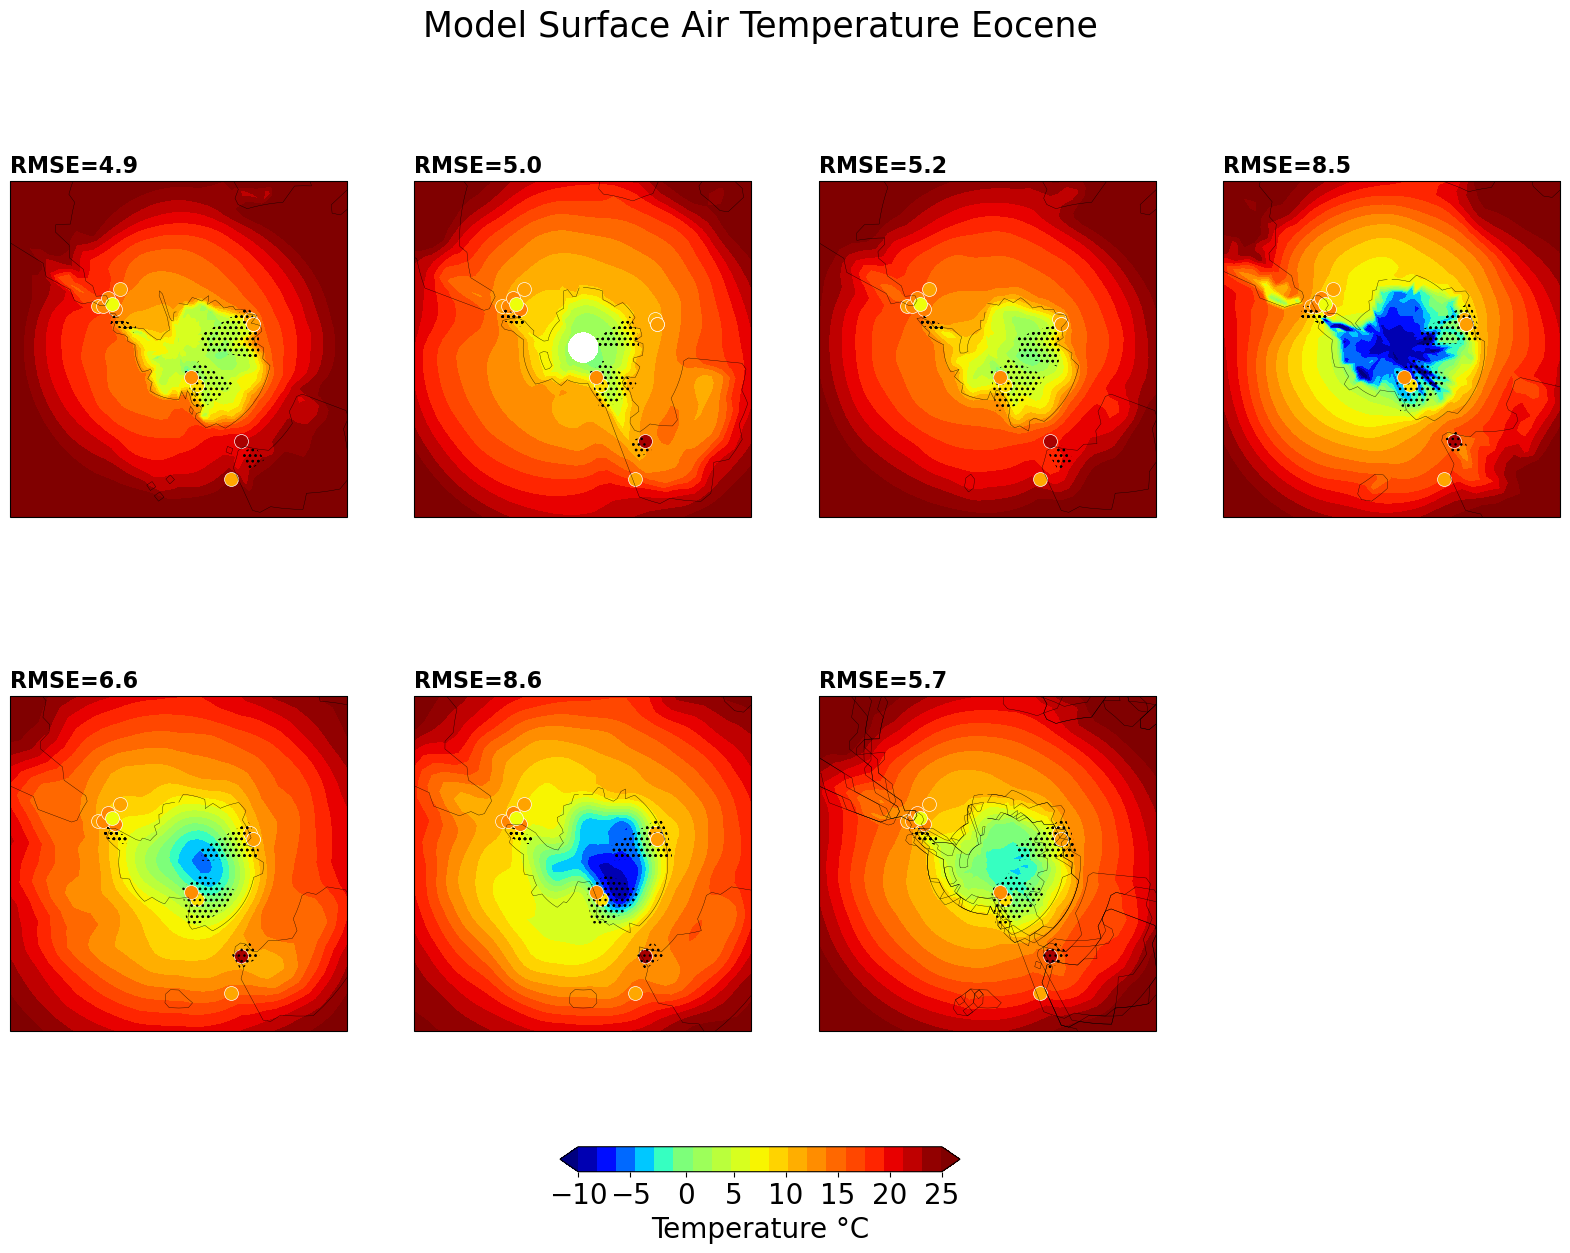

In [31]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATmodel_EO)):
    var = SATmodel_EO[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATmodel_EO.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    coast=landmask_4x[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask_4x[k,:,:]*1
            ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_Eocene[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circles_Eocene[h,j],coord=SATmodel_EO[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations   
        cd=ax.scatter(Eocene_proxy_SAT['Paleolongitude'][h],Eocene_proxy_SAT['Paleolatitude'][h],c=Eocene_proxy_SAT['Eocene SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='white',linewidth=0.5,transform=ccrs.PlateCarree())
        
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature Eocene',fontsize=25)
plt.savefig('SAT_CO2Eocene_proxymodel.pdf')

Oligocene

In [32]:
Oligo_proxy_SAT = EOT_proxy_SAT[EOT_proxy_SAT['Oligo SAT'].notnull()].reset_index(drop=True)

In [33]:
Oligo_proxy_SAT['Paleolongitude'][6]=315

In [34]:
Oligo_proxy_SAT0=Oligo_proxy_SAT[:]
Oligo_proxy_SAT1=Oligo_proxy_SAT[:]
Oligo_proxy_SAT2=Oligo_proxy_SAT[:]
Oligo_proxy_SAT3=Oligo_proxy_SAT[:]
Oligo_proxy_SAT4=Oligo_proxy_SAT[:]
Oligo_proxy_SAT5=Oligo_proxy_SAT[:]
Oligo_proxy_SAT6=Oligo_proxy_SAT[:]

In [35]:
#1st model
Oligo_proxy_SAT0['New paleolat']=Oligo_proxy_SAT0['Paleolatitude']
Oligo_proxy_SAT0['New paleolon']=Oligo_proxy_SAT0['Paleolongitude']

latchange=[-7,-7,0,-4,5,0,-10,-3]
lonchange=[5,5,-10,0,0,-10,-25,-12]
for i in range(0,8):
        Oligo_proxy_SAT0['New paleolat'][i]=Oligo_proxy_SAT0['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT0['New paleolon'][i]=Oligo_proxy_SAT0['Paleolongitude'][i]+lonchange[i]

#2nd model
Oligo_proxy_SAT1['New paleolat']=Oligo_proxy_SAT1['Paleolatitude']
Oligo_proxy_SAT1['New paleolon']=Oligo_proxy_SAT1['Paleolongitude']

latchange=[-12,-12,0,-10,-3,0,-5,-11]
lonchange=[0,0,0,3,2.5,0,-25,-10]
for i in range(0,8):
        Oligo_proxy_SAT1['New paleolat'][i]=Oligo_proxy_SAT1['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT1['New paleolon'][i]=Oligo_proxy_SAT1['Paleolongitude'][i]+lonchange[i]
        
#3rd model        
Oligo_proxy_SAT2['New paleolat']=Oligo_proxy_SAT2['Paleolatitude']
Oligo_proxy_SAT2['New paleolon']=Oligo_proxy_SAT2['Paleolongitude']

latchange=[-8,-8,0,-4,5,0,-5,-3]
lonchange=[15,15,0,0,2,0,-22,-10]
for i in range(0,8):
        Oligo_proxy_SAT2['New paleolat'][i]=Oligo_proxy_SAT2['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT2['New paleolon'][i]=Oligo_proxy_SAT2['Paleolongitude'][i]+lonchange[i]
#4th model        
Oligo_proxy_SAT3['New paleolat']=Oligo_proxy_SAT3['Paleolatitude']
Oligo_proxy_SAT3['New paleolon']=Oligo_proxy_SAT3['Paleolongitude']

latchange=[-5,-5,0,-4,0,0,0,-8]
lonchange=[0,0,0,0,0,0,-20,-12]
for i in range(0,8):
        Oligo_proxy_SAT3['New paleolat'][i]=Oligo_proxy_SAT3['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT3['New paleolon'][i]=Oligo_proxy_SAT3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
Oligo_proxy_SAT4['New paleolat']=Oligo_proxy_SAT4['Paleolatitude']
Oligo_proxy_SAT4['New paleolon']=Oligo_proxy_SAT4['Paleolongitude']

latchange=[-7,-7,0,-6,0,0,-5,-8]
lonchange=[0,0,0,0,-2,0,-22,-14]
for i in range(0,8):
        Oligo_proxy_SAT4['New paleolat'][i]=Oligo_proxy_SAT4['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT4['New paleolon'][i]=Oligo_proxy_SAT4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
Oligo_proxy_SAT5['New paleolat']=Oligo_proxy_SAT5['Paleolatitude']
Oligo_proxy_SAT5['New paleolon']=Oligo_proxy_SAT5['Paleolongitude']

latchange=[-6,-6,0,-4,0,0,-5,-8]
lonchange=[0,0,0,0,0,0,-20,-12]
for i in range(0,8):
        Oligo_proxy_SAT5['New paleolat'][i]=Oligo_proxy_SAT5['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT5['New paleolon'][i]=Oligo_proxy_SAT5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
Oligo_proxy_SAT6['New paleolat']=Oligo_proxy_SAT6['Paleolatitude']
Oligo_proxy_SAT6['New paleolon']=Oligo_proxy_SAT6['Paleolongitude']

latchange=[-5,-5,0,-4,0,0,-5,-8]
lonchange=[0,0,0,0,0,0,-23,-12]
for i in range(0,8):
        Oligo_proxy_SAT6['New paleolat'][i]=Oligo_proxy_SAT6['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT6['New paleolon'][i]=Oligo_proxy_SAT6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [36]:
Oligo_proxy_SAT0=Oligo_proxy_SAT0.to_xarray()
Oligo_proxy_SAT1=Oligo_proxy_SAT1.to_xarray()
Oligo_proxy_SAT2=Oligo_proxy_SAT2.to_xarray()
Oligo_proxy_SAT3=Oligo_proxy_SAT3.to_xarray()
Oligo_proxy_SAT4=Oligo_proxy_SAT4.to_xarray()
Oligo_proxy_SAT5=Oligo_proxy_SAT5.to_xarray()
Oligo_proxy_SAT6=Oligo_proxy_SAT6.to_xarray()

Oligo_SAT=Oligo_proxy_SAT0.expand_dims(dim='nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT1],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT2],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT3],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT4],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT5],'nmodels')
Oligo_SAT=xr.concat([Oligo_SAT,Oligo_proxy_SAT6],'nmodels')

In [37]:
#Source area for Oligocene timeslices
datlist=list([0,1,2,3,4,5,6,7])
lats=range(0,73)
lons=range(0,96)
lat=SAT_conc4x.latitude
lon=SAT_conc4x.longitude
circles_Oligo=np.empty([8,7,73,96])
circles_Oligo=xr.DataArray(circles_Oligo,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATmodel_Oligo)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Oligo_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Oligo_SAT['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==1: #same cores different proxies
            if j==0:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<7
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2 or i==5:
            if j==1:
                masklon = (SATmodel_Oligo[j].longitude[lons]- originlon)<15
                masklonl= (SATmodel_Oligo[j].longitude[lons]- originlon)>-40
                masklat = (SATmodel_Oligo[j].latitude[lats]-originlat)<6
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>-8
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = (SATmodel_Oligo[j].longitude[lons]- originlon)<17
                masklonl= (SATmodel_Oligo[j].longitude[lons]- originlon)>-40
                masklat = (SATmodel_Oligo[j].latitude[lats]-originlat)<8
                masklatl = (SATmodel_Oligo[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<10
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
                arr[masklat & masklon] = 1
        if i==4:
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<5.5
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<7
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        if i==6:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        if i==7:
                masklon = abs(SATmodel_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATmodel_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        arr = np.where(SATmodel_Oligo[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circles_Oligo[i,j,:,:]=arr; del arr 

In [38]:
datlist=list([0,1,2,3,4,5,6,7])
prox=np.empty((8))
array=np.empty((8,7,73,96))
Oligo_modelSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATmodel_Oligo)):
    for i in range(len(datlist)):
        Oligo_temp= SATmodel_Oligo[ex][:,:]
        Oligo_modelSAT[i,ex,:,:]=np.where(circles_Oligo[i,ex,:,:]==1, Oligo_temp, np.nan)
        prox[i] = Oligo_proxy_SAT['Oligo SAT'][datlist][i]
        

Oligo_modelSAT['latitude']=SATmodel_Oligo.latitude
Oligo_modelSAT['longitude']=SATmodel_Oligo.longitude 

weights=np.cos(np.deg2rad(SATmodel_Oligo.latitude))
SAT_weighted=Oligo_modelSAT.weighted(weights)
Oligo_weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((8,7))
rms_Oligo=np.empty((7))
for ex in range(0,len(SATmodel_Oligo)):
        errors[:,ex]=(Oligo_weighted_SAT[:,ex]-prox[:])
        rms_Oligo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_Oligo

array([6.5, 7.2, 8.7, 9.4, 9. , 9.3, 7.2])

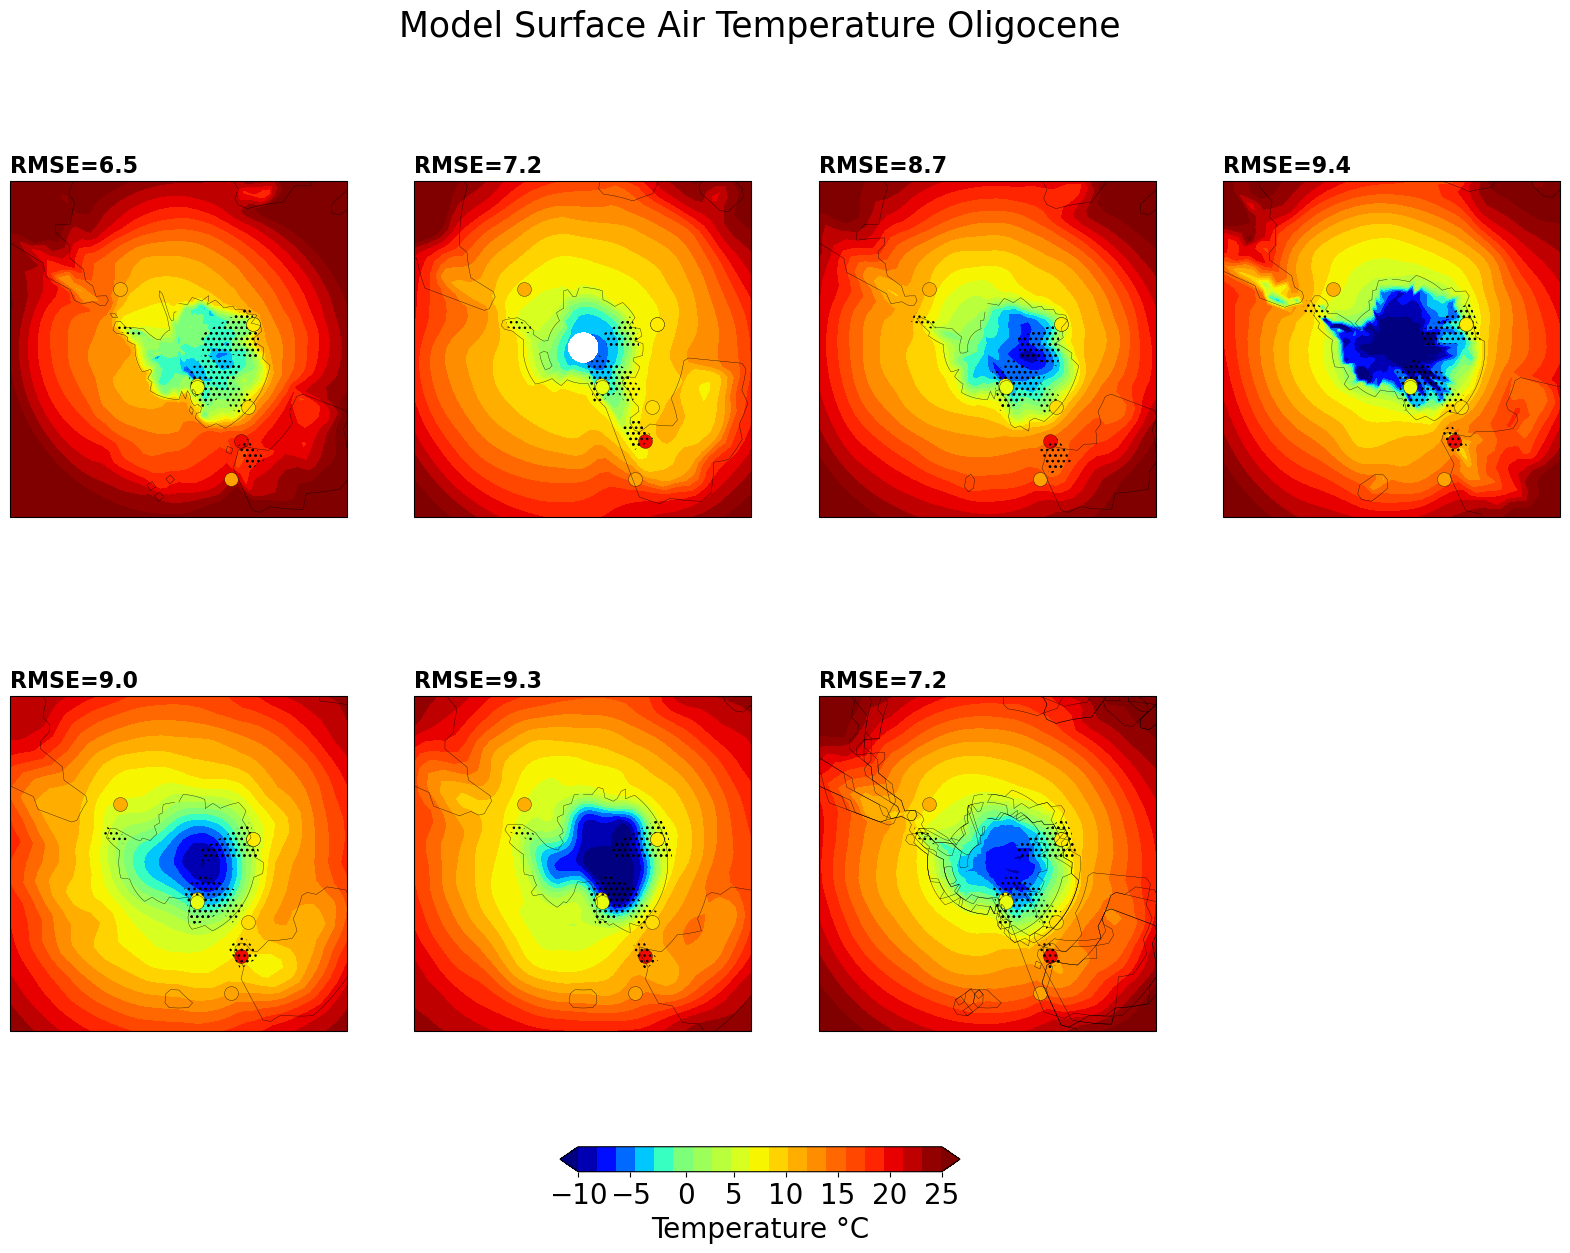

In [39]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATmodel_Oligo)):
    var = SATmodel_Oligo[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATmodel_Oligo.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    if j==6:
        for k in range(0,5):
            coast_all=landmask_2x[k,:,:]*1
            ax.contour(landmask_2x.longitude,landmask_2x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_2x[j,:,:]*1
        ax.contour(landmask_2x.longitude,landmask_2x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_Oligo[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circles_Oligo[h,j],coord=SATmodel_Oligo[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(Oligo_proxy_SAT['Paleolongitude'][h],Oligo_proxy_SAT['Paleolatitude'][h],c=Oligo_proxy_SAT['Oligo SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
    
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature Oligocene',fontsize=25)
plt.savefig('SAT_CO2Oligocene_proxymodel.pdf')

EOT difference

In [40]:
#create separate datafiles for each model for the proxy input to adjust paleocoordinates and model averaging
proxy_SAT=EOT_proxy_SAT.dropna().reset_index(drop=True)
proxy_SAT_0=proxy_SAT[:]
proxy_SAT_1=proxy_SAT[:]
proxy_SAT_2=proxy_SAT[:]
proxy_SAT_3=proxy_SAT[:]
proxy_SAT_4=proxy_SAT[:]
proxy_SAT_5=proxy_SAT[:]
proxy_SAT_6=proxy_SAT[:]

In [41]:
#1st model
proxy_SAT_0['New paleolat']=proxy_SAT_0['Paleolatitude']
proxy_SAT_0['New paleolon']=proxy_SAT_0['Paleolongitude']

latchange=[-7,-7,0,5,-10,-3]
lonchange=[5,5,-10,0,-18,-12]
for i in range(0,6):
        proxy_SAT_0['New paleolat'][i]=proxy_SAT_0['Paleolatitude'][i]+latchange[i]
        proxy_SAT_0['New paleolon'][i]=proxy_SAT_0['Paleolongitude'][i]+lonchange[i]

#2nd model
proxy_SAT_1['New paleolat']=proxy_SAT_1['Paleolatitude']
proxy_SAT_1['New paleolon']=proxy_SAT_1['Paleolongitude']

latchange=[-12,-12,0,-3,-5,-11]
lonchange=[0,0,0,2.5,-18,-10]
for i in range(0,6):
        proxy_SAT_1['New paleolat'][i]=proxy_SAT_1['Paleolatitude'][i]+latchange[i]
        proxy_SAT_1['New paleolon'][i]=proxy_SAT_1['Paleolongitude'][i]+lonchange[i]

#3rd model        
proxy_SAT_2['New paleolat']=proxy_SAT_2['Paleolatitude']
proxy_SAT_2['New paleolon']=proxy_SAT_2['Paleolongitude']
latchange=[-8,-8,0,5,-5,-3]
lonchange=[15,15,0,2,-15,-10]
for i in range(0,6):
        proxy_SAT_2['New paleolat'][i]=proxy_SAT_2['Paleolatitude'][i]+latchange[i]
        proxy_SAT_2['New paleolon'][i]=proxy_SAT_2['Paleolongitude'][i]+lonchange[i]

#4th model        
proxy_SAT_3['New paleolat']=proxy_SAT_3['Paleolatitude']
proxy_SAT_3['New paleolon']=proxy_SAT_3['Paleolongitude']        
latchange=[-5,-5,0,0,-2,-8]
lonchange=[0,0,0,0,-13,-12]
for i in range(0,6):
        proxy_SAT_3['New paleolat'][i]=proxy_SAT_3['Paleolatitude'][i]+latchange[i]
        proxy_SAT_3['New paleolon'][i]=proxy_SAT_3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
proxy_SAT_4['New paleolat']=proxy_SAT_4['Paleolatitude']
proxy_SAT_4['New paleolon']=proxy_SAT_4['Paleolongitude']        
latchange=[-7,-7,0,0,-5,-8]
lonchange=[0,0,0,-2,-15,-14]
for i in range(0,6):
        proxy_SAT_4['New paleolat'][i]=proxy_SAT_4['Paleolatitude'][i]+latchange[i]
        proxy_SAT_4['New paleolon'][i]=proxy_SAT_4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
proxy_SAT_5['New paleolat']=proxy_SAT_5['Paleolatitude']
proxy_SAT_5['New paleolon']=proxy_SAT_5['Paleolongitude']        
latchange=[-6,-6,0,0,-5,-8]
lonchange=[0,0,0,0,-13,-12]
for i in range(0,6):
        proxy_SAT_5['New paleolat'][i]=proxy_SAT_5['Paleolatitude'][i]+latchange[i]
        proxy_SAT_5['New paleolon'][i]=proxy_SAT_5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
proxy_SAT_6['New paleolat']=proxy_SAT_6['Paleolatitude']
proxy_SAT_6['New paleolon']=proxy_SAT_6['Paleolongitude']        
latchange=[-5,-5,0,0,-5,-8]
lonchange=[0,0,0,0,-16,-12]
for i in range(0,6):
        proxy_SAT_6['New paleolat'][i]=proxy_SAT_6['Paleolatitude'][i]+latchange[i]
        proxy_SAT_6['New paleolon'][i]=proxy_SAT_6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [42]:
proxy_SAT_0=proxy_SAT_0.to_xarray()
proxy_SAT_1=proxy_SAT_1.to_xarray()
proxy_SAT_2=proxy_SAT_2.to_xarray()
proxy_SAT_3=proxy_SAT_3.to_xarray()
proxy_SAT_4=proxy_SAT_4.to_xarray()
proxy_SAT_5=proxy_SAT_5.to_xarray()
proxy_SAT_6=proxy_SAT_6.to_xarray()

SAT_proxy=proxy_SAT_0.expand_dims(dim='nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_1],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_2],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_3],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_4],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_5],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_6],'nmodels')

In [43]:
proxy_SAT['Paleolongitude'][0]=69
proxy_SAT['Paleolongitude'][2]=150

In [44]:
datlist=list([0,1,2,3,4,5])
lats=range(0,73)
lons=range(0,96)
circles=[] #
lat=diff_modelconc.latitude
lon=diff_modelconc.longitude
circles=np.empty([6,7,73,96])
circles=xr.DataArray(circles,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(diff_modelconc)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=SAT_proxy['New paleolat'][j][datlist][i]
        originlon=SAT_proxy['New paleolon'][j][datlist][i]
        if i==0 or i==1: #same cores different proxies
            if j==0:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<17
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<7
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<15
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2:
            masklon = (diff_modelconc[j].longitude[lons]- originlon)<17
            masklonl= (diff_modelconc[j].longitude[lons]- originlon)>-40
            masklat = (diff_modelconc[j].latitude[lats]-originlat)<8
            masklatl = (diff_modelconc[j].latitude[lats]-originlat)>-6
            arr[masklat & masklatl & masklon & masklonl] = 1
        if i==4:
            masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<6
            masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        if i==3 or i==5:
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<5.5
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<7
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        arr = np.where(diff_modelconc[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circles[i,j,:,:]=arr; del arr 

In [45]:
datlist=list([0,1,2,3,4,5])
array=np.empty((6,7,73,96))
mean_SAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
prox=np.empty((6))
for ex in range(0,len(diff_modelconc)):
    for i in range(0, len(datlist)):
        modelmean= diff_modelconc[ex,:,:]
        mean_SAT[i,ex,:,:]=np.where(circles[i,ex,:,:]==1, modelmean, np.nan)
        prox[i] = proxy_SAT['EOT diff'][datlist][i]
        
mean_SAT['latitude']=diff_modelconc.latitude
mean_SAT['longitude']=diff_modelconc.longitude
   
weights=np.cos(np.deg2rad(diff_modelconc.latitude))
SAT_weighted=mean_SAT.weighted(weights)
weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((6,7))
rms_diffSAT=np.empty((7))
for ex in range(0,len(diff_modelconc)):
        errors[:,ex]=(weighted_SAT[:,ex]-prox[:])
        rms_diffSAT[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_diffSAT

array([3. , 2.9, 5. , 1.7, 3.2, 1.6, 2.6])

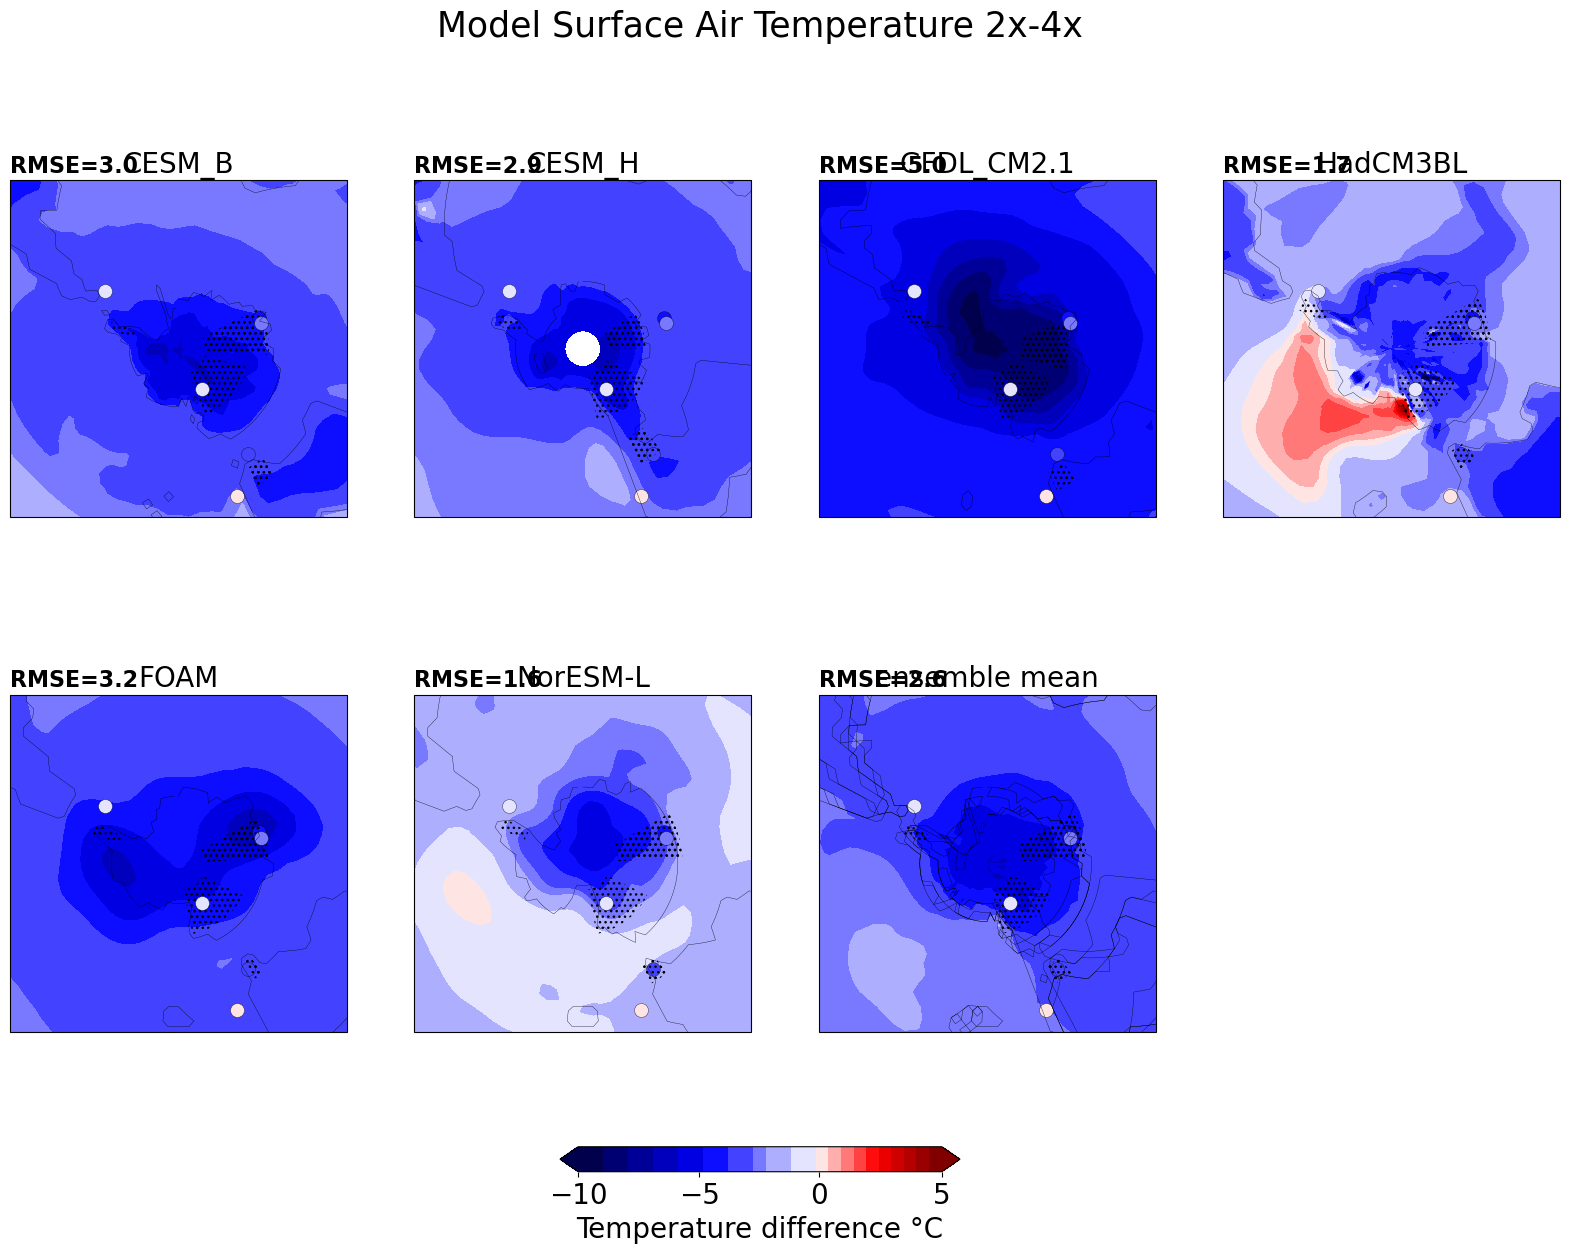

In [46]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelconc)):
    var = diff_modelconc[j][lats,lons]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelconc[j].longitude)

# Make a filled contour plot
    datlist=[0,1,2,3,4,5]
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    if j==6:
        for k in range(0,5):
            coast_all=landmask_4x[k,:,:]*1
            ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        coast=landmask_4x[j,:,:]*1
        ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffSAT[j]),fontweight='bold', fontsize=16,loc='left')
    for h in (datlist):
        circ,lon= add_cyclic_point(circles[h,j],coord=diff_modelconc[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SAT['Paleolongitude'][h],proxy_SAT['Paleolatitude'][h],c=proxy_SAT['EOT diff'][h],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
       
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature 2x-4x',fontsize=25)
plt.savefig('SAT_tempdiff_proxymodel.pdf')

Sea Surface Temperatures-Using nearest point

In [17]:
EOT_proxy_SST['New paleolat']=EOT_proxy_SST['Paleolatitude']
EOT_proxy_SST['New paleolon']=EOT_proxy_SST['Paleolongitude']

In [47]:
# averages the two site 511 bayspline records
avg511_dict = {'Paleolatitude':[-53.96],
        'Paleolongitude':[323.80],
        'Oligo SST':[10.8],
        'Eocene SST':[17.9],
        'EOT diff':[-7.1],
        'New paleolat':[-53.96],
        'New paleolon':[323.80]}
        
avg511_df1 = pd.DataFrame(avg511_dict)    
avg=[-53.96,323.80,10.8,17.9,-7.1,-53.96,323.80]

In [48]:
EOT_proxy_SST = pd.concat([EOT_proxy_SST, avg511_df1], ignore_index = True)

In [49]:
EOT_proxy_SST=EOT_proxy_SST.drop([10]).reset_index(drop=True)
EOT_proxy_SST=EOT_proxy_SST.drop([9]).reset_index(drop=True)

In [50]:
latchange=[5,5,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0]
lonchange=[0,0,0,5,0,0,0,0,0,0,0,5,0,15,15,0,0,0,0,0,0,0,0,0,0]
for i in range(0,25):
    EOT_proxy_SST['New paleolat'][i]=EOT_proxy_SST['Paleolatitude'][i]+latchange[i]
    EOT_proxy_SST['New paleolon'][i]=EOT_proxy_SST['Paleolongitude'][i]+lonchange[i]
    

In [51]:
Eocene_proxy_SST = EOT_proxy_SST[EOT_proxy_SST['Eocene SST'].notnull()].reset_index(drop=True)
Oligo_proxy_SST = EOT_proxy_SST[EOT_proxy_SST['Oligo SST'].notnull()].reset_index(drop=True)
proxy_SST = EOT_proxy_SST[EOT_proxy_SST['EOT diff'].notnull()].reset_index(drop=True)

Find nearest grid cell and calculate RMSE between proxy and model for SST

In [52]:
#Eocene
prox=np.empty((11))
Eocenemodel_SST=np.empty((11,7))
for i in range(0,len(Eocene_proxy_SST)):
    for j in range (0,len(SSTmodel_EO)):
        Eocenemodel_SST[i,j]=(SSTmodel_EO[j].sel(latitude=Eocene_proxy_SST['New paleolat'][i],longitude=Eocene_proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = Eocene_proxy_SST['Eocene SST'][i]

        errors=np.empty((11,7))
rms_EOSST=np.empty((7))
for ex in range(0,len(SSTmodel_EO)):
    errors[:,ex]=(Eocenemodel_SST[:,ex]-prox[:])
    rms_EOSST[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(Eocene_proxy_SST)).round(decimals=1) 
rms_EOSST

array([6.1, 6.6, 6.4, 7.1, 7.9, 8.2, 6.6])

In [53]:
#Oligocene
Oligomodel_SST=np.empty((10,7))
prox=np.empty((10))
for i in range(0,len(Oligo_proxy_SST)):
    for j in range (0,len(SSTmodel_Oligo)):
        Oligomodel_SST[i,j]=(SSTmodel_Oligo[j].sel(latitude=Oligo_proxy_SST['New paleolat'][i],longitude=Oligo_proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = Oligo_proxy_SST['Oligo SST'][i]
    
errors=np.empty((10,7))
rms_OligoSST=np.empty((7))
for ex in range(0,len(SSTmodel_Oligo)):
    errors[:,ex]=(Oligomodel_SST[:,ex]-prox[:])
    rms_OligoSST[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(Oligo_proxy_SST)).round(decimals=1) 
rms_OligoSST

array([6.7, 7.6, 6.7, 7.5, 8.8, 8.1, 7.4])

In [54]:
#difference
diffmodel_SST=np.empty((9,7))
prox=np.empty((9))
for i in range(0,len(proxy_SST)):
    for j in range (0,len(diff_modelconc_SST)):
        diffmodel_SST[i,j]=(diff_modelconc_SST[j].sel(latitude=proxy_SST['New paleolat'][i],longitude=proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = proxy_SST['EOT diff'][i]

errors=np.empty((9,7))
rms_diffSST=np.empty((7))
for ex in range(0,len(diff_modelconc_SST)):
    errors[:,ex]=(diffmodel_SST[:,ex]-prox[:])
    rms_diffSST[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(proxy_SST)).round(decimals=1)
rms_diffSST

array([2.4, 2.2, 4. , 1.9, 2.9, 2. , 2.3])

Plot SST proxy and models

In [55]:
#offsetting points to plot data from same cores
Eocene_proxy_SST['New paleolon'][4]=318
Eocene_proxy_SST['New paleolon'][5]=185
Eocene_proxy_SST['New paleolon'][9]=306

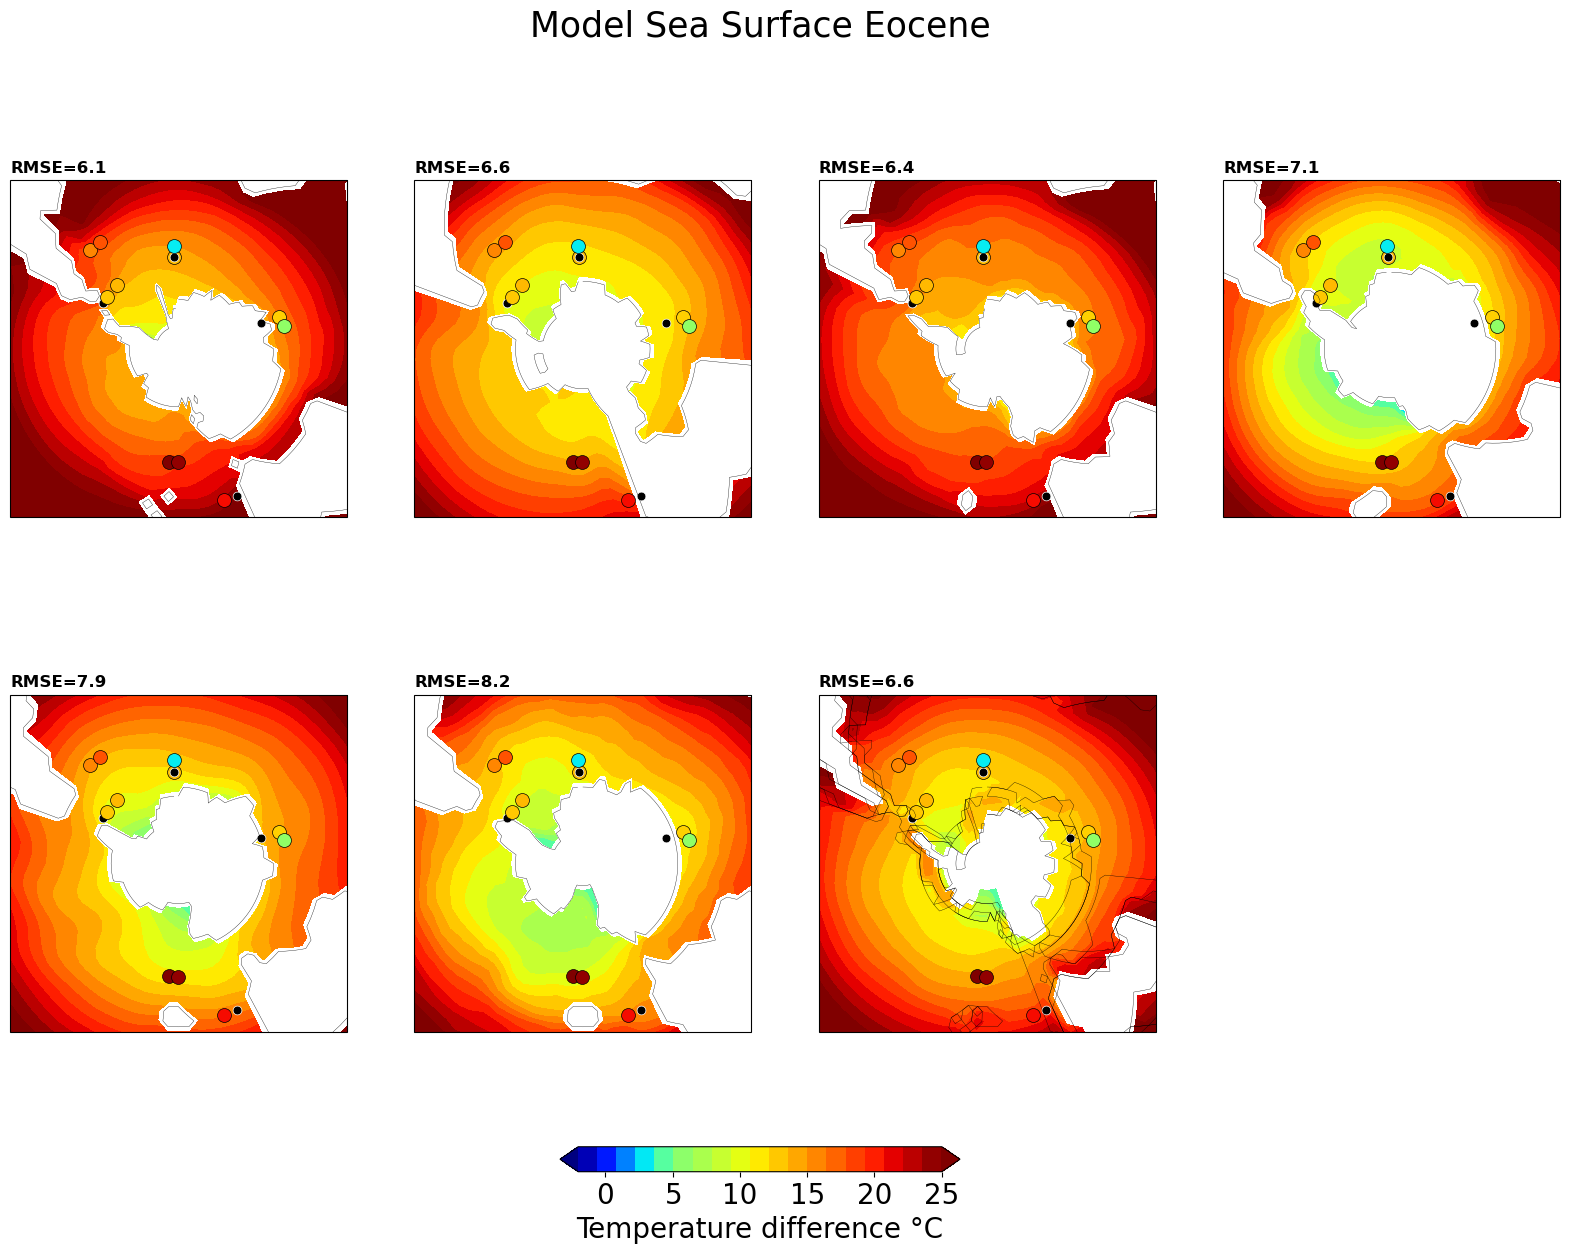

In [57]:
#Eocene
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-2,vcenter=5,vmax=25)

for j in range(0,len(SSTmodel_EO)):
    var = SSTmodel_EO[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SSTmodel_EO.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-2,25,20),extend='both')
    coast=landmask_4x[j,:,:]*1
    for i in range(0,len(Eocene_proxy_SST)):
        cd=ax.scatter(Eocene_proxy_SST['Paleolongitude'][i],Eocene_proxy_SST['Paleolatitude'][i],c='black',s=40,cmap='jet',norm=norm,edgecolor='white',linewidth=0.5,transform=ccrs.PlateCarree())
        cf=ax.scatter(Eocene_proxy_SST['New paleolon'][i],Eocene_proxy_SST['New paleolat'][i],c=Eocene_proxy_SST['Eocene SST'][i],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   
    if j==6:
        for k in range(0,5):
            coast_all=landmask_4x[k,:,:]*1
            ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        ax.contour(landmask_4x.longitude,landmask_4x.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_EOSST[j]),fontweight='bold', fontsize=12,loc='left')
    
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,5,10,15,20,25])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Eocene',fontsize=25)
plt.savefig('SST_CO2Eocene_proxymodel.pdf')

In [28]:
#offsetting points to plot data from same cores
Oligo_proxy_SST['New paleolon'][3]=352
Oligo_proxy_SST['New paleolon'][5]=185
Oligo_proxy_SST['New paleolon'][4]=318

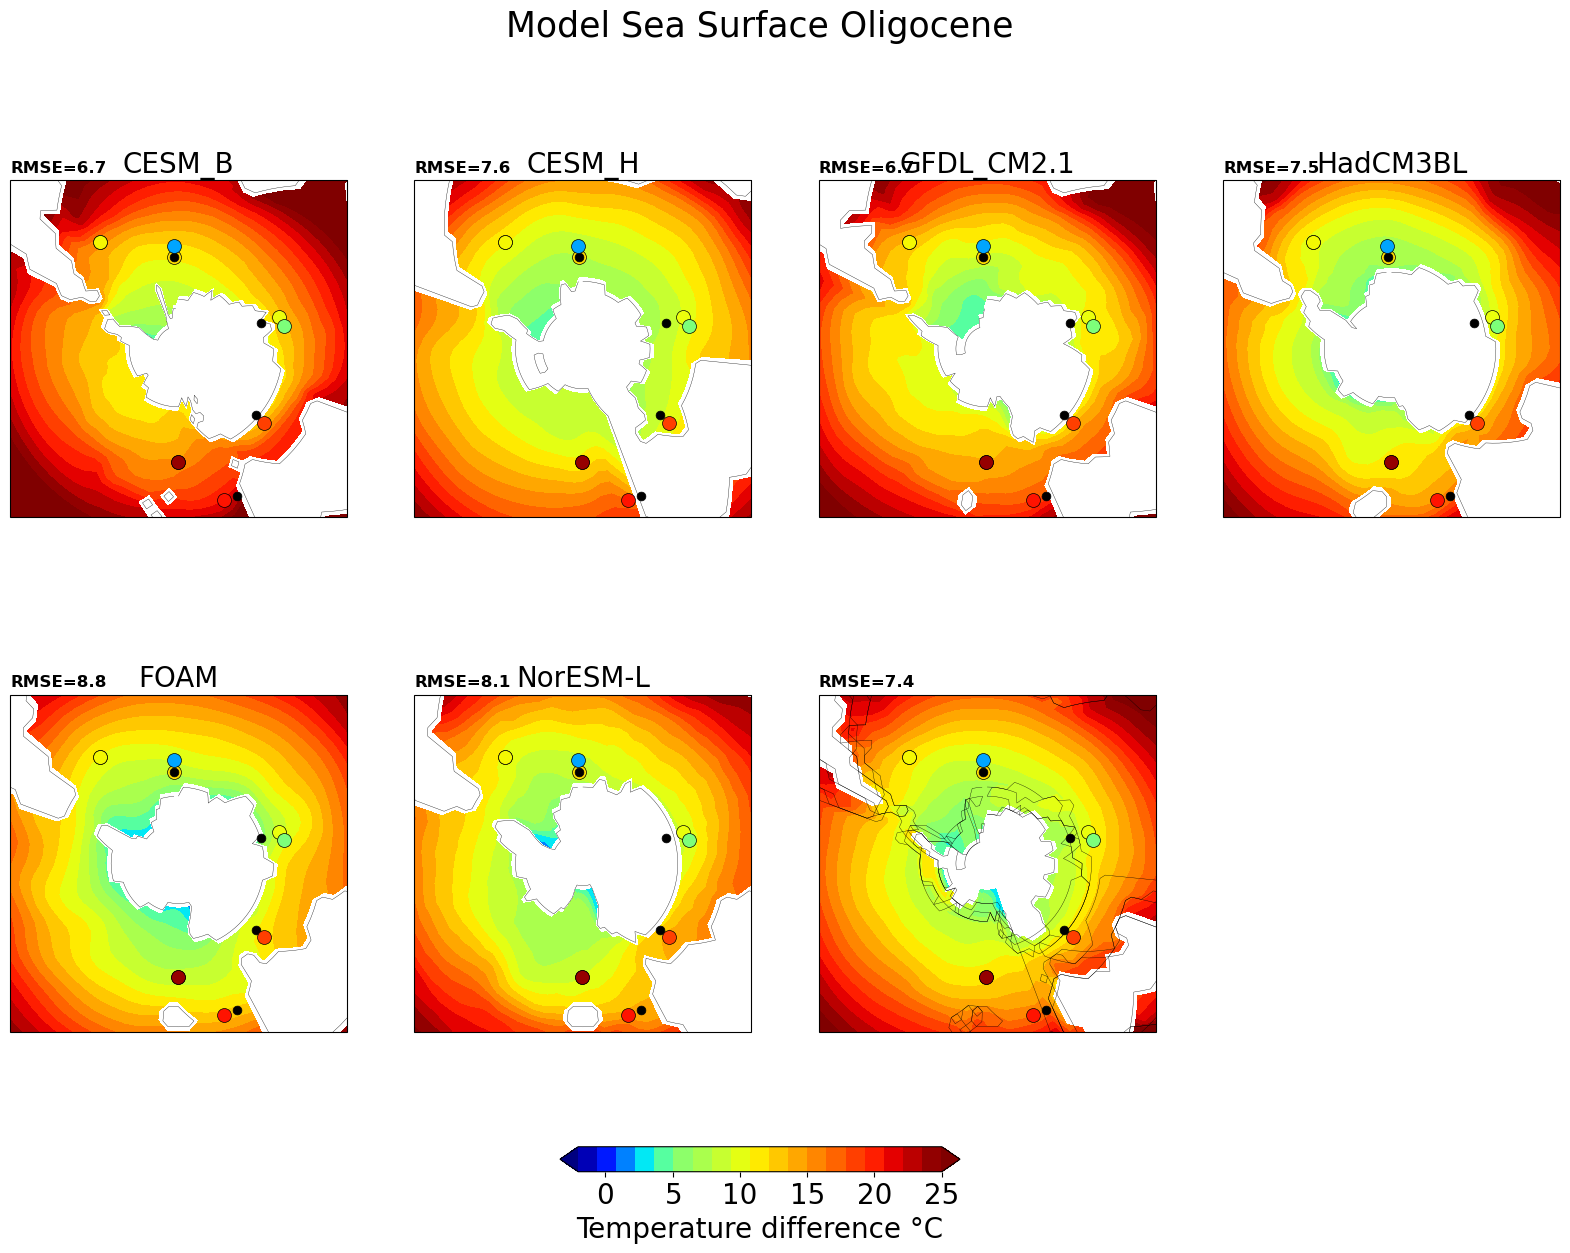

In [58]:
#Oligocene
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-2,vcenter=5,vmax=25)

for j in range(0,len(SSTmodel_Oligo)):
    var = SSTmodel_Oligo[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SSTmodel_Oligo.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-2,25,20),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_OligoSST[j]),fontweight='bold', fontsize=12,loc='left')
  
    for i in range(0,len(Oligo_proxy_SST)):
#Add in proxy datapoints and new point locations
        cd=ax.scatter(Oligo_proxy_SST['Paleolongitude'][i],Oligo_proxy_SST['Paleolatitude'][i],c='black',s=40,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree())
        cf=ax.scatter(Oligo_proxy_SST['New paleolon'][i],Oligo_proxy_SST['New paleolat'][i],c=Oligo_proxy_SST['Oligo SST'][i],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,5,10,15,20,25])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Oligocene',fontsize=25)
plt.savefig('SST_CO2Oligocene_proxymodel.pdf')

In [30]:
#offsetting points to plot data from same cores
proxy_SST['New paleolon'][3]=352
proxy_SST['New paleolon'][4]=317
proxy_SST['New paleolon'][5]=185

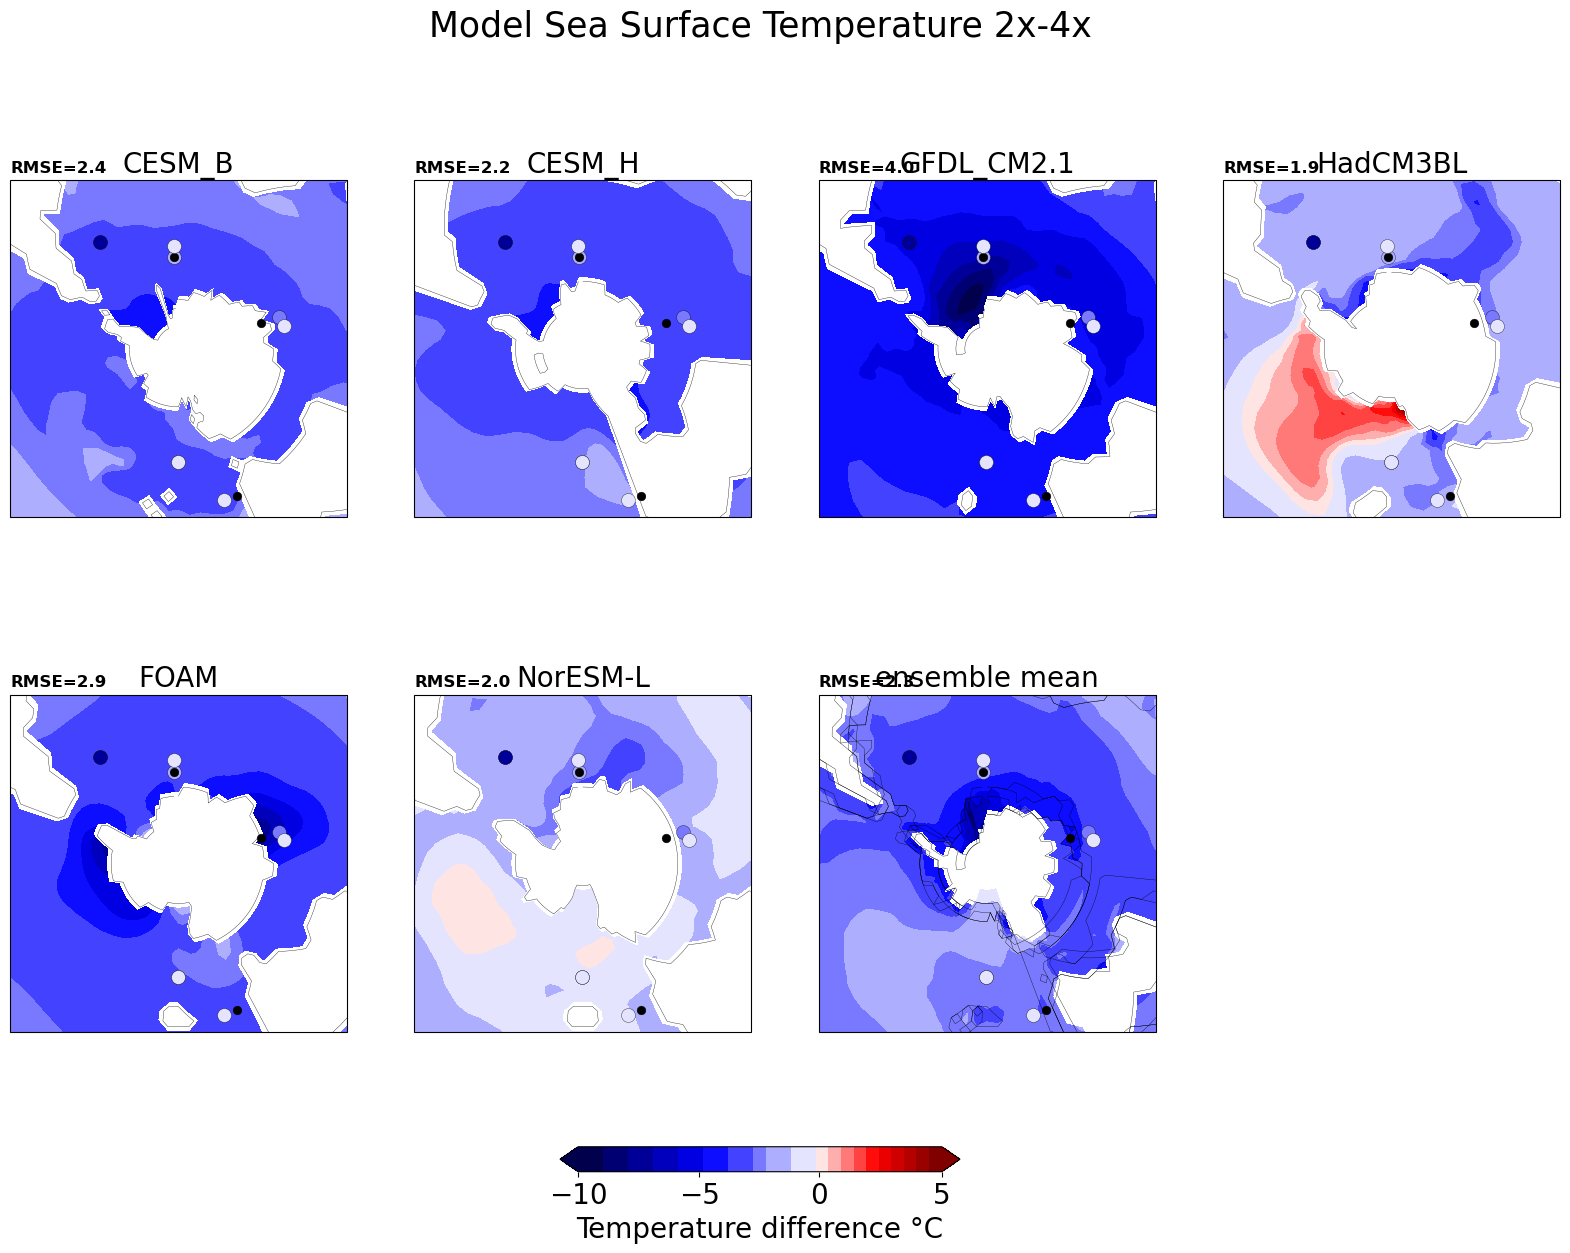

In [59]:
#EOR difference
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelconc_SST)):
    var = diff_modelconc_SST[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelconc_SST.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffSST[j]),fontweight='bold', fontsize=12,loc='left')
    for i in range(0,len(proxy_SST)):
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SST['Paleolongitude'][i],proxy_SST['Paleolatitude'][i],c='k',s=40,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
        cf=ax.scatter(proxy_SST['New paleolon'][i],proxy_SST['New paleolat'][i],c=proxy_SST['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature 2x-4x',fontsize=25)
plt.savefig('SST_CO2diff_proxymodel.pdf')

Estimating pCO2 drop

In [60]:
#create testarray for scaling
nxx=101
testarray=np.linspace(0,2,nxx)

In [61]:
def SKILL(my_mod,my_dat,ncols):
    ans=math.sqrt(sum((my_mod-my_dat)*(my_mod-my_dat))/(1.0*ncols)) #ncols corresponds to the proxy data RMSE
    return ans

In [62]:
#Scale model by testarray
array=np.empty((101,6,7))
vect=xr.DataArray(array,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,len(weighted_SAT)):
        vect[j,i,:]=testarray[j]*weighted_SAT[i,:]
        
array_SST=np.empty((101,9,7))
vect_SST=xr.DataArray(array_SST,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,len(diffmodel_SST)):
        vect_SST[j,i,:]=testarray[j]*diffmodel_SST[i,:]

In [63]:
#calculate error
errs_1d=np.empty((101,7))
for i in range(0,len(vect.nxx)):
    for j in range(0,len(vect.nmodels)):
        errs_1d[i,j]=SKILL(vect[i,:,j],proxy_SAT['EOT diff'],6)
        
errs_1d_SST=np.empty((101,7))
for i in range(0,len(vect_SST.nxx)):
    for j in range(0,len(vect_SST.nmodels)):
        errs_1d_SST[i,j]=SKILL(vect_SST[i,:,j],proxy_SST['EOT diff'],9)

inval_1d=np.min(errs_1d,axis=0)
ind_1d=np.argmin(errs_1d,axis=0)
inval_1d_SST=np.min(errs_1d_SST,axis=0)
ind_1d_SST=np.argmin(errs_1d_SST,axis=0)

In [65]:
#CO2 during Eocene based on estiamted 560ppm post-EOT and estimated percent decrease across EOT
CO2drop=560*2**testarray[ind_1d]
percentdecrease=(CO2drop-560)/CO2drop*100
print(CO2drop,percentdecrease)

CO2drop_SST=560*2**testarray[ind_1d_SST]
percentdecrease_SST=(CO2drop_SST-560)/CO2drop_SST*100
print(CO2drop_SST,percentdecrease_SST)

[749.23943068 759.69842337 679.94913526 897.1982629  738.92443003
 935.29846976 770.30341816] [25.25753757 26.28653914 17.64089827 37.58347255 24.21417167 40.12606477
 27.30137413]
[ 837.11557924  872.66432922  718.71850264 1167.56165214  770.30341816
 1217.14304603  848.80127725] [33.10362226 35.82870512 22.08354203 52.03679403 27.30137413 53.99061747
 34.02460446]


In [66]:
#Estimated ppm decrease across EOT
Co2change=CO2drop-560
Co2change_SST=CO2drop_SST-560
print(Co2change,Co2change_SST)

[189.23943068 199.69842337 119.94913526 337.1982629  178.92443003
 375.29846976 210.30341816] [277.11557924 312.66432922 158.71850264 607.56165214 210.30341816
 657.14304603 288.80127725]


Scaled CO2 perturbation best fit plot

In [67]:
diff_modelscale_SST=diff_modelconc_SST.copy(deep=True)
for i in range (0,len(ind_1d)):
        diff_modelscale_SST[i,:,:]=testarray[ind_1d_SST[i]]*diff_modelconc_SST[i,:,:]

In [68]:
diff_modelscale_SAT=diff_modelconc.copy(deep=True)
for i in range (0,len(ind_1d)):
        diff_modelscale_SAT[i,:,:]=testarray[ind_1d[i]]*diff_modelconc[i,:,:]

In [69]:
#difference best fit
diffmodel_SST=np.empty((9,7))
prox=np.empty((9))
for i in range(0,len(proxy_SST)):
    for j in range (0,len(diff_modelscale_SST)):
        diffmodel_SST[i,j]=(diff_modelscale_SST[j].sel(latitude=proxy_SST['New paleolat'][i],longitude=proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = proxy_SST['EOT diff'][i]

errors=np.empty((9,7))
rms_diffbestSST=np.empty((7))
for ex in range(0,len(diff_modelscale_SST)):
    errors[:,ex]=(diffmodel_SST[:,ex]-prox[:])
    rms_diffbestSST[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(proxy_SST)).round(decimals=1)
rms_diffbestSST

array([2. , 1.9, 2. , 1.9, 2.1, 2. , 2. ])

In [70]:
#calculating RMSE for SAT best fits from the scaling
datlist=list([0,1,2,3,4,5])
lats=range(0,73)
lons=range(0,96)
circles=[] #
lat=diff_modelscale_SAT.latitude
lon=diff_modelscale_SAT.longitude
circles=np.empty([6,7,73,96])
circles_SATbest=xr.DataArray(circles,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(diff_modelscale_SAT)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=SAT_proxy['New paleolat'][j][datlist][i]
        originlon=SAT_proxy['New paleolon'][j][datlist][i]
       
        if i==0 or i==1: #same cores different proxies
            if j==0:
                masklon = abs(diff_modelscale_SAT[j].longitude[lons]- originlon)<17
                masklat = abs(diff_modelscale_SAT[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(diff_modelscale_SAT[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelscale_SAT[j].latitude[lats]-originlat)<7
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(diff_modelscale_SAT[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelscale_SAT[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(diff_modelscale_SAT[j].longitude[lons]- originlon)<15
                masklat = abs(diff_modelscale_SAT[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2:
            masklon = (diff_modelscale_SAT[j].longitude[lons]- originlon)<17
            masklonl= (diff_modelscale_SAT[j].longitude[lons]- originlon)>-40
            masklat = (diff_modelscale_SAT[j].latitude[lats]-originlat)<8
            masklatl = (diff_modelscale_SAT[j].latitude[lats]-originlat)>-6
            arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3 or i==5:
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = abs(diff_modelscale_SAT[j].longitude[lons]- originlon)<5.5
                masklat = abs(diff_modelscale_SAT[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(diff_modelscale_SAT[j].longitude[lons]- originlon)<7
                masklat = abs(diff_modelscale_SAT[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        if i==4:
            masklon = abs(diff_modelscale_SAT[j].longitude[lons]- originlon)<6
            masklat = abs(diff_modelscale_SAT[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        arr = np.where(diff_modelscale_SAT[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circles_SATbest[i,j,:,:]=arr; del arr 

In [71]:
datlist=list([0,1,2,3,4,5])
array=np.empty((6,7,73,96))
mean_SAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
prox=np.empty((6))
for ex in range(0,len(diff_modelscale_SAT)):
    for i in range(0, len(datlist)):
        modelmean= diff_modelscale_SAT[ex,:,:]
        mean_SAT[i,ex,:,:]=np.where(circles_SATbest[i,ex,:,:]==1, modelmean, np.nan)
        prox[i] = proxy_SAT['EOT diff'][datlist][i]
        
mean_SAT['latitude']=diff_modelscale_SAT.latitude
mean_SAT['longitude']=diff_modelscale_SAT.longitude
   
weights=np.cos(np.deg2rad(diff_modelscale_SAT.latitude))
SAT_weighted=mean_SAT.weighted(weights)
weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((6,7))
rms_bestSAT=np.empty((7))
for ex in range(0,len(diff_modelscale_SAT)):
        errors[:,ex]=(weighted_SAT[:,ex]-prox[:])
        rms_bestSAT[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_bestSAT

array([1.6, 1.5, 1.4, 1.4, 1.5, 1.4, 1.5])

Plotting best fits

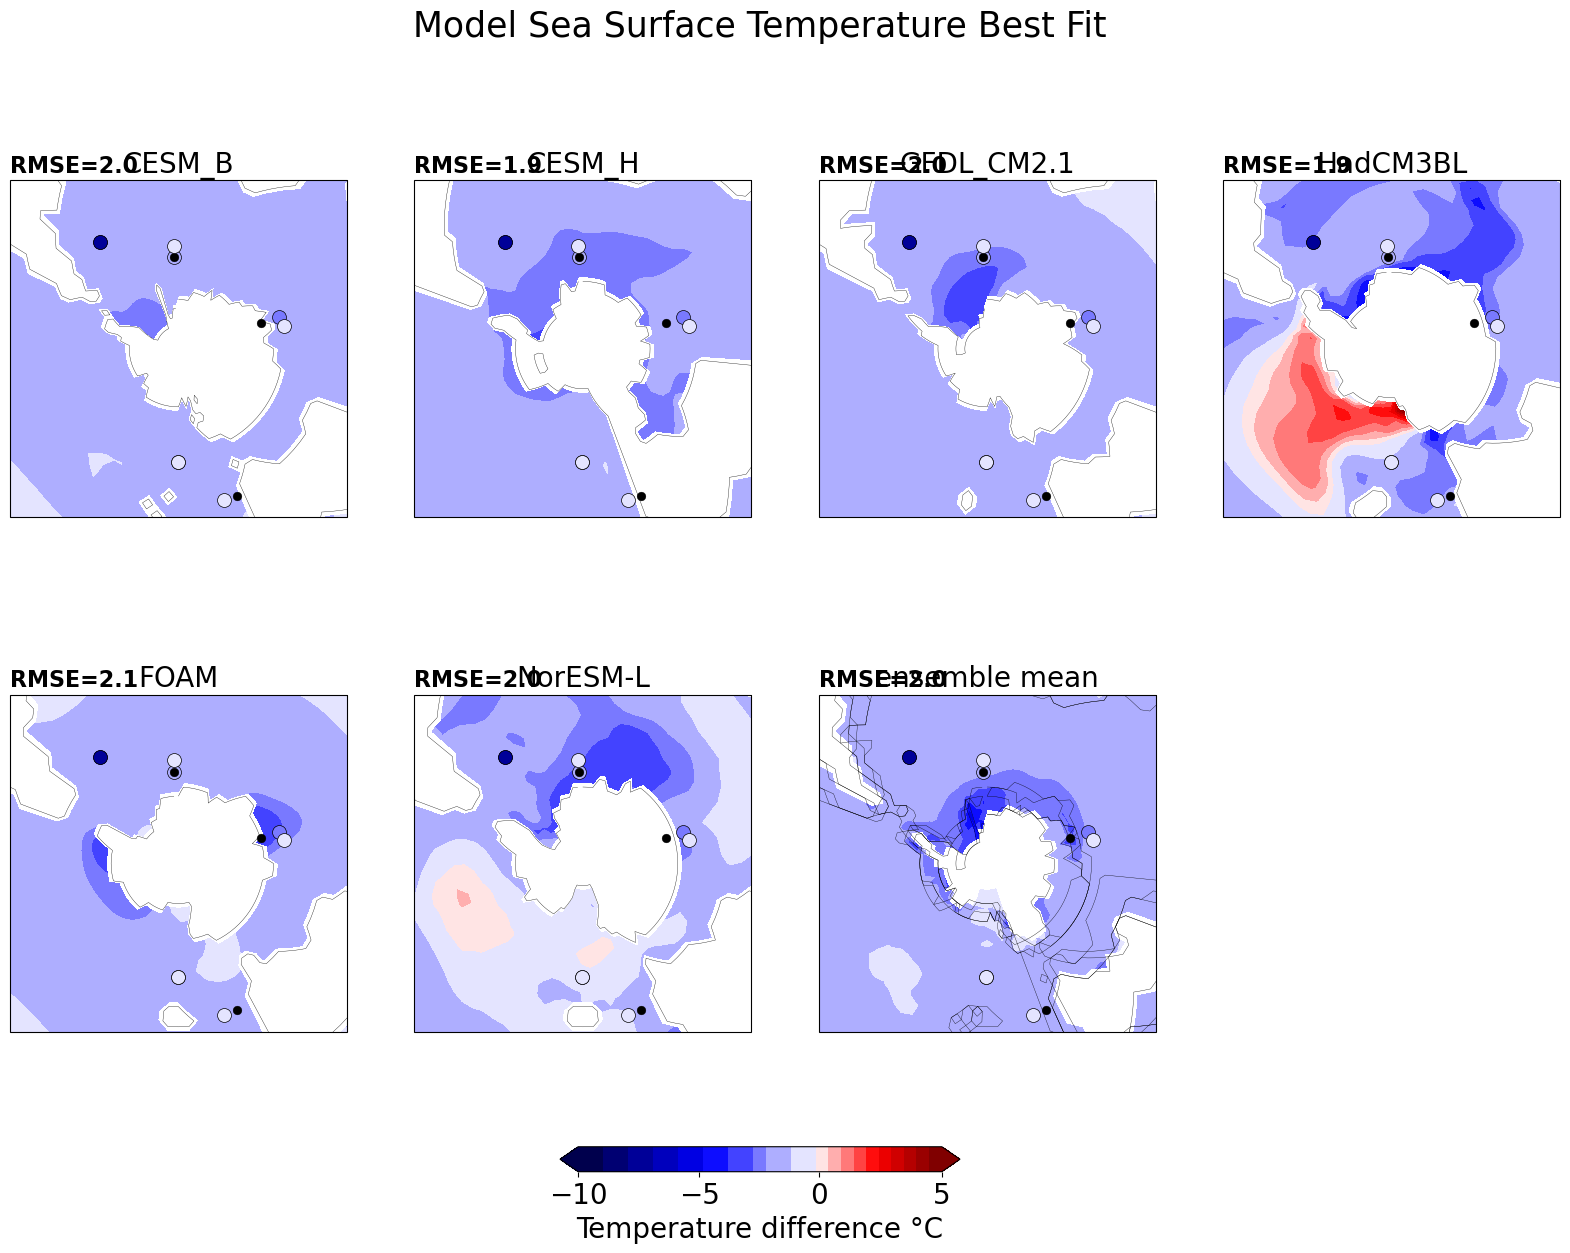

In [72]:
#SST
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelscale_SST)):
    var = diff_modelscale_SST[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelscale_SST.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffbestSST[j]),fontweight='bold', fontsize=16,loc='left')
    for i in range(0,len(proxy_SST)):
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SST['Paleolongitude'][i],proxy_SST['Paleolatitude'][i],c='black',s=40,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
        cf=ax.scatter(proxy_SST['New paleolon'][i],proxy_SST['New paleolat'][i],c=proxy_SST['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature Best Fit',fontsize=25)
plt.savefig('SST_CO2bestfit_proxymodel.pdf')

In [ ]:
#SAT
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelscale_SAT)):
    var = diff_modelscale_SAT[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelscale_SAT.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_bestSAT[j]),fontweight='bold', fontsize=16,loc='left')
    #for i in range(0,len(proxy_SST)):
    datlist=[0,1,2,3,4,5]
    for h in (datlist):
        circ,lon= add_cyclic_point(circles_SATbest[h,j],coord=diff_modelscale_SAT[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SAT['Paleolongitude'][h],proxy_SAT['Paleolatitude'][h],c=proxy_SAT['EOT diff'][h],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
        
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature Best Fit',fontsize=25)
plt.savefig('SAT_CO2bestfit_proxymodelt.pdf')

25% reduction in CO2 from models

In [73]:
#pull out 25% runs
#for SAT this is testarray 21
diff25_SAT=testarray[21]*diff_modelconc
diff25_SST=testarray[21]*diff_modelconc_SST

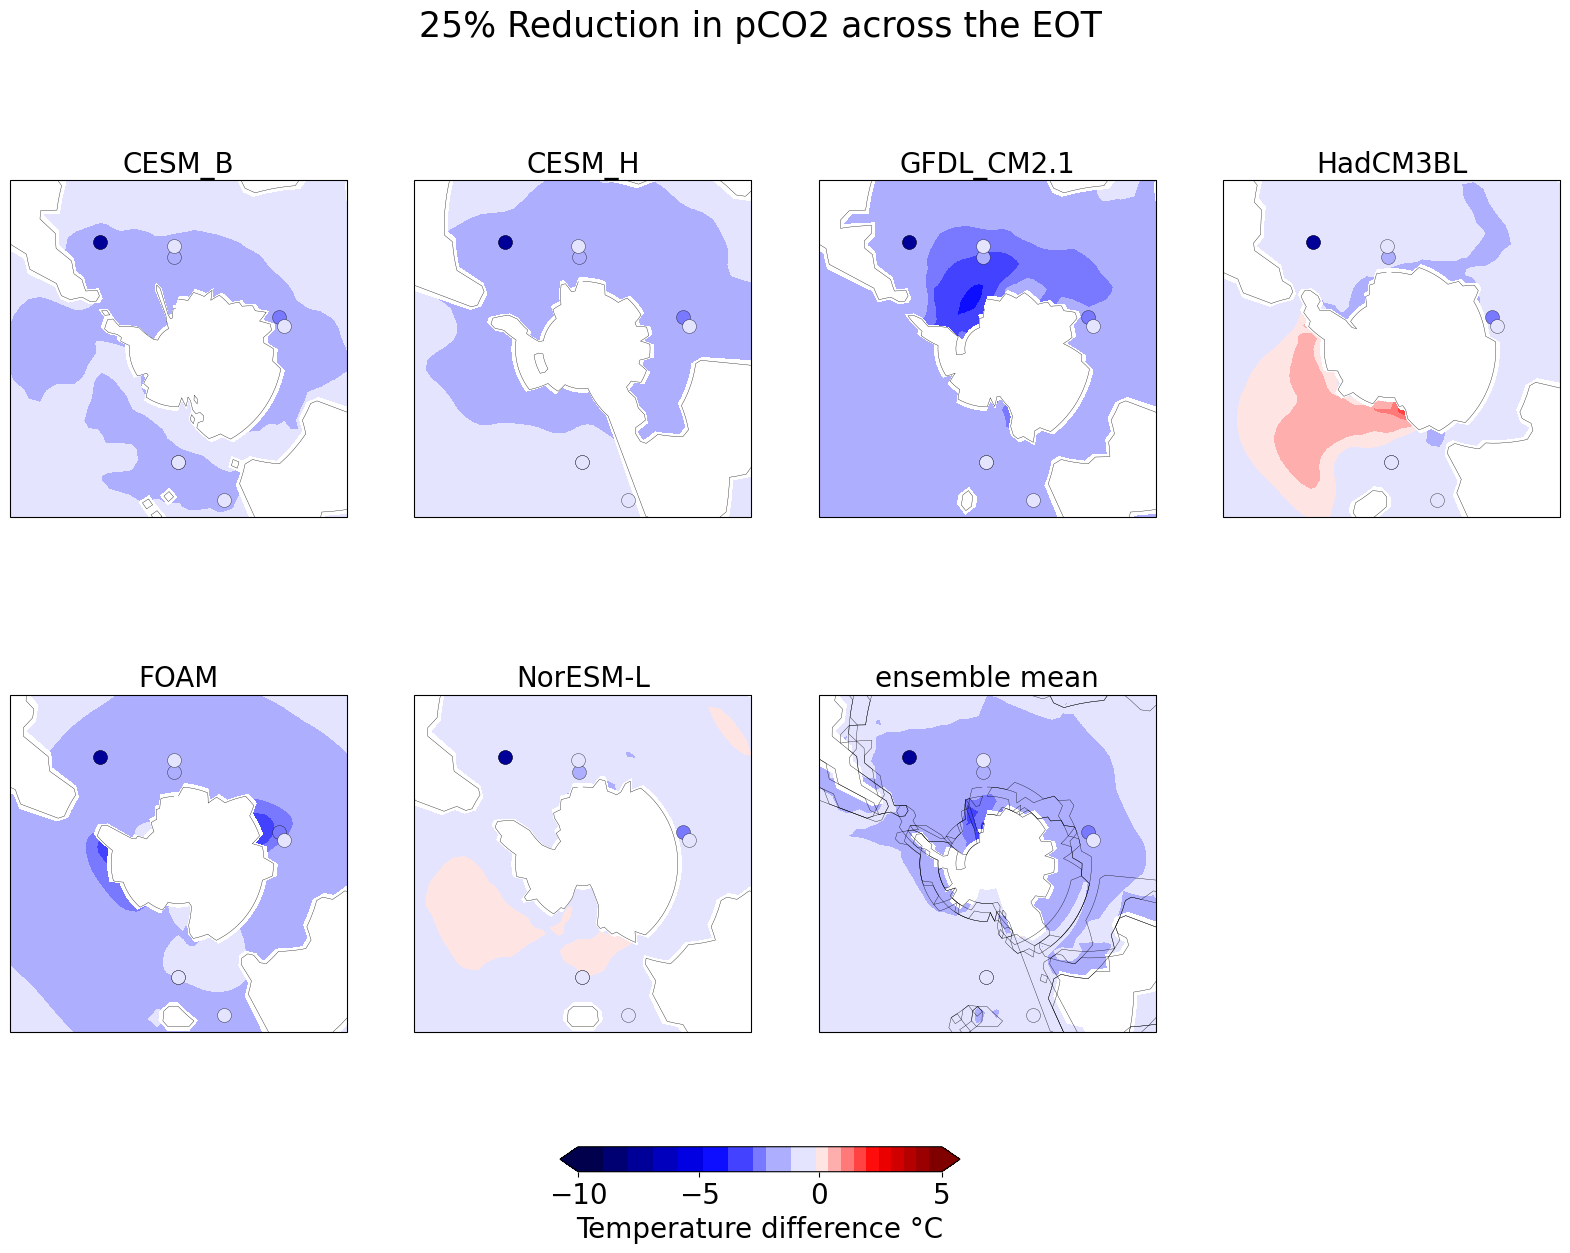

In [74]:
#25% reduction SST
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff25_SST)):
    var = diff25_SST[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff25_SST.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    #ax.set_title('RMSE='+str(rms[j]),fontweight='bold', fontsize=16,loc='left')
    for i in range(0,len(proxy_SST)):
#Add in proxy datapoints and new point locations
        cf=ax.scatter(proxy_SST['New paleolon'][i],proxy_SST['New paleolat'][i],c=proxy_SST['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('25% Reduction in pCO2 across the EOT',fontsize=25)
plt.savefig('SST_CO225_proxymodel.pdf')

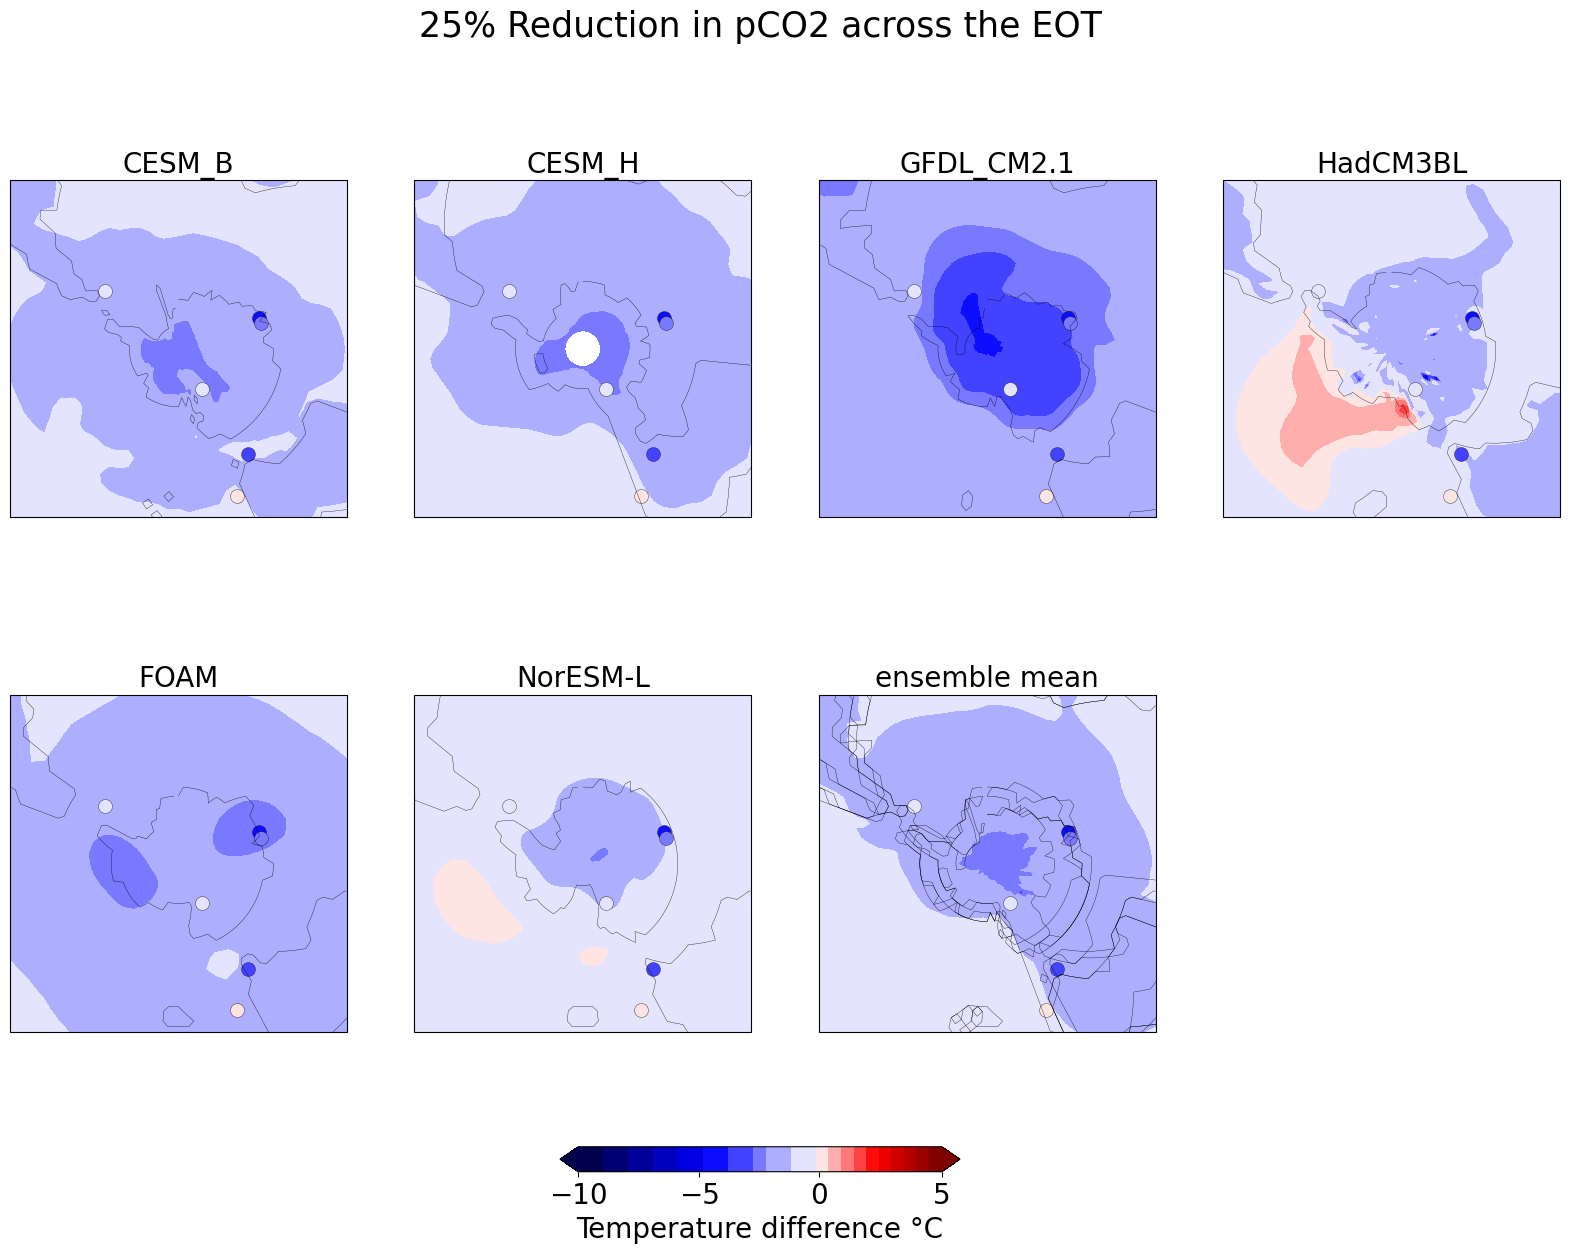

In [75]:
#25% reduction SAT
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff25_SAT)):
    var = diff25_SAT[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff25_SAT.longitude)

# Make a filled contour plot
    
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    #ax.set_title('RMSE='+str(rms[j]),fontweight='bold', fontsize=16,loc='left')
    for i in range(0,len(proxy_SAT)):
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SAT['Paleolongitude'][i],proxy_SAT['Paleolatitude'][i],c=proxy_SAT['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
        #cf=ax.scatter(SAT_proxy['New paleolon'][j][datlist][h],SAT_proxy['New paleolat'][j][datlist][h],c='black',s=60,cmap=cmap,norm=norm,edgecolor='black',transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('25% Reduction in pCO2 across the EOT',fontsize=25)
plt.savefig('SAT_CO225_proxymodel.pdf')

Ice comparison

In [76]:
#isolating only ice runs
iceruns_SAT=np.where(run_infoice_SAT=='ice')
icels_SAT=np.array(iceruns_SAT)
ice_SAT=SAT_C_updated[icels_SAT[0,:],:,:]

model_ice=modelnames[icels_SAT[0,:]]
iceruns_SST=np.where(run_infoice_SST=='ice')
icels_SST=np.array(iceruns_SST)
ice_SST=SST_updated[icels_SST[0,:],:,:]
landmask_ice=np.isnan(ice_SST)

#isolating only no ice runs

noiceruns_SAT=np.where(run_infoice_SAT=='No ice')
noicels_SAT=np.array(noiceruns_SAT)
noice_SAT=SAT_C_updated[noicels_SAT[0,:],:,:]

model_noice=modelnames[noicels_SAT[0,:]]

noiceruns_SST=np.where(run_infoice_SST=='No ice')
noicels_SST=np.array(noiceruns_SST)
noice_SST=SST_updated[noicels_SST[0,:],:,:]

landmask_noice=np.isnan(noice_SST)

diff_ice=ice_SAT-noice_SAT

diff_ice_SST=ice_SST-noice_SST


In [77]:
#model ensemble mean

ensemblemean_ice=np.mean(diff_ice, axis=0)
ensemblemean_iceSST=np.mean(diff_ice_SST,axis=0)
diff_modelice=xr.concat([diff_ice,ensemblemean_ice],'exp')
diff_modelice_SST=xr.concat([diff_ice_SST,ensemblemean_iceSST],'exp')

#Eocene mean
ensembleice_eo_SST=np.mean(noice_SST, axis=0)
SSTice_EO=xr.concat([noice_SST,ensembleice_eo_SST],'exp')
ensembleice_eo_SAT=np.mean(noice_SAT, axis=0)
SATice_EO=xr.concat([noice_SAT,ensembleice_eo_SAT],'exp')

#Oligocene mean
ensembleice_oligo=np.mean(ice_SAT, axis=0)
SATice_Oligo=xr.concat([ice_SAT,ensembleice_oligo],'exp')
ensembleice_oligo_SST=np.mean(ice_SST, axis=0)
SSTice_Oligo=xr.concat([ice_SST,ensembleice_oligo_SST],'exp')

In [78]:
Eoceneice_SAT=Eocene_proxy_SAT1.expand_dims(dim='nmodels')
Eoceneice_SAT=xr.concat([Eoceneice_SAT,Eocene_proxy_SAT3],'nmodels')
Eoceneice_SAT=xr.concat([Eoceneice_SAT,Eocene_proxy_SAT4],'nmodels')
Eoceneice_SAT=xr.concat([Eoceneice_SAT,Eocene_proxy_SAT6],'nmodels')

In [79]:
Oligo_ice_SAT=Oligo_proxy_SAT1.expand_dims(dim='nmodels')
Oligo_ice_SAT=xr.concat([Oligo_ice_SAT,Oligo_proxy_SAT3],'nmodels')
Oligo_ice_SAT=xr.concat([Oligo_ice_SAT,Oligo_proxy_SAT4],'nmodels')
Oligo_ice_SAT=xr.concat([Oligo_ice_SAT,Oligo_proxy_SAT6],'nmodels')

In [80]:
SATice_proxy=proxy_SAT_1.expand_dims(dim='nmodels')
SATice_proxy=xr.concat([SATice_proxy,proxy_SAT_3],'nmodels')
SATice_proxy=xr.concat([SATice_proxy,proxy_SAT_4],'nmodels')
SATice_proxy=xr.concat([SATice_proxy,proxy_SAT_6],'nmodels')

Eocene

In [81]:
#ice SAT source area calculations
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
lats=range(0,73)
lons=range(0,96)
lat=SATice_EO.latitude
lon=SATice_EO.longitude
circlesice_Eocene=np.empty([13,4,73,96])
circlesice_Eocene=xr.DataArray(circlesice_Eocene,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATice_EO)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Eoceneice_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Eoceneice_SAT['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==1 or i==9:
            if j==0:
                masklon = abs(SATice_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATice_EO[j].latitude[lats]-originlat)<7.5
                arr[masklat & masklon] = 1
            if j==1 or j==2 or j==3:
                masklon = abs(SATice_EO[j].longitude[lons]- originlon)<15
                masklat = abs(SATice_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2 or i==7:#-63.85,-53.91,2,7
            if j==0:
                masklon = (SATice_EO[j].longitude[lons]- originlon)<15
                masklonl= (SATice_EO[j].longitude[lons]- originlon)>-30
                masklat = (SATice_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATice_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==1 or j==2 or j==3:
                masklon = (SATice_EO[j].longitude[lons]- originlon)<17
                masklonl= (SATice_EO[j].longitude[lons]- originlon)>-40
                masklat = (SATice_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATice_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3 or i==12: 
            masklon = abs(SATice_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATice_EO[j].latitude[lats]-originlat)<4
            arr[masklat & masklon] = 1
        if i==4 or i==5 or i==6 or i==8 or i==10 or i==11:
            masklon = abs(SATice_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATice_EO[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        arr = np.where(SATice_EO[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circlesice_Eocene[i,j,:,:]=arr; del arr 

In [82]:
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
prox=np.empty((13))
array=np.empty((13,4,73,96))
Eocene_iceSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATice_EO)):
    for i in range(len(datlist)):
        Eocene_temp= SATice_EO[ex][:,:]
        Eocene_iceSAT[i,ex,:,:]=np.where(circlesice_Eocene[i,ex,:,:]==1, Eocene_temp, np.nan)
        prox[i] = Eocene_proxy_SAT['Eocene SAT'][datlist][i]
        

Eocene_iceSAT['latitude']=SATice_EO.latitude
Eocene_iceSAT['longitude']=SATice_EO.longitude 

weights=np.cos(np.deg2rad(SATice_EO.latitude))
SATice_weighted=Eocene_iceSAT.weighted(weights)
EOice_weighted_SAT = SATice_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((13,4))
rms_Eoceneice=np.empty((4))
for ex in range(0,len(SATice_EO)):
    errors[:,ex]=(EOice_weighted_SAT[:,ex]-prox[:])
    rms_Eoceneice[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1)
rms_Eoceneice


array([ 8.6, 10.6, 11. , 10.3])

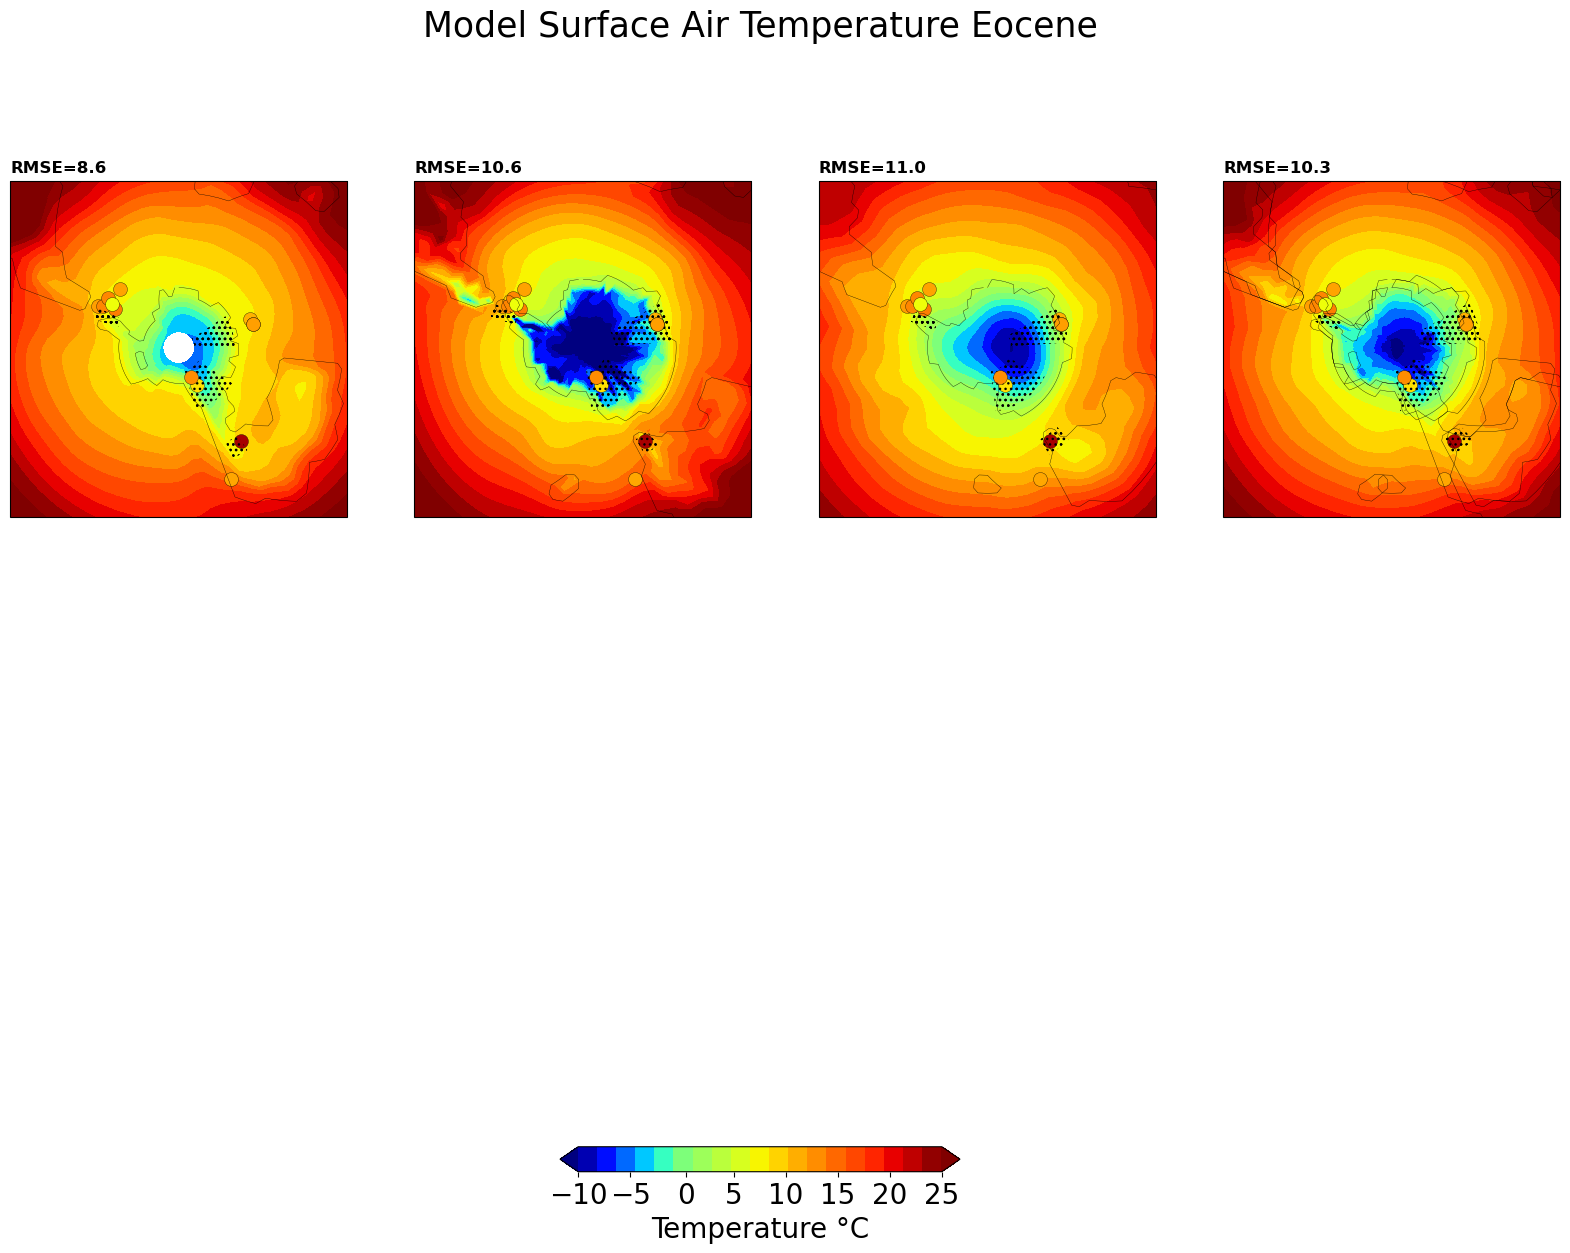

In [83]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATice_EO)):
    var = SATice_EO[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATice_EO.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    if j==3:
        for k in range(0,3):
            coast_all=landmask_noice[k,:,:]*1
            ax.contour(landmask_noice.longitude,landmask_noice.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title('ensemble mean',fontweight='bold', fontsize=16,loc='left')
    else:
        coast=landmask_noice[j,:,:]*1
        ax.contour(landmask_noice.longitude,landmask_noice.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_ice[j],fontweight='bold', fontsize=16,loc='left')
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    
    ax.set_title('RMSE='+str(rms_Eoceneice[j]),fontweight='bold', fontsize=12,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circlesice_Eocene[h,j],coord=SATice_EO[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(Eocene_proxy_SAT['Paleolongitude'][h],Eocene_proxy_SAT['Paleolatitude'][h],c=Eocene_proxy_SAT['Eocene SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
      
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature Eocene',fontsize=25)
plt.savefig('SAT_iceEocene_proxymodel.pdf')

Oligocene

In [86]:
Oligo_SATice=Oligo_proxy_SAT1.expand_dims(dim='nmodels')
Oligo_SATice=xr.concat([Oligo_SATice,Oligo_proxy_SAT3],'nmodels')
Oligo_SATice=xr.concat([Oligo_SATice,Oligo_proxy_SAT4],'nmodels')
Oligo_SATice=xr.concat([Oligo_SATice,Oligo_proxy_SAT6],'nmodels')

In [87]:
#ice SAT Oligocene source area
datlist=list([0,1,2,3,4,5,6,7])
lats=range(0,73)
lons=range(0,96)
lat=SATice_Oligo.latitude
lon=SATice_Oligo.longitude
circlesice_Oligo=np.empty([8,4,73,96])
circlesice_Oligo=xr.DataArray(circlesice_Oligo,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATice_Oligo)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Oligo_SATice['New paleolat'][j][datlist][i] #circle center lat
        originlon=Oligo_SATice['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==1: #same cores different proxies
            if j==0:
                masklon = abs(SATice_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATice_Oligo[j].latitude[lats]-originlat)<7
                arr[masklat & masklon] = 1
            if j==1 or j==2 or j==3:
                masklon = abs(SATice_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATice_Oligo[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2 or i==5:
            if j==0:
                masklon = (SATice_Oligo[j].longitude[lons]- originlon)<15
                masklonl= (SATice_Oligo[j].longitude[lons]- originlon)>-40
                masklat = (SATice_Oligo[j].latitude[lats]-originlat)<6
                masklatl = (SATice_Oligo[j].latitude[lats]-originlat)>-8
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==1 or j==2 or j==3:
                masklon = (SATice_Oligo[j].longitude[lons]- originlon)<17
                masklonl= (SATice_Oligo[j].longitude[lons]- originlon)>-40
                masklat = (SATice_Oligo[j].latitude[lats]-originlat)<8
                masklatl = (SATice_Oligo[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3:
                masklon = abs(SATice_Oligo[j].longitude[lons]- originlon)<10
                masklat = abs(SATice_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
                arr[masklat & masklon] = 1
        if i==4:
            if j==1 or j==2 or j==3:
                masklon = abs(SATice_Oligo[j].longitude[lons]- originlon)<5.5
                masklat = abs(SATice_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==0:
                masklon = abs(SATice_Oligo[j].longitude[lons]- originlon)<7
                masklat = abs(SATice_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        if i==6:
                masklon = abs(SATice_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATice_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        if i==7:
                masklon = abs(SATice_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATice_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        arr = np.where(SATice_Oligo[j][lats,lons]!='nan',arr,0) 
        arr = np.where(arr==0,np.nan,1)
        circlesice_Oligo[i,j,:,:]=arr; del arr 

In [88]:
datlist=list([0,1,2,3,4,5,6,7])
prox=np.empty((8))
array=np.empty((8,4,73,96))
Oligo_iceSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATice_Oligo)):
    for i in range(len(datlist)):
        Oligo_temp= SATice_Oligo[ex][:,:]
        Oligo_iceSAT[i,ex,:,:]=np.where(circlesice_Oligo[i,ex,:,:]==1, Oligo_temp, np.nan)
        prox[i] = Oligo_proxy_SAT['Oligo SAT'][datlist][i]
        

Oligo_iceSAT['latitude']=SATice_Oligo.latitude
Oligo_iceSAT['longitude']=SATice_Oligo.longitude 

weights=np.cos(np.deg2rad(SATice_Oligo.latitude))
SATice_weighted=Oligo_iceSAT.weighted(weights)
Oligoice_weighted_SAT = SATice_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((8,4))
rms_Oligoice=np.empty((4))
for ex in range(0,len(SATice_Oligo)):
    errors[:,ex]=(Oligoice_weighted_SAT[:,ex]-prox[:])
    rms_Oligoice[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1)
rms_Oligoice

array([24.7, 20.8, 21.4, 18.3])

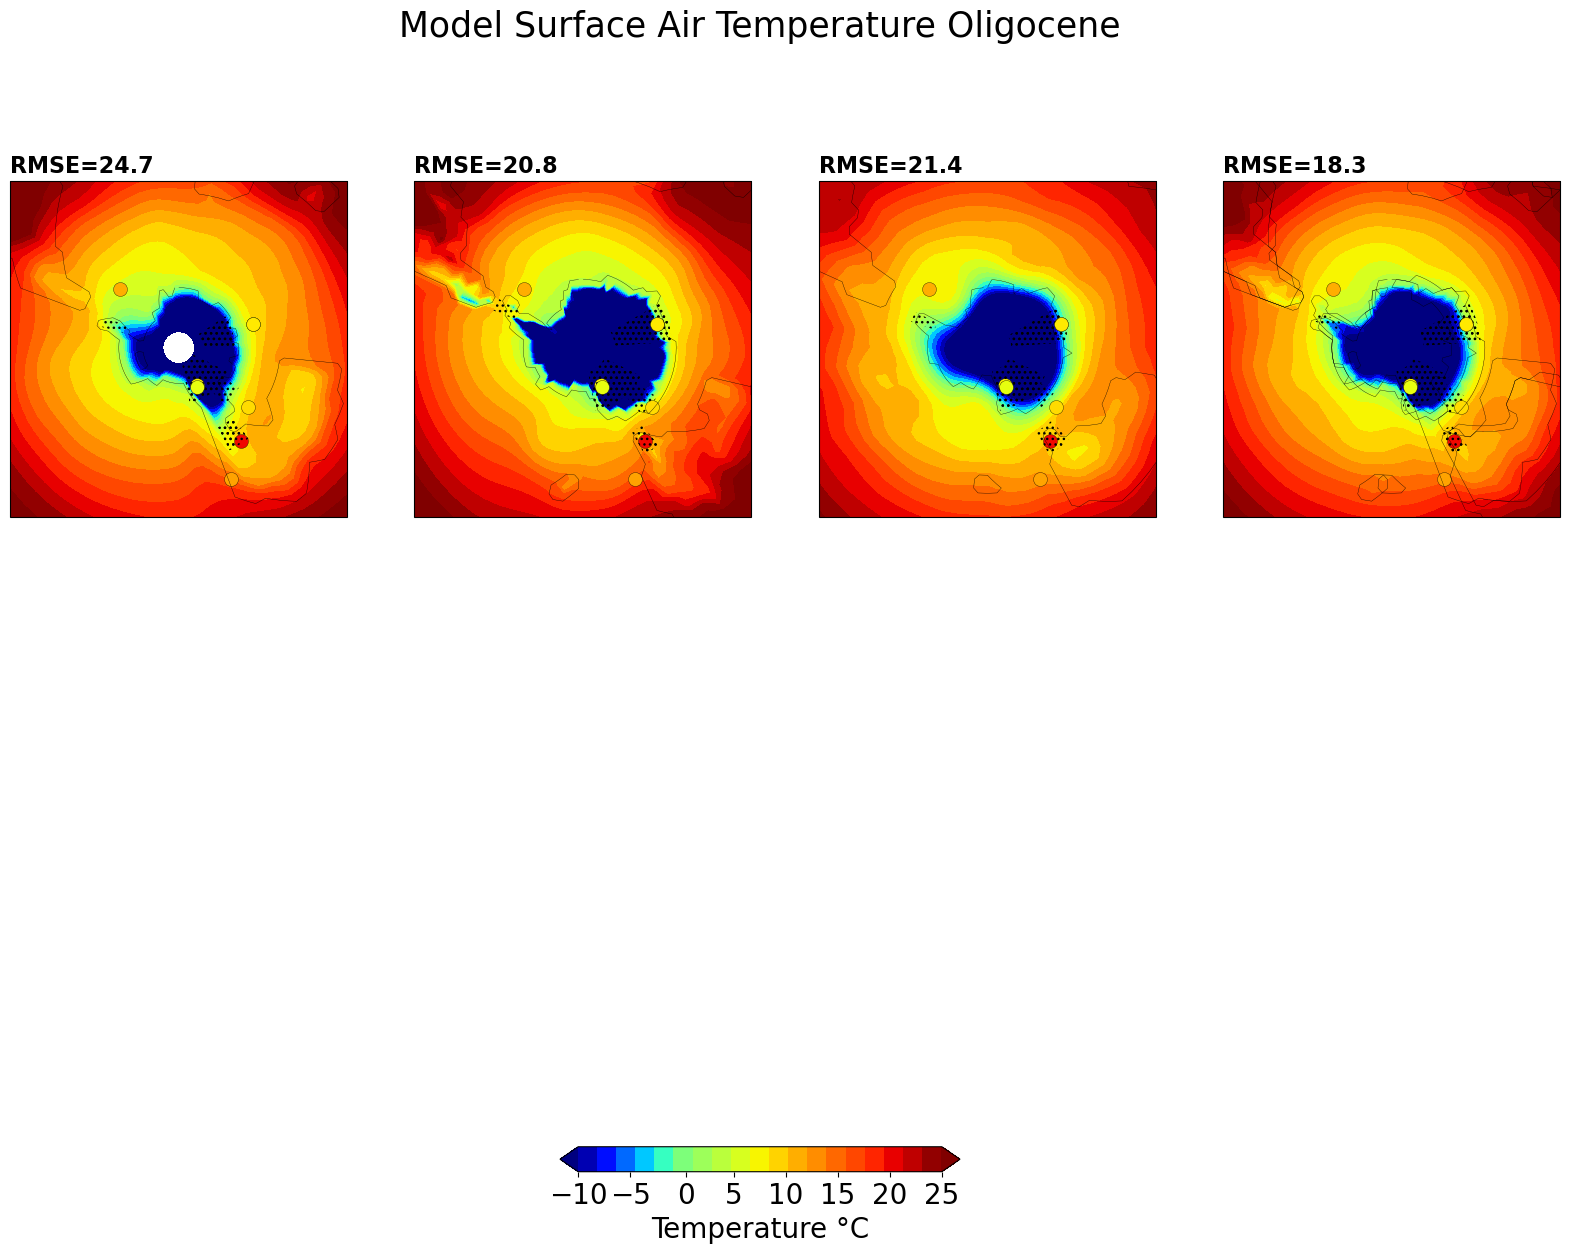

In [89]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATice_Oligo)):
    var = SATice_Oligo[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATice_Oligo.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    if j==3:
        for k in range(0,3):
            coast_all=landmask_ice[k,:,:]*1
            ax.contour(landmask_ice.longitude,landmask_ice.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_ice[j,:,:]*1
        ax.contour(landmask_ice.longitude,landmask_ice.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        
    #ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_Oligoice[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circlesice_Oligo[h,j],coord=SATice_Oligo[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(Oligo_proxy_SAT['Paleolongitude'][h],Oligo_proxy_SAT['Paleolatitude'][h],c=Oligo_proxy_SAT['Oligo SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
       
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature Oligocene',fontsize=25)
plt.savefig('SAT_iceOligocene_proxymodel.pdf')

EOT difference

In [90]:
SAT_proxyice=proxy_SAT_1.expand_dims(dim='nmodels')
SAT_proxyice=xr.concat([SAT_proxyice,proxy_SAT_3],'nmodels')
SAT_proxyice=xr.concat([SAT_proxyice,proxy_SAT_4],'nmodels')
SAT_proxyice=xr.concat([SAT_proxyice,proxy_SAT_6],'nmodels')

In [91]:
datlist=list([0,1,2,3,4,5])
lats=range(0,73)
lons=range(0,96)
circles=[] #
lat=diff_modelice.latitude
lon=diff_modelice.longitude
circlesice_diff=np.empty([6,4,73,96])
circlesice_diff=xr.DataArray(circlesice_diff,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(diff_modelice)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=SAT_proxyice['New paleolat'][j][datlist][i] #circle center lat
        originlon=SAT_proxyice['New paleolon'][j][datlist][i]
 
        if i==0 or i==1: #same cores different proxies
            if j==0:
                masklon = abs(diff_modelice[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelice[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==1 or j==2 or j==3:
                masklon = abs(diff_modelice[j].longitude[lons]- originlon)<15
                masklat = abs(diff_modelice[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2:
            masklon = (diff_modelice[j].longitude[lons]- originlon)<17
            masklonl= (diff_modelice[j].longitude[lons]- originlon)>-40
            masklat = (diff_modelice[j].latitude[lats]-originlat)<8
            masklatl = (diff_modelice[j].latitude[lats]-originlat)>-6
            arr[masklat & masklatl & masklon & masklonl] = 1
        if i==4:
            masklon = abs(diff_modelice[j].longitude[lons]- originlon)<6
            masklat = abs(diff_modelice[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        if i==3 or i==5:
            if j==1 or j==2 or j==3:
                masklon = abs(diff_modelice[j].longitude[lons]- originlon)<5.5
                masklat = abs(diff_modelice[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==0:
                masklon = abs(diff_modelice[j].longitude[lons]- originlon)<7
                masklat = abs(diff_modelice[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        arr = np.where(diff_modelice[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circlesice_diff[i,j,:,:]=arr; del arr 

In [92]:
datlist=list([0,1,2,3,4,5])
prox=np.empty((6))
array=np.empty((6,4,73,96))
diff_iceSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(diff_modelice)):
    for i in range(len(datlist)):
        diff_temp= diff_modelice[ex][:,:]
        diff_iceSAT[i,ex,:,:]=np.where(circlesice_diff[i,ex,:,:]==1, diff_temp, np.nan)
        prox[i] = proxy_SAT['EOT diff'][datlist][i]
        

diff_iceSAT['latitude']=diff_modelice.latitude
diff_iceSAT['longitude']=diff_modelice.longitude 

weights=np.cos(np.deg2rad(diff_modelice.latitude))
SATice_weighted=diff_iceSAT.weighted(weights)
ice_weighted_SAT = SATice_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((6,4))
rms_diffice=np.empty((4))
for ex in range(0,len(diff_modelice)):
    errors[:,ex]=(ice_weighted_SAT[:,ex]-prox[:])
    rms_diffice[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1)
rms_diffice


array([14.1,  9.4, 11.5,  9.4])

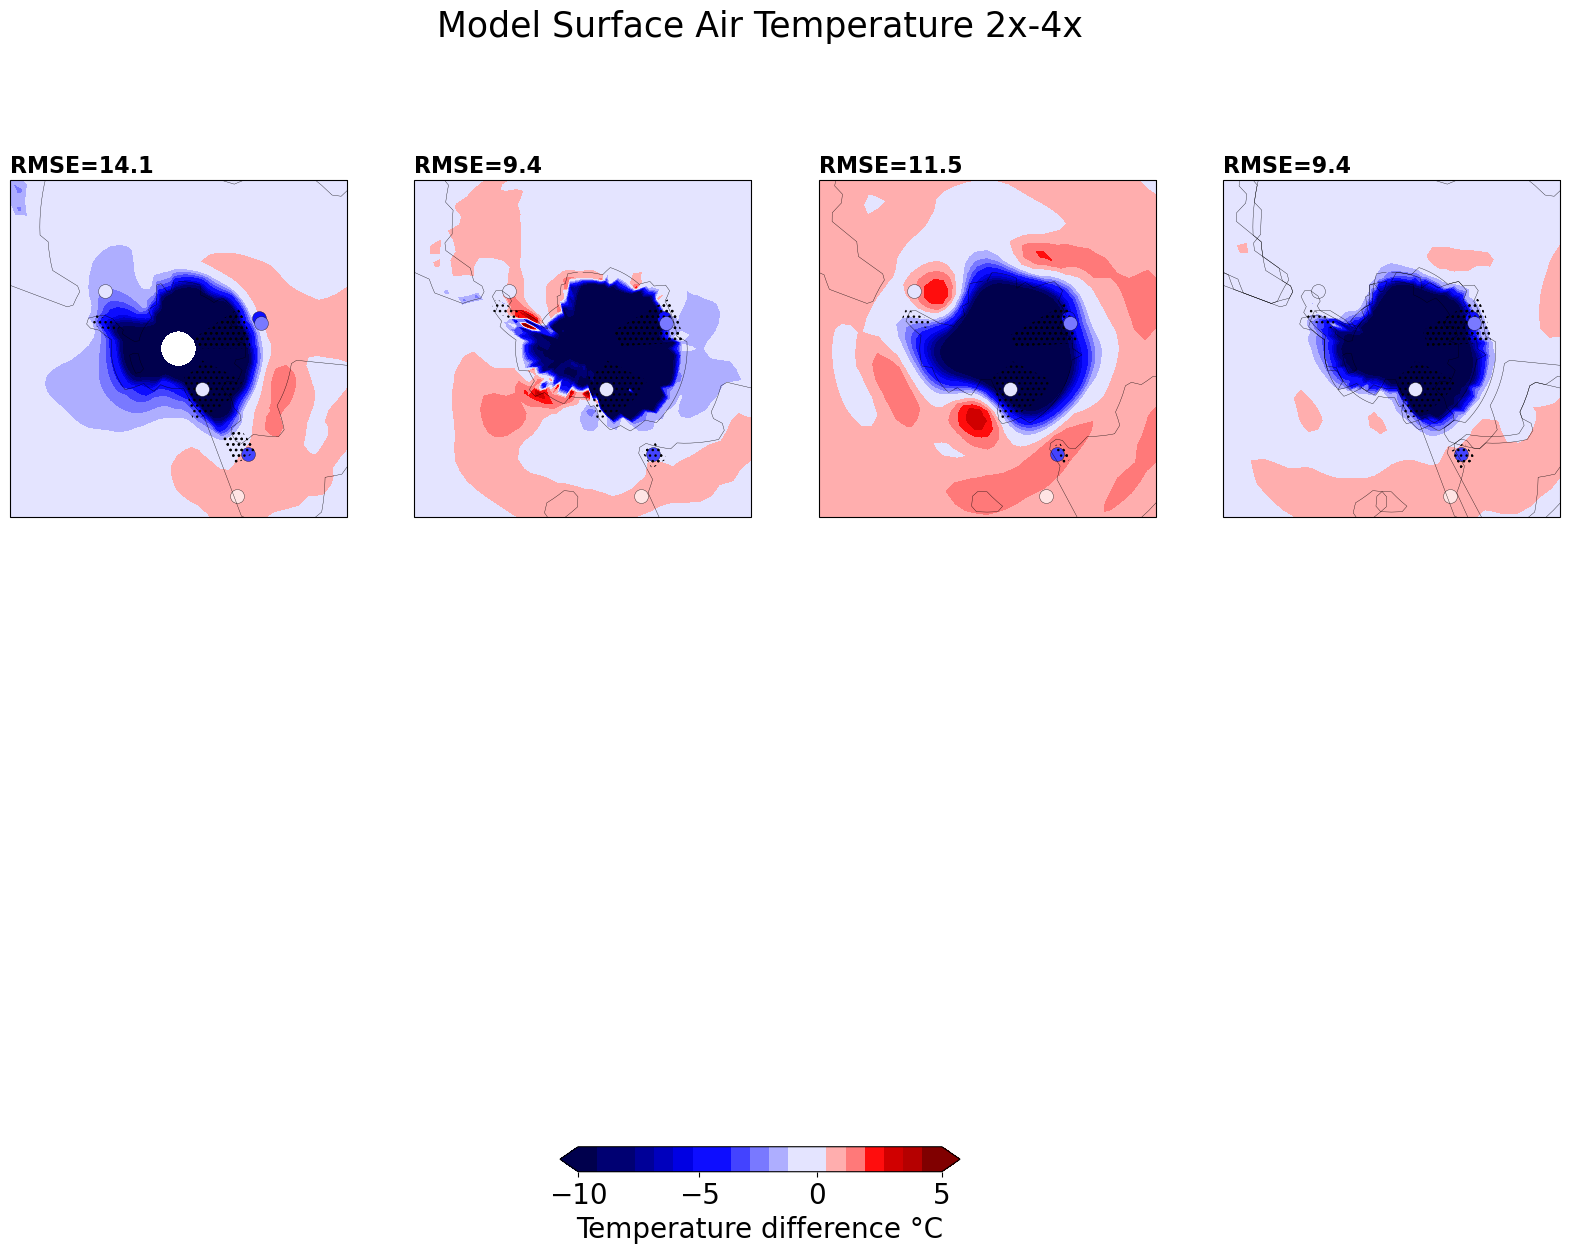

In [93]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelice)):
    var = diff_modelice[j][lats,lons]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelice[j].longitude)

# Make a filled contour plot
    datlist=[0,1,2,3,4,5]
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,20),extend='both')
    if j==3:
        for k in range(0,3):
            coast_all=landmask_ice[k,:,:]*1
            ax.contour(landmask_ice.longitude,landmask_ice.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_ice[j,:,:]*1
        ax.contour(landmask_ice.longitude,landmask_ice.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffice[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circlesice_diff[h,j],coord=diff_modelice[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SAT['Paleolongitude'][h],proxy_SAT['Paleolatitude'][h],c=proxy_SAT['EOT diff'][h],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
       
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature 2x-4x',fontsize=25)
plt.savefig('SAT_tempdiffice_proxymodel.pdf')

Sea Surface Temperature ice models

In [94]:
#Eocene
prox=np.empty((11))
Eocenemodel_SST=np.empty((11,4))
for i in range(0,len(Eocene_proxy_SST)):
    for j in range (0,len(SSTice_EO)):
        Eocenemodel_SST[i,j]=(SSTice_EO[j].sel(latitude=Eocene_proxy_SST['New paleolat'][i],longitude=Eocene_proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = Eocene_proxy_SST['Eocene SST'][i]

        errors=np.empty((11,4))
rms_EOSST_ice=np.empty((4))
for ex in range(0,len(SSTice_EO)):
    errors[:,ex]=(Eocenemodel_SST[:,ex]-prox[:])
    rms_EOSST_ice[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(Eocene_proxy_SST)).round(decimals=1) 
rms_EOSST_ice

array([7.9, 8.1, 9.3, 8.4])

In [95]:
#Oligocene
Oligomodel_SST=np.empty((10,4))
prox=np.empty((10))
for i in range(0,len(Oligo_proxy_SST)):
    for j in range (0,len(SSTice_Oligo)):
        Oligomodel_SST[i,j]=(SSTice_Oligo[j].sel(latitude=Oligo_proxy_SST['New paleolat'][i],longitude=Oligo_proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = Oligo_proxy_SST['Oligo SST'][i]
    
errors=np.empty((10,4))
rms_OligoSST_ice=np.empty((4))
for ex in range(0,len(SSTice_Oligo)):
    errors[:,ex]=(Oligomodel_SST[:,ex]-prox[:])
    rms_OligoSST_ice[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(Oligo_proxy_SST)).round(decimals=1) 
rms_OligoSST_ice

array([7.4, 7.7, 8.3, 7.7])

In [96]:
#difference
diffmodel_SST=np.empty((9,4))
prox=np.empty((9))
for i in range(0,len(proxy_SST)):
    for j in range (0,len(diff_modelice_SST)):
        diffmodel_SST[i,j]=(diff_modelice_SST[j].sel(latitude=proxy_SST['New paleolat'][i],longitude=proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = proxy_SST['EOT diff'][i]

errors=np.empty((9,4))
rms_diffSST_ice=np.empty((4))
for ex in range(0,len(diff_modelice_SST)):
    errors[:,ex]=(diffmodel_SST[:,ex]-prox[:])
    rms_diffSST_ice[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(proxy_SST)).round(decimals=1)
rms_diffSST_ice

array([2.4, 2.7, 2.8, 2.5])

Plot SST timeslices

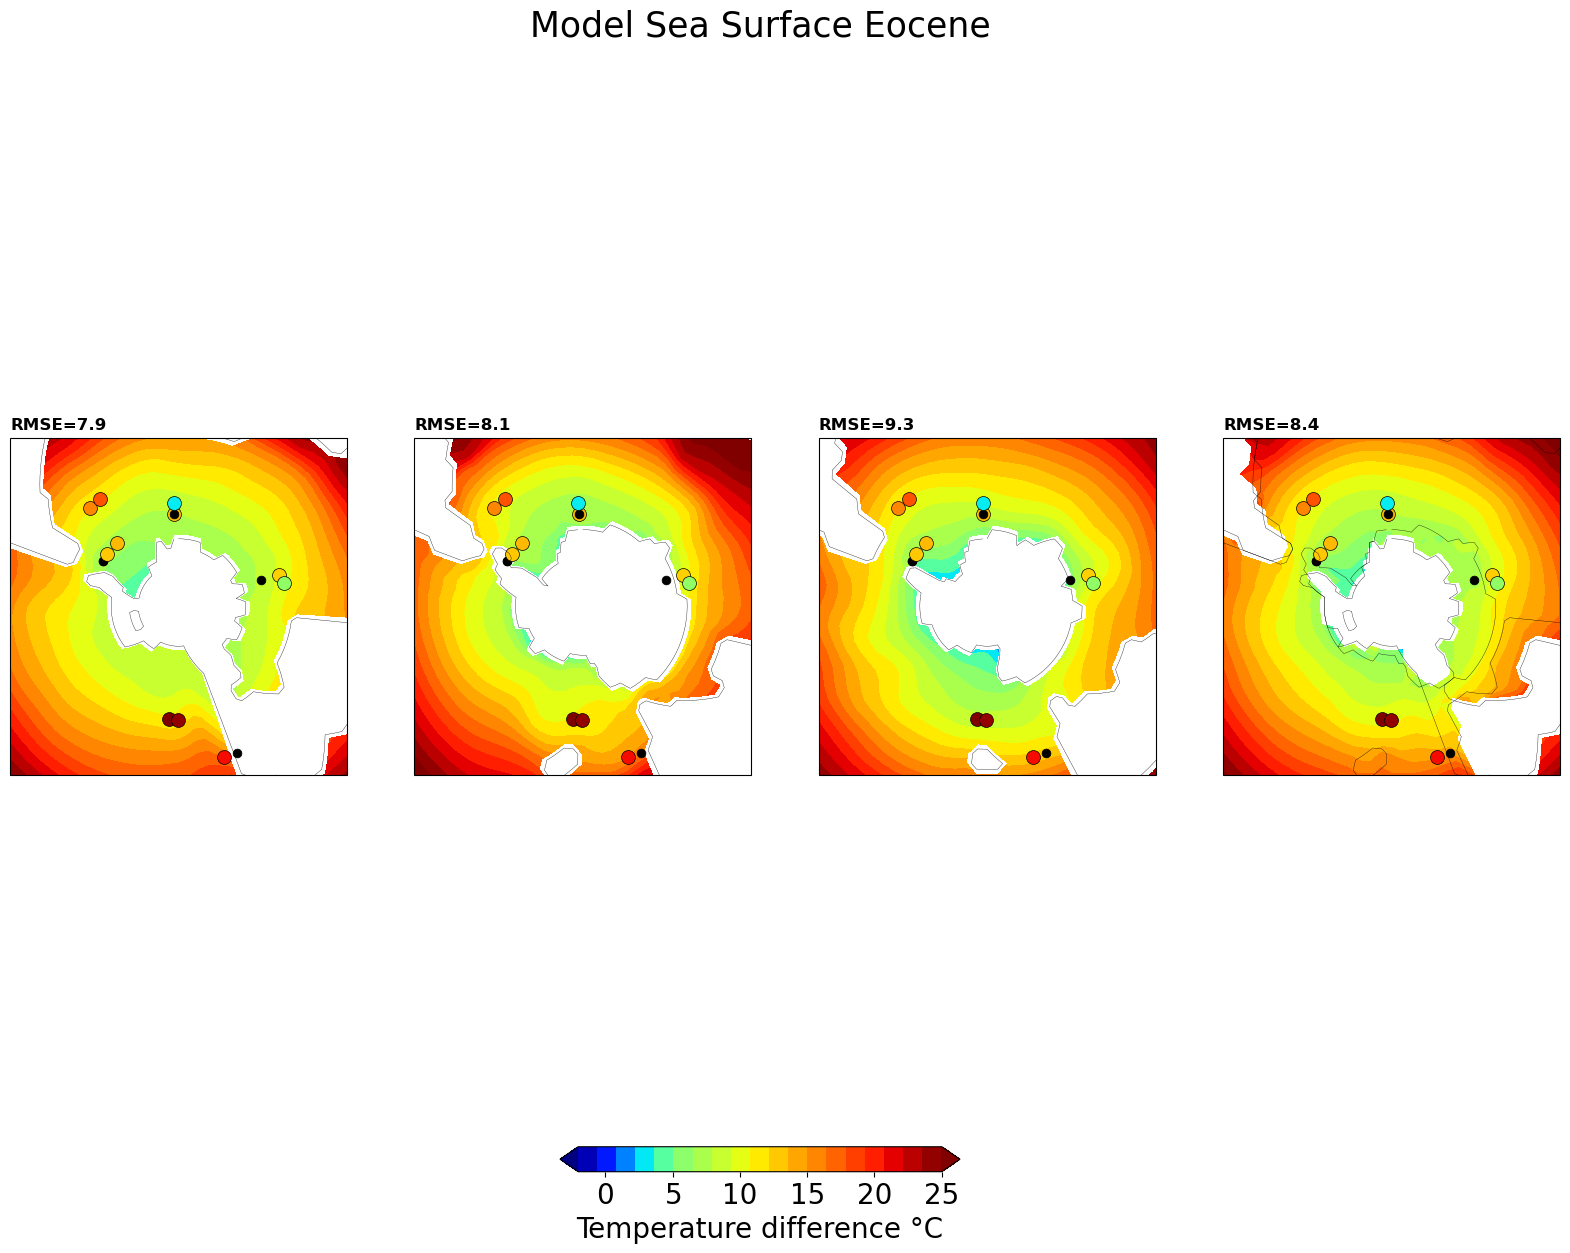

In [99]:
#Eocene ice SST
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-2,vcenter=5,vmax=25)

for j in range(0,len(SSTice_EO)):
    var = SSTice_EO[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(1, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SSTice_EO.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-2,25,20),extend='both')
    
    for i in range(0,len(Eocene_proxy_SST)):
        cd=ax.scatter(Eocene_proxy_SST['Paleolongitude'][i],Eocene_proxy_SST['Paleolatitude'][i],c='black',s=40,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree())
        cf=ax.scatter(Eocene_proxy_SST['New paleolon'][i],Eocene_proxy_SST['New paleolat'][i],c=Eocene_proxy_SST['Eocene SST'][i],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   
    if j==3:
        for k in range(0,2):
            coast_all=landmask_noice[k,:,:]*1
            ax.contour(landmask_noice.longitude,landmask_noice.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_noice[j,:,:]*1
        ax.contour(landmask_noice.longitude,landmask_noice.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_EOSST_ice[j]),fontweight='bold', fontsize=12,loc='left')

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,5,10,15,20,25])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Eocene',fontsize=25)
plt.savefig('SST_iceEocene_proxymodel.pdf')

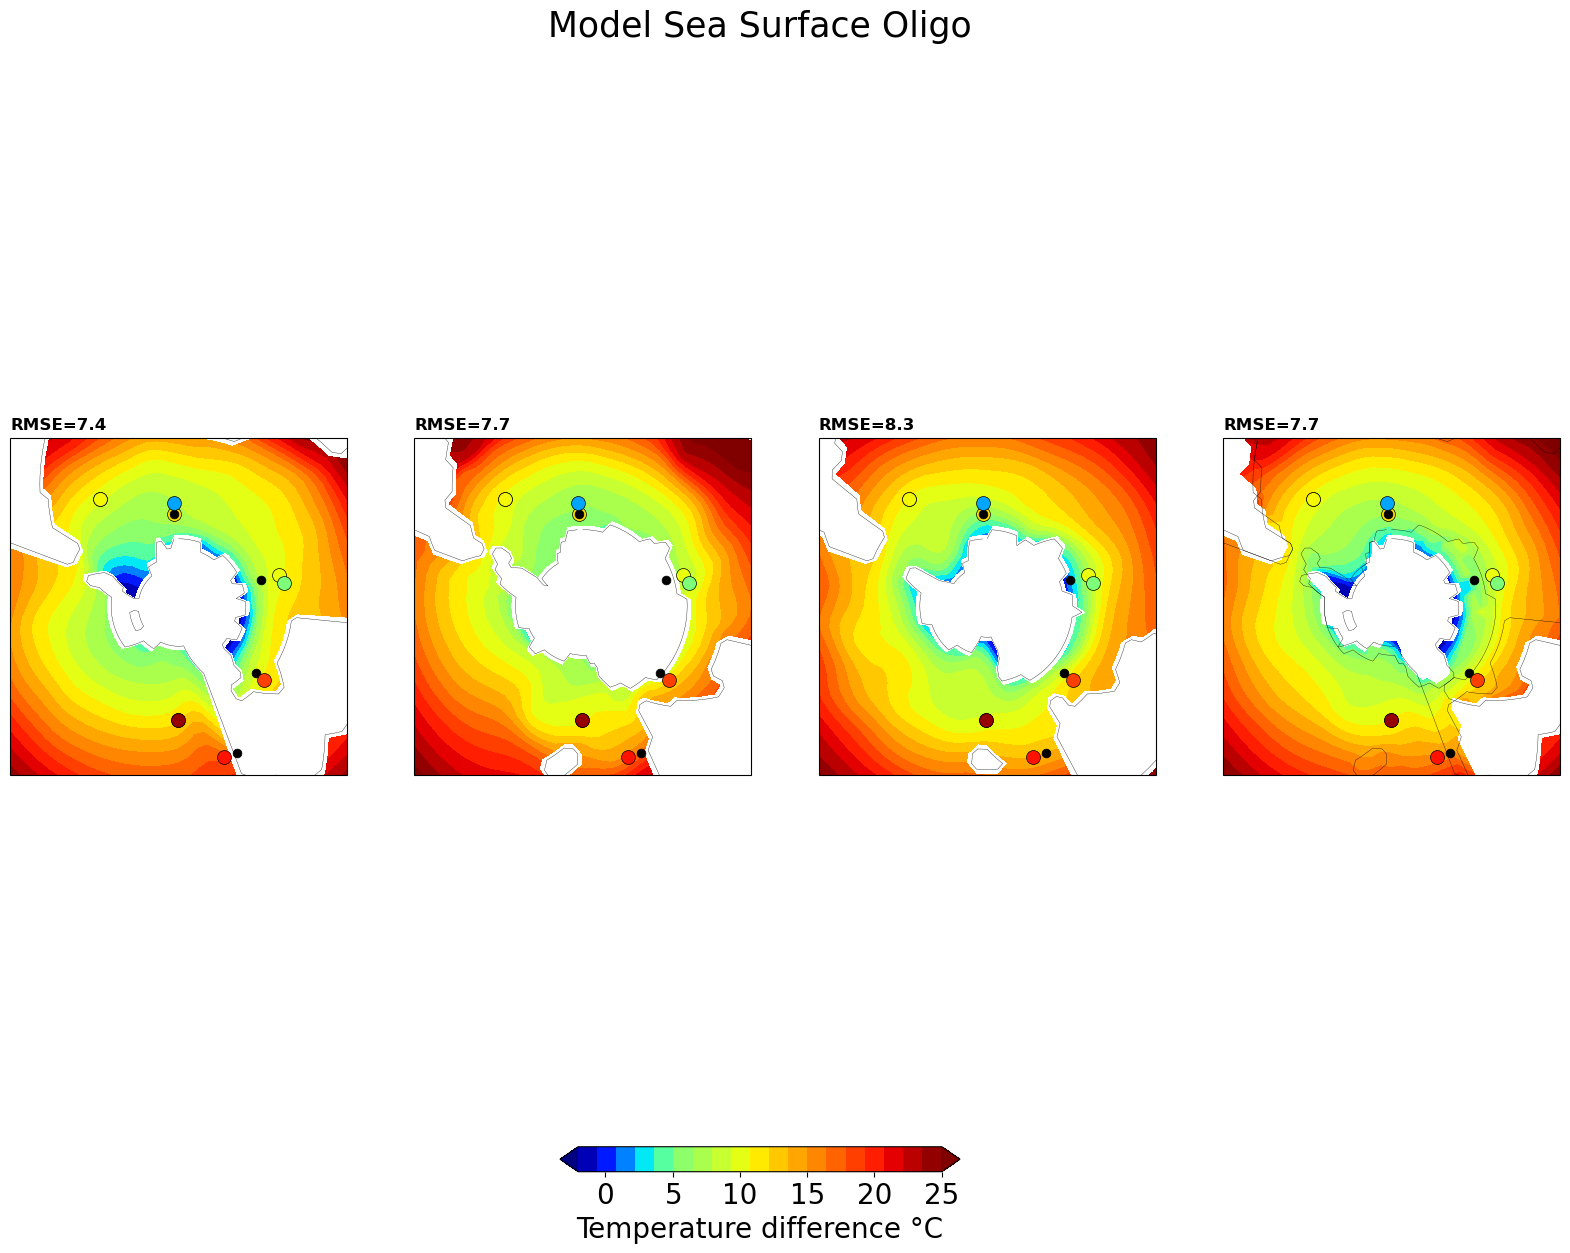

In [100]:
#Oligocene ice SST
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-2,vcenter=5,vmax=25)

for j in range(0,len(SSTice_Oligo)):
    var = SSTice_Oligo[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(1, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SSTice_Oligo.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-2,25,20),extend='both')
    for i in range(0,len(Oligo_proxy_SST)):
        cd=ax.scatter(Oligo_proxy_SST['Paleolongitude'][i],Oligo_proxy_SST['Paleolatitude'][i],c='black',s=40,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree())
        cf=ax.scatter(Oligo_proxy_SST['New paleolon'][i],Oligo_proxy_SST['New paleolat'][i],c=Oligo_proxy_SST['Oligo SST'][i],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   
    if j==3:
        for k in range(0,2):
            coast_all=landmask_ice[k,:,:]*1
            ax.contour(landmask_ice.longitude,landmask_ice.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_ice[j,:,:]*1
        ax.contour(landmask_ice.longitude,landmask_ice.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_OligoSST_ice[j]),fontweight='bold', fontsize=12,loc='left')
    
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,5,10,15,20,25])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Oligo',fontsize=25)
plt.savefig('SST_iceoligo_proxymodel.pdf')

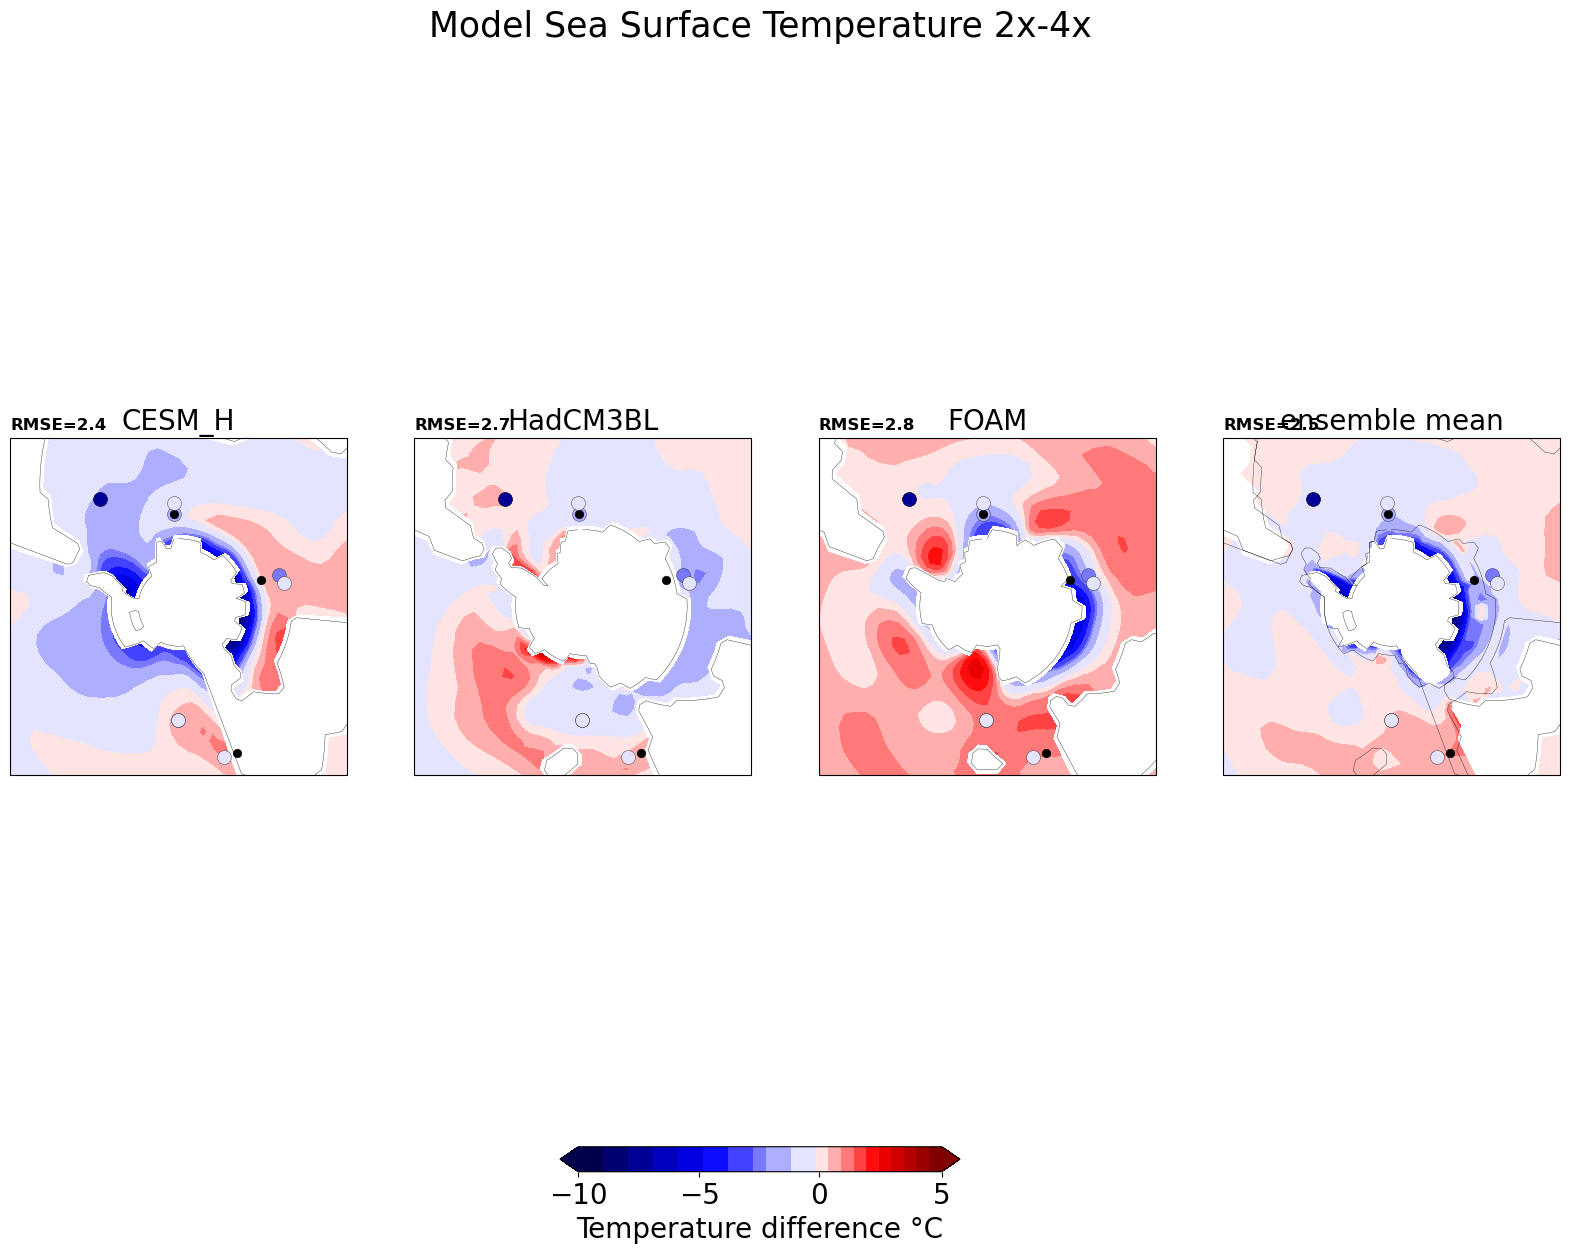

In [101]:
#EOT difference
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelice_SST)):
    var = diff_modelice_SST[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(1, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelice_SST.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    if j==3:
        for k in range(0,2):
            coast_all=landmask_noice[k,:,:]*1
            ax.contour(landmask_noice.longitude,landmask_noice.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        coast=landmask_noice[j,:,:]*1
        ax.contour(landmask_noice.longitude,landmask_noice.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_ice[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffSST_ice[j]),fontweight='bold', fontsize=12,loc='left')
    datlist=[0,1,2,3,4,5,6,7,8]
    for i in range(0,len(proxy_SST)):
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SST['Paleolongitude'][i],proxy_SST['Paleolatitude'][i],c='black',s=40,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
        cf=ax.scatter(proxy_SST['New paleolon'][i],proxy_SST['New paleolat'][i],c=proxy_SST['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature 2x-4x',fontsize=25)
plt.savefig('SST_icediff_proxymodel.pdf')

Paleogeographic comparison

In [102]:
#isolating preEOT

#SAT
pre_SAT=np.where(run_infogeo_SAT=='PreEOT')
preeotls_SAT=np.array(pre_SAT)
preeot_SAT=SAT_C_updated[preeotls_SAT[0,:],:,:]

model_preeot=modelnames[preeotls_SAT[0,:]]
#SST
pre_SST=np.where(run_infogeo_SST=='PreEOT')
preeotls_SST=np.array(pre_SST)
preeot_SST=SST_updated[preeotls_SST[0,:],:,:]

landmask_preeot=np.isnan(preeot_SST)

#isolating only postEOT runs

post_SAT=np.where(run_infogeo_SAT=='PostEOT')
posteotls_SAT=np.array(post_SAT)
posteot_SAT=SAT_C_updated[posteotls_SAT[0,:],:,:]

model_posteot=modelnames[posteotls_SAT[0,:]]

post_SST=np.where(run_infogeo_SST=='PostEOT')
posteotls_SST=np.array(post_SST)
posteot_SST=SST_updated[posteotls_SST[0,:],:,:]

landmask_posteot=np.isnan(posteot_SST)

diff_geo=posteot_SAT-preeot_SAT

diff_geo_SST=posteot_SST-preeot_SST


In [103]:
#model ensemble mean

ensemblemean_geo=np.mean(diff_geo, axis=0)
ensemblemean_geoSST=np.mean(diff_geo_SST,axis=0)
diff_modelgeo=xr.concat([diff_geo,ensemblemean_geo],'exp')
diff_modelgeo_SST=xr.concat([diff_geo_SST,ensemblemean_geoSST],'exp')

#Eocene mean
ensemblegeo_eo_SST=np.mean(preeot_SST, axis=0)
SSTgeo_EO=xr.concat([preeot_SST,ensemblegeo_eo_SST],'exp')
ensemblegeo_eo_SAT=np.mean(preeot_SAT, axis=0)
SATgeo_EO=xr.concat([preeot_SAT,ensemblegeo_eo_SAT],'exp')

#Oligocene mean
ensemblegeo_oligo=np.mean(posteot_SAT, axis=0)
SATgeo_Oligo=xr.concat([posteot_SAT,ensemblegeo_oligo],'exp')
ensemblegeo_oligo_SST=np.mean(posteot_SST, axis=0)
SSTgeo_Oligo=xr.concat([posteot_SST,ensemblegeo_oligo_SST],'exp')

Eocene SST

In [104]:
Eocene_proxy_SAT7=Eocene_proxy_SAT[:]

Eocene_proxy_SAT7['New paleolat']=Eocene_proxy_SAT7['Paleolatitude']
Eocene_proxy_SAT7['New paleolon']=Eocene_proxy_SAT7['Paleolongitude']

latchange=[-10,-10,0,0,-1,-5,-5,0,-5,-10,0,-3,-8]
lonchange=[0,0,0,0,-11,-7,-8,0,-15,0,0,-14,-12]
for i in range(0,13):
        Eocene_proxy_SAT7['New paleolat'][i]=Eocene_proxy_SAT7['Paleolatitude'][i]+latchange[i]
        Eocene_proxy_SAT7['New paleolon'][i]=Eocene_proxy_SAT7['Paleolongitude'][i]+lonchange[i]

Eocene_proxy_SAT7=Eocene_proxy_SAT7.to_xarray()

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A val

In [105]:
Eocenegeo_SAT=Eocene_proxy_SAT1.expand_dims(dim='nmodels')
Eocenegeo_SAT=xr.concat([Eocenegeo_SAT,Eocene_proxy_SAT2],'nmodels')
Eocenegeo_SAT=xr.concat([Eocenegeo_SAT,Eocene_proxy_SAT3],'nmodels')
Eocenegeo_SAT=xr.concat([Eocenegeo_SAT,Eocene_proxy_SAT4],'nmodels')

Eocenegeo_SAT=xr.concat([Eocenegeo_SAT,Eocene_proxy_SAT7],'nmodels') #uvic
Eocenegeo_SAT=xr.concat([Eocenegeo_SAT,Eocene_proxy_SAT5],'nmodels') #noresml
Eocenegeo_SAT=xr.concat([Eocenegeo_SAT,Eocene_proxy_SAT6],'nmodels') #ensemble mean

Oligocene SST

In [106]:
Oligo_proxy_SAT7=Oligo_proxy_SAT[:]

Oligo_proxy_SAT7['New paleolat']=Oligo_proxy_SAT7['Paleolatitude']
Oligo_proxy_SAT7['New paleolon']=Oligo_proxy_SAT7['Paleolongitude']

latchange=[-10,-10,0,-15,0,-10,-5,-6]
lonchange=[0,0,0,0,0,0,-25,-12]
for i in range(0,8):
        Oligo_proxy_SAT7['New paleolat'][i]=Oligo_proxy_SAT7['Paleolatitude'][i]+latchange[i]
        Oligo_proxy_SAT7['New paleolon'][i]=Oligo_proxy_SAT7['Paleolongitude'][i]+lonchange[i]

Oligo_proxy_SAT7=Oligo_proxy_SAT7.to_xarray()

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [107]:
Oligo_geo_SAT=Oligo_proxy_SAT1.expand_dims(dim='nmodels')
Oligo_geo_SAT=xr.concat([Oligo_geo_SAT,Oligo_proxy_SAT2],'nmodels')
Oligo_geo_SAT=xr.concat([Oligo_geo_SAT,Oligo_proxy_SAT3],'nmodels')
Oligo_geo_SAT=xr.concat([Oligo_geo_SAT,Oligo_proxy_SAT4],'nmodels')

Oligo_geo_SAT=xr.concat([Oligo_geo_SAT,Oligo_proxy_SAT7],'nmodels')
Oligo_geo_SAT=xr.concat([Oligo_geo_SAT,Oligo_proxy_SAT5],'nmodels')
Oligo_geo_SAT=xr.concat([Oligo_geo_SAT,Oligo_proxy_SAT6],'nmodels')

EOT difference SST

In [108]:
proxy_SAT_7=proxy_SAT[:]

proxy_SAT_7['New paleolat']=proxy_SAT_7['Paleolatitude']
proxy_SAT_7['New paleolon']=proxy_SAT_7['Paleolongitude']

latchange=[-10,-10,0,0,-5,-1]
lonchange=[0,0,0,0,-20,-12]
for i in range(0,6):
        proxy_SAT_7['New paleolat'][i]=proxy_SAT_7['Paleolatitude'][i]+latchange[i]
        proxy_SAT_7['New paleolon'][i]=proxy_SAT_7['Paleolongitude'][i]+lonchange[i]

proxy_SAT_7=proxy_SAT_7.to_xarray()

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [109]:
SATgeo_proxy=proxy_SAT_1.expand_dims(dim='nmodels')
SATgeo_proxy=xr.concat([SATgeo_proxy,proxy_SAT_2],'nmodels')
SATgeo_proxy=xr.concat([SATgeo_proxy,proxy_SAT_3],'nmodels')
SATgeo_proxy=xr.concat([SATgeo_proxy,proxy_SAT_4],'nmodels')

SATgeo_proxy=xr.concat([SATgeo_proxy,proxy_SAT_7],'nmodels')
SATgeo_proxy=xr.concat([SATgeo_proxy,proxy_SAT_5],'nmodels')
SATgeo_proxy=xr.concat([SATgeo_proxy,proxy_SAT_6],'nmodels')


Eocene RMSE calc and plot

In [110]:
#Source ara for paleogeo Eocene
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
lats=range(0,73)
lons=range(0,96)
lat=SATgeo_EO.latitude
lon=SATgeo_EO.longitude
circlesgeo_Eocene=np.empty([13,7,73,96])
circlesgeo_Eocene=xr.DataArray(circlesgeo_Eocene,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATgeo_EO)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Eocenegeo_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Eocenegeo_SAT['New paleolon'][j][datlist][i] #circle center lon
        if i==0 or i==1 or i==9:
            if j==0:
                masklon = abs(SATgeo_EO[j].longitude[lons]- originlon)<21
                masklat = abs(SATgeo_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATgeo_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATgeo_EO[j].latitude[lats]-originlat)<7.5
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(SATgeo_EO[j].longitude[lons]- originlon)<20
                masklat = abs(SATgeo_EO[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATgeo_EO[j].longitude[lons]- originlon)<15
                masklat = abs(SATgeo_EO[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2 or i==7:#-63.85,-53.91,2,7
            if j==0 or j==1:
                masklon = (SATgeo_EO[j].longitude[lons]- originlon)<15
                masklonl= (SATgeo_EO[j].longitude[lons]- originlon)>-30
                masklat = (SATgeo_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATgeo_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = (SATgeo_EO[j].longitude[lons]- originlon)<17
                masklonl= (SATgeo_EO[j].longitude[lons]- originlon)>-40
                masklat = (SATgeo_EO[j].latitude[lats]-originlat)<8
                masklatl = (SATgeo_EO[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3 or i==12: 
            masklon = abs(SATgeo_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATgeo_EO[j].latitude[lats]-originlat)<4
            arr[masklat & masklon] = 1
        if i==4 or i==5 or i==6 or i==8 or i==10 or i==11:
            masklon = abs(SATgeo_EO[j].longitude[lons]- originlon)<6
            masklat = abs(SATgeo_EO[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        arr = np.where(SATgeo_EO[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circlesgeo_Eocene[i,j,:,:]=arr; del arr 

In [112]:
datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
prox=np.empty((13))
array=np.empty((13,7,73,96))
Eocene_geoSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATgeo_EO)):
    for i in range(len(datlist)):
        Eocene_temp= SATgeo_EO[ex][:,:]
        Eocene_geoSAT[i,ex,:,:]=np.where(circlesgeo_Eocene[i,ex,:,:]==1, Eocene_temp, np.nan)
        prox[i] = Eocene_proxy_SAT['Eocene SAT'][datlist][i]
        

Eocene_geoSAT['latitude']=SATgeo_EO.latitude
Eocene_geoSAT['longitude']=SATgeo_EO.longitude 

weights=np.cos(np.deg2rad(SATgeo_EO.latitude))
SATgeo_weighted=Eocene_geoSAT.weighted(weights)
EOgeo_weighted_SAT = SATgeo_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((13,7))
rms_Eocene_geo=np.empty((7))
for ex in range(0,len(SATgeo_EO)):
    errors[:,ex]=(EOgeo_weighted_SAT[:,ex]-prox[:])
    rms_Eocene_geo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1)
rms_Eocene_geo

array([ 4.9,  5.2, 12. , 11. ,  6. , 11. ,  7.7])

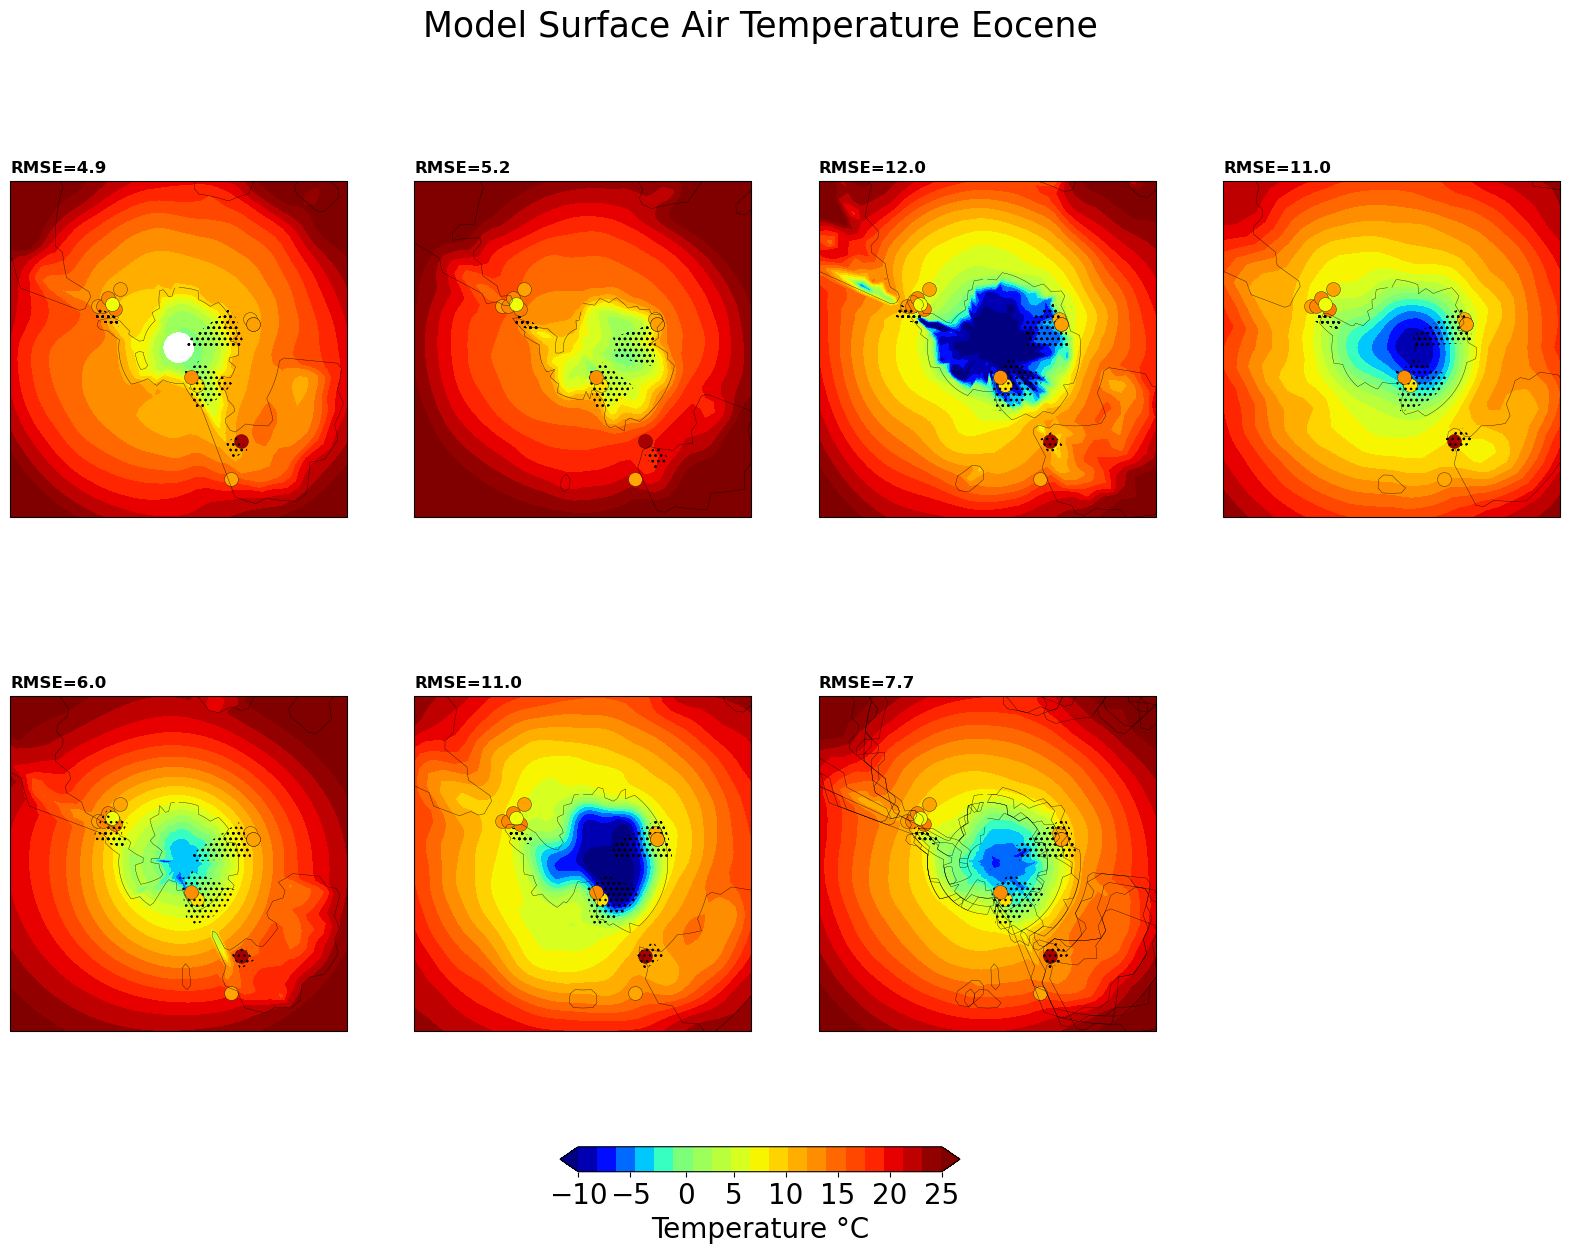

In [113]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATgeo_EO)):
    var = SATgeo_EO[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATgeo_EO.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7,8,9,10,11,12])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
# Add coastlines
    if j==6:
        for k in range(0,5):
            coast_all=landmask_preeot[k,:,:]*1
            ax.contour(landmask_preeot.longitude,landmask_preeot.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title('ensemble mean',fontweight='bold', fontsize=16,loc='left')
    else:
        coast=landmask_preeot[j,:,:]*1
        ax.contour(landmask_preeot.longitude,landmask_preeot.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_preeot[j],fontweight='bold', fontsize=16,loc='left')
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    
    ax.set_title('RMSE='+str(rms_Eocene_geo[j]),fontweight='bold', fontsize=12,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circlesgeo_Eocene[h,j],coord=SATgeo_EO[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(Eocene_proxy_SAT['Paleolongitude'][h],Eocene_proxy_SAT['Paleolatitude'][h],c=Eocene_proxy_SAT['Eocene SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
       
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature Eocene',fontsize=25)
plt.savefig('SAT_geoEocene_proxymodel.pdf')

In [114]:
#Oligocene paleogeo source area
datlist=list([0,1,2,3,4,5,6,7])
lats=range(0,73)
lons=range(0,96)
lat=SATgeo_Oligo.latitude
lon=SATgeo_Oligo.longitude
circlesgeo_Oligo=np.empty([8,7,73,96])
circlesgeo_Oligo=xr.DataArray(circlesgeo_Oligo,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(SATgeo_Oligo)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=Oligo_geo_SAT['New paleolat'][j][datlist][i] #circle center lat
        originlon=Oligo_geo_SAT['New paleolon'][j][datlist][i] #circle center lon
        
        if i==0 or i==1: #same cores different proxies
            if j==0:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<7
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<20
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<15
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2 or i==5:
            if j==1:
                masklon = (SATgeo_Oligo[j].longitude[lons]- originlon)<15
                masklonl= (SATgeo_Oligo[j].longitude[lons]- originlon)>-40
                masklat = (SATgeo_Oligo[j].latitude[lats]-originlat)<6
                masklatl = (SATgeo_Oligo[j].latitude[lats]-originlat)>-8
                arr[masklat & masklatl & masklon & masklonl] = 1
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = (SATgeo_Oligo[j].longitude[lons]- originlon)<17
                masklonl= (SATgeo_Oligo[j].longitude[lons]- originlon)>-40
                masklat = (SATgeo_Oligo[j].latitude[lats]-originlat)<8
                masklatl = (SATgeo_Oligo[j].latitude[lats]-originlat)>-6
                arr[masklat & masklatl & masklon & masklonl] = 1
        if i==3:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<10
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
                arr[masklat & masklon] = 1
        if i==4:
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<5.5
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<7
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        if i==6:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<6
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<5
                arr[masklat & masklon] = 1
        if i==7:
                masklon = abs(SATgeo_Oligo[j].longitude[lons]- originlon)<5.5
                masklat = abs(SATgeo_Oligo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        arr = np.where(SATgeo_Oligo[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circlesgeo_Oligo[i,j,:,:]=arr; del arr 

In [115]:
datlist=list([0,1,2,3,4,5,6,7])
prox=np.empty((8))
array=np.empty((8,7,73,96))
Oligo_geoSAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
for ex in range(0,len(SATgeo_Oligo)):
    for i in range(len(datlist)):
        Oligo_temp= SATgeo_Oligo[ex][:,:]
        Oligo_geoSAT[i,ex,:,:]=np.where(circlesgeo_Oligo[i,ex,:,:]==1, Oligo_temp, np.nan)
        prox[i] = Oligo_proxy_SAT['Oligo SAT'][datlist][i]
        

Oligo_geoSAT['latitude']=SATgeo_Oligo.latitude
Oligo_geoSAT['longitude']=SATgeo_Oligo.longitude 

weights=np.cos(np.deg2rad(SATgeo_Oligo.latitude))
SATgeo_weighted=Oligo_geoSAT.weighted(weights)
Oligogeo_weighted_SAT = SATgeo_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((8,7))
rms_Oligo_geo=np.empty((7))
for ex in range(0,len(SATgeo_Oligo)):
    errors[:,ex]=(Oligogeo_weighted_SAT[:,ex]-prox[:])
    rms_Oligo_geo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1)
rms_Oligo_geo


array([ 3. ,  3.3,  8.8, 10.1,  5.3,  9.4,  5. ])

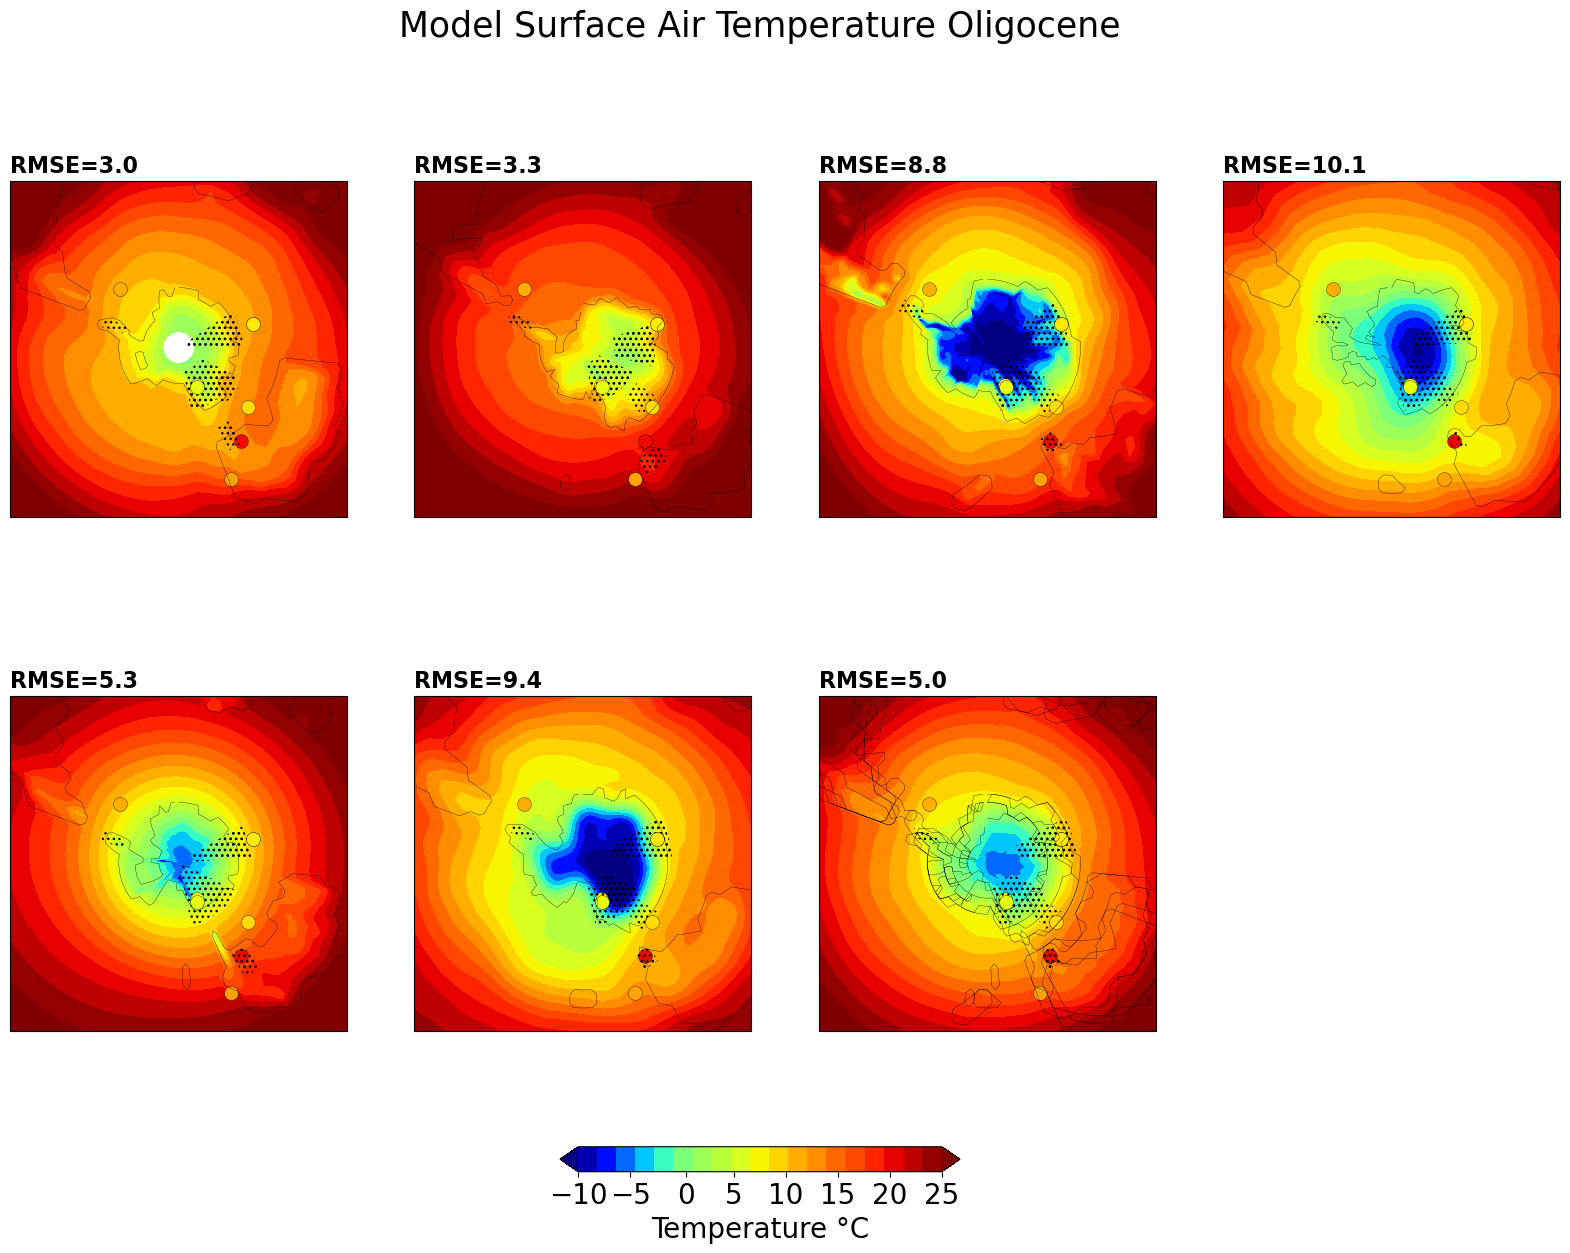

In [116]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=25)

for j in range(0,len(SATgeo_Oligo)):
    var = SATgeo_Oligo[j,:,:]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SATgeo_Oligo.longitude)

# Make a filled contour plot
    datlist=list([0,1,2,3,4,5,6,7])
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-10,25,20),extend='both')
    #cb.ax.tick_params(labelsize=15)
# Add coastlines
    if j==6:
        for k in range(0,5):
            coast_all=landmask_posteot[k,:,:]*1
            ax.contour(landmask_posteot.longitude,landmask_posteot.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_posteot[j,:,:]*1
        ax.contour(landmask_posteot.longitude,landmask_posteot.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_Oligo_geo[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circlesgeo_Oligo[h,j],coord=SATgeo_Oligo[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(Oligo_proxy_SAT['Paleolongitude'][h],Oligo_proxy_SAT['Paleolatitude'][h],c=Oligo_proxy_SAT['Oligo SAT'][h],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
     
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5,10,15,20,25,30,35,40])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature Oligocene',fontsize=25)
plt.savefig('SAT_geoOligocene_proxymodel.pdf')

In [117]:
#EOT difference paleogeo source area
datlist=list([0,1,2,3,4,5])
lats=range(0,73)
lons=range(0,96)
circles=[] #
lat=diff_modelgeo.latitude
lon=diff_modelgeo.longitude
circlesgeo_diff=np.empty([6,7,73,96])
circlesgeo_diff=xr.DataArray(circlesgeo_diff,dims=['nproxies','nmodels','latitude','longitude'])

for j in range(0,len(diff_modelgeo)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=SATgeo_proxy['New paleolat'][j][datlist][i] 
        originlon=SATgeo_proxy['New paleolon'][j][datlist][i]
        if i==0 or i==1: #same cores different proxies
            if j==0:
                masklon = abs(diff_modelgeo[j].longitude[lons]- originlon)<17
                masklat = abs(diff_modelgeo[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(diff_modelgeo[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelgeo[j].latitude[lats]-originlat)<7
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(diff_modelgeo[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelgeo[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(diff_modelgeo[j].longitude[lons]- originlon)<15
                masklat = abs(diff_modelgeo[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2:
            masklon = (diff_modelgeo[j].longitude[lons]- originlon)<17
            masklonl= (diff_modelgeo[j].longitude[lons]- originlon)>-40
            masklat = (diff_modelgeo[j].latitude[lats]-originlat)<8
            masklatl = (diff_modelgeo[j].latitude[lats]-originlat)>-6
            arr[masklat & masklatl & masklon & masklonl] = 1
        if i==4:
            masklon = abs(diff_modelgeo[j].longitude[lons]- originlon)<5.5
            masklat = abs(diff_modelgeo[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        if i==3 or i==5:
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = abs(diff_modelgeo[j].longitude[lons]- originlon)<5.5
                masklat = abs(diff_modelgeo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(diff_modelgeo[j].longitude[lons]- originlon)<5
                masklat = abs(diff_modelgeo[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        arr = np.where(diff_modelgeo[j][lats,lons]!='nan',arr,0)
        arr = np.where(arr==0,np.nan,1)
        circlesgeo_diff[i,j,:,:]=arr; del arr 

In [118]:
datlist=list([0,1,2,3,4,5])
array=np.empty((6,7,73,96))
meangeo_SAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
prox=np.empty((6))
for ex in range(0,len(diff_modelgeo)):
    for i in range(0, len(datlist)):
        modelmean= diff_modelgeo[ex,:,:]
        meangeo_SAT[i,ex,:,:]=np.where(circlesgeo_diff[i,ex,:,:]==1, modelmean, np.nan)
        prox[i] = proxy_SAT['EOT diff'][datlist][i]
        
meangeo_SAT['latitude']=diff_modelgeo.latitude
meangeo_SAT['longitude']=diff_modelgeo.longitude
   
weights=np.cos(np.deg2rad(diff_modelgeo.latitude))
SATgeo_weighted=meangeo_SAT.weighted(weights)
geo_weighted_SAT = SATgeo_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((6,7))
rms_diffgeo=np.empty((7))
for ex in range(0,len(diff_modelgeo)):
        errors[:,ex]=(geo_weighted_SAT[:,ex]-prox[:])
        rms_diffgeo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_diffgeo

array([3. , 3.4, 5. , 2.4, 2.4, 2.8, 3. ])

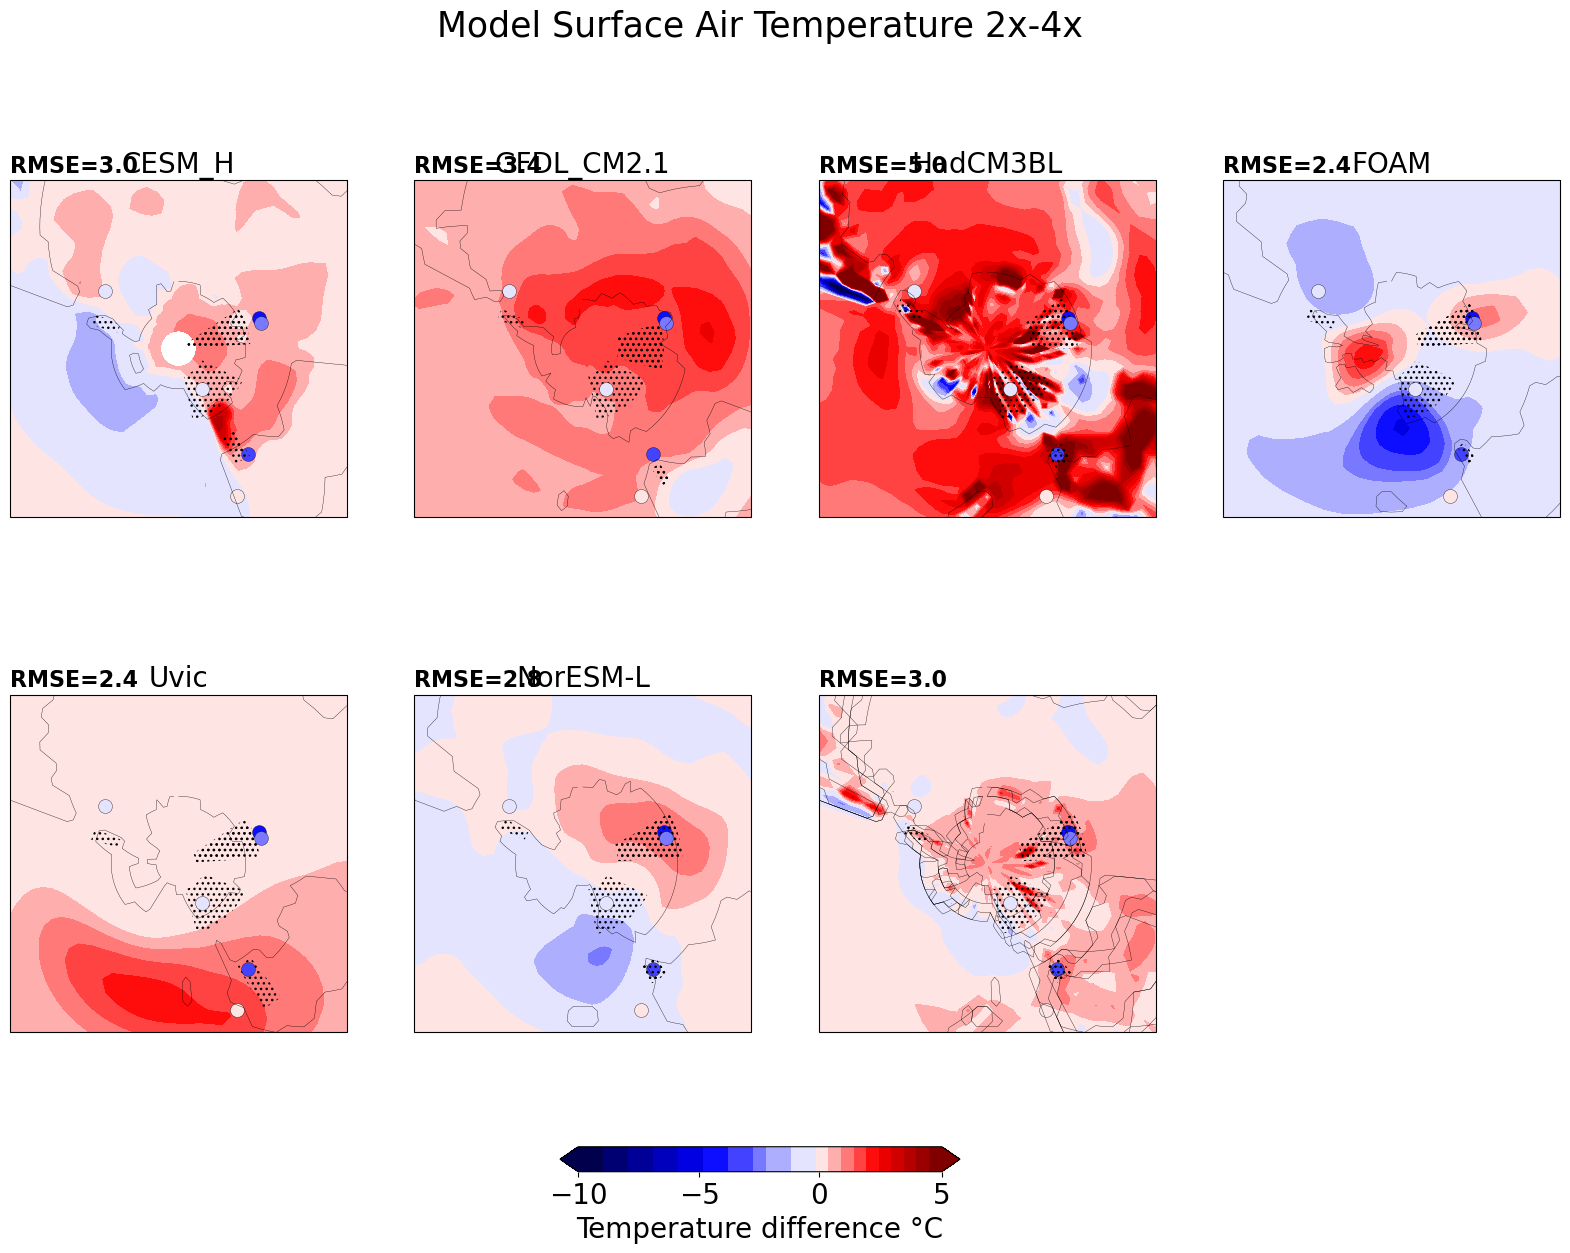

In [119]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelgeo)):
    var = diff_modelgeo[j][lats,lons]

# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelgeo[j].longitude)

# Make a filled contour plot
    datlist=[0,1,2,3,4,5]
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    if j==6:
        for k in range(0,5):
            coast_all=landmask_posteot[k,:,:]*1
            ax.contour(landmask_posteot.longitude,landmask_posteot.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
    else:
        coast=landmask_posteot[j,:,:]*1
        ax.contour(landmask_posteot.longitude,landmask_posteot.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_preeot[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffgeo[j]),fontweight='bold', fontsize=16,loc='left')
    
    for h in (datlist):
        circ,lon= add_cyclic_point(circlesgeo_diff[h,j],coord=diff_modelgeo[j].longitude)
        ca=ax.contourf(lon,var.latitude,circ ,transform = ccrs.PlateCarree(), levels=[0,1],colors='none' ,hatches=['...'])
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SAT['Paleolongitude'][h],proxy_SAT['Paleolatitude'][h],c=proxy_SAT['EOT diff'][h],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
       
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature 2x-4x',fontsize=25)
plt.savefig('SAT_tempdiffgeo_proxymodel.pdf')

Sea surface temperature geo

In [120]:
#Eocene
prox=np.empty((11))
Eocenemodel_SST=np.empty((11,7))
for i in range(0,len(Eocene_proxy_SST)):
    for j in range (0,len(SSTgeo_EO)):
        Eocenemodel_SST[i,j]=(SSTgeo_EO[j].sel(latitude=Eocene_proxy_SST['New paleolat'][i],longitude=Eocene_proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = Eocene_proxy_SST['Eocene SST'][i]

        errors=np.empty((11,7))
rms_EOSST_geo=np.empty((7))
for ex in range(0,len(SSTgeo_EO)):
    errors[:,ex]=(Eocenemodel_SST[:,ex]-prox[:])
    rms_EOSST_geo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(Eocene_proxy_SST)).round(decimals=1) 
rms_EOSST_geo

array([6.9, 6.4, 8.6, 9.3, 7.1, 8.7, 7.2])

In [121]:
#Oligocene
Oligomodel_SST=np.empty((10,7))
prox=np.empty((10))
for i in range(0,len(Oligo_proxy_SST)):
    for j in range (0,len(SSTgeo_Oligo)):
        Oligomodel_SST[i,j]=(SSTgeo_Oligo[j].sel(latitude=Oligo_proxy_SST['New paleolat'][i],longitude=Oligo_proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = Oligo_proxy_SST['Oligo SST'][i]
    
errors=np.empty((10,7))
rms_OligoSST_geo=np.empty((7))
for ex in range(0,len(SSTgeo_Oligo)):
    errors[:,ex]=(Oligomodel_SST[:,ex]-prox[:])
    rms_OligoSST_geo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(Oligo_proxy_SST)).round(decimals=1) 
rms_OligoSST_geo

array([ 7.7,  8.3,  6.6, 10.5,  6.4,  9.2,  7.4])

In [122]:
#difference
diffmodel_SST=np.empty((9,7))
prox=np.empty((9))
for i in range(0,len(proxy_SST)):
    for j in range (0,len(diff_modelgeo_SST)):
        diffmodel_SST[i,j]=(diff_modelgeo_SST[j].sel(latitude=proxy_SST['New paleolat'][i],longitude=proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = proxy_SST['EOT diff'][i]

errors=np.empty((9,7))
rms_diffSST_geo=np.empty((7))
for ex in range(0,len(diff_modelgeo_SST)):
    errors[:,ex]=(diffmodel_SST[:,ex]-prox[:])
    rms_diffSST_geo[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(proxy_SST)).round(decimals=1)
rms_diffSST_geo

array([3. , 3.7, 4.4, 2.8, 3.4, 3. , 3. ])

Plot paleogeo SST proxies and models

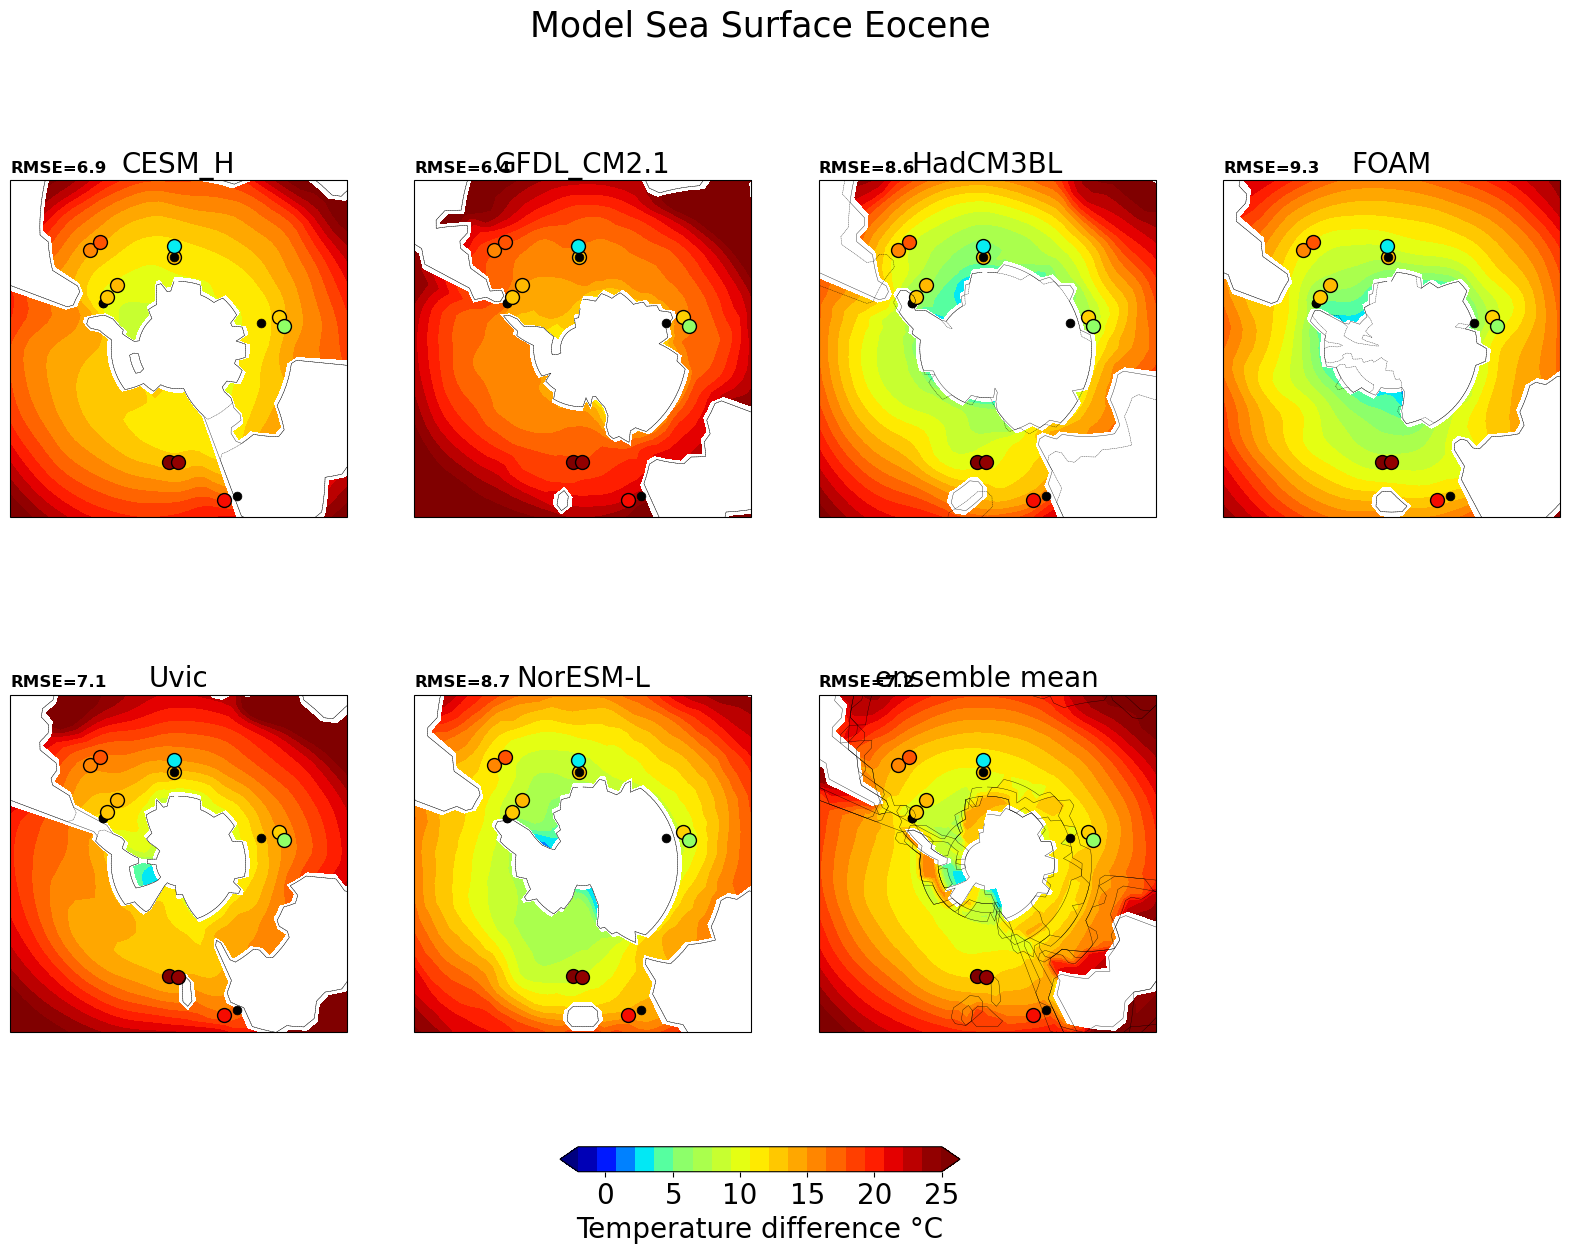

In [123]:
#Eocene SST
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-2,vcenter=5,vmax=25)

for j in range(0,len(SSTgeo_EO)):
    var = SSTgeo_EO[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SSTgeo_EO.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-2,25,20),extend='both')
    
    for i in range(0,len(Eocene_proxy_SST)):
        cd=ax.scatter(Eocene_proxy_SST['Paleolongitude'][i],Eocene_proxy_SST['Paleolatitude'][i],c='black',s=40,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree())
        cf=ax.scatter(Eocene_proxy_SST['New paleolon'][i],Eocene_proxy_SST['New paleolat'][i],c=Eocene_proxy_SST['Eocene SST'][i],s=100,cmap='jet',norm=norm,edgecolor='black',transform=ccrs.PlateCarree()) #the artificial center of the averaging region
    if j==6:
        for k in range(0,5):
            coast_all=landmask_preeot[k,:,:]*1
            ax.contour(landmask_preeot.longitude,landmask_preeot.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        coast=landmask_preeot[j,:,:]*1
        ax.contour(landmask_preeot.longitude,landmask_preeot.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        coast1=landmask_posteot[j,:,:]*1
        ax.contour(landmask_posteot.longitude,landmask_posteot.latitude,coast1, colors='k', linestyles='--',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree())
        ax.set_title(model_preeot[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_EOSST_geo[j]),fontweight='bold', fontsize=12,loc='left')

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,5,10,15,20,25])
#ch=plt.colorbar(cd,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,5,10,15,20,25])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Eocene',fontsize=25)
plt.savefig('SST_geoEocene_proxymodel.pdf')

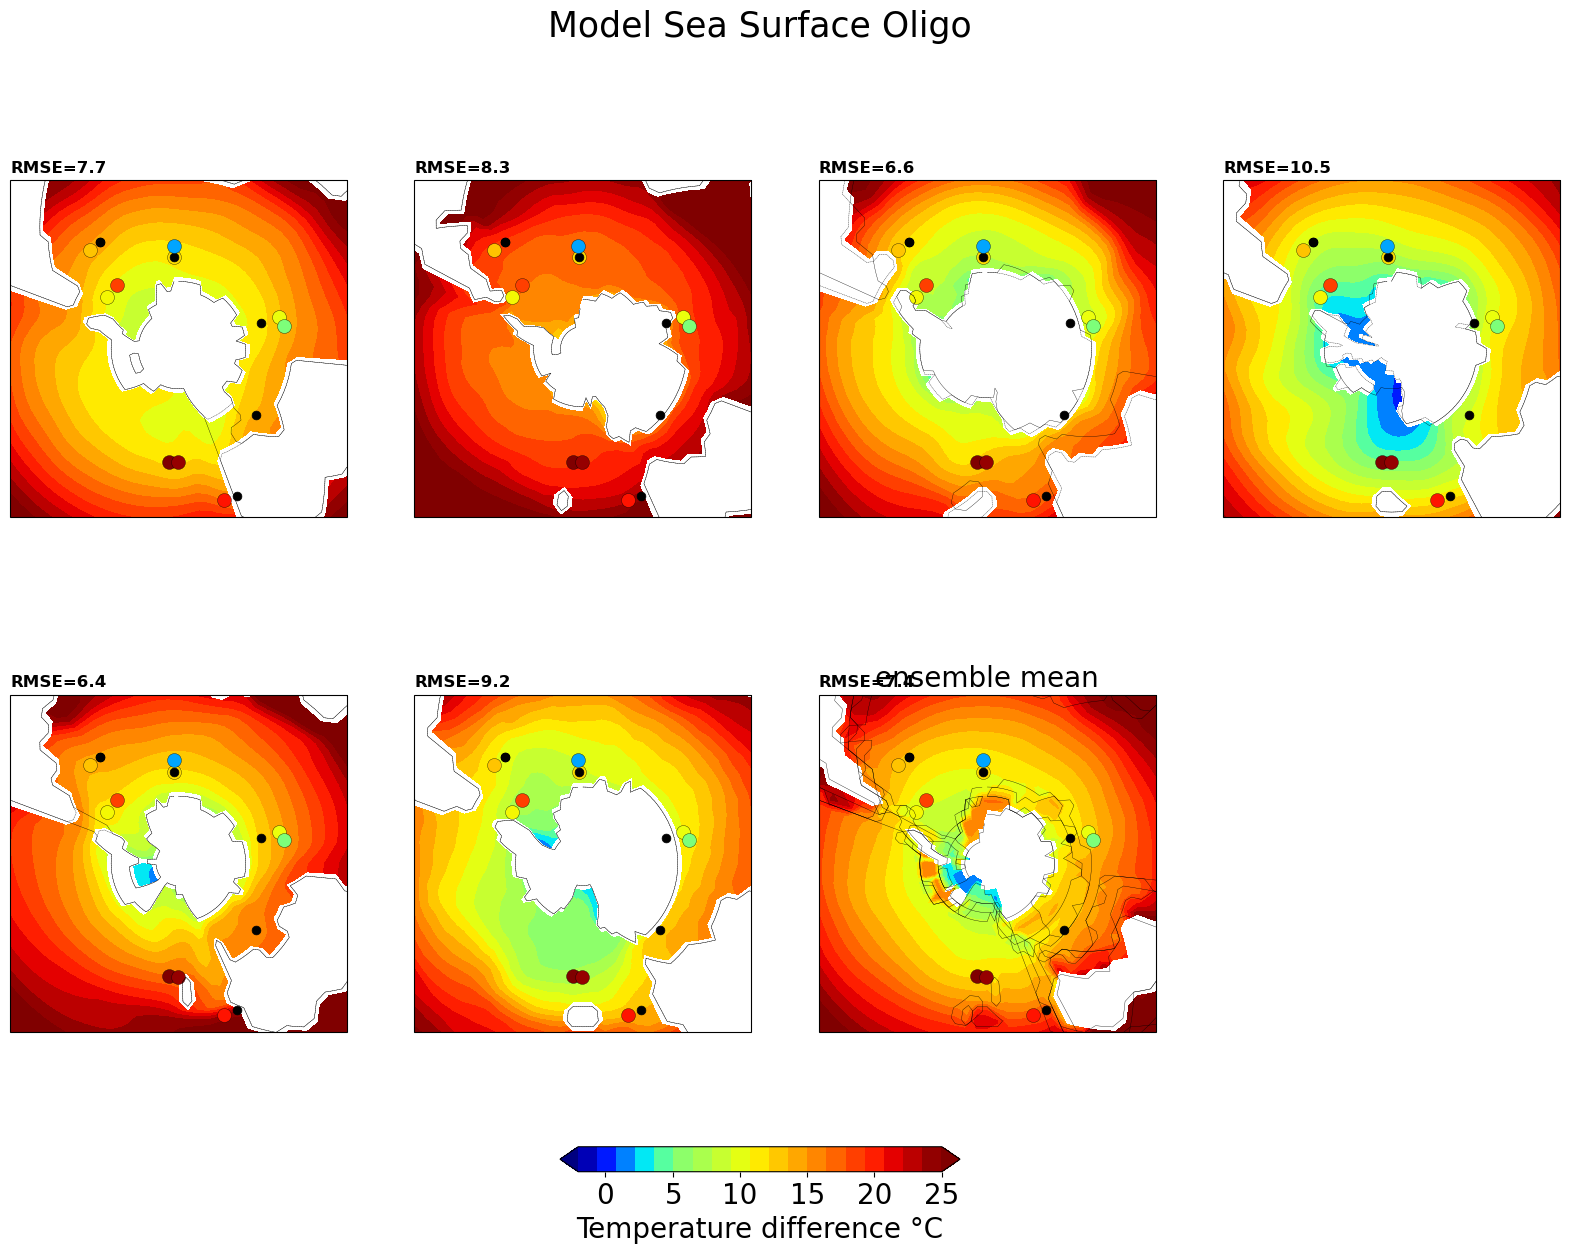

In [125]:
#Oligocene SST
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-2,vcenter=5,vmax=25)

for j in range(0,len(SSTgeo_Oligo)):
    var = SSTgeo_Oligo[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=SSTgeo_Oligo.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap='jet',norm=norm,levels=np.linspace(-2,25,20),extend='both')
    for i in range(0,len(Oligo_proxy_SST)):
        cd=ax.scatter(Oligo_proxy_SST['Paleolongitude'][i],Oligo_proxy_SST['Paleolatitude'][i],c='black',s=40,cmap='jet',norm=norm,edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree())
        cf=ax.scatter(Eocene_proxy_SST['New paleolon'][i],Eocene_proxy_SST['New paleolat'][i],c=Oligo_proxy_SST['Oligo SST'][i],s=100,cmap='jet',norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
    if j==6:
        for k in range(0,5):
            coast_all=landmask_preeot[k,:,:]*1
            ax.contour(landmask_preeot.longitude,landmask_preeot.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        coast=landmask_preeot[j,:,:]*1
        ax.contour(landmask_preeot.longitude,landmask_preeot.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        coast1=landmask_posteot[j,:,:]*1
        ax.contour(landmask_posteot.longitude,landmask_posteot.latitude,coast1, colors='k', linestyles='--',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_OligoSST_geo[j]),fontweight='bold', fontsize=12,loc='left')

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[0,5,10,15,20,25])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Oligo',fontsize=25)
plt.savefig('SST_geooligo_proxymodel.pdf')

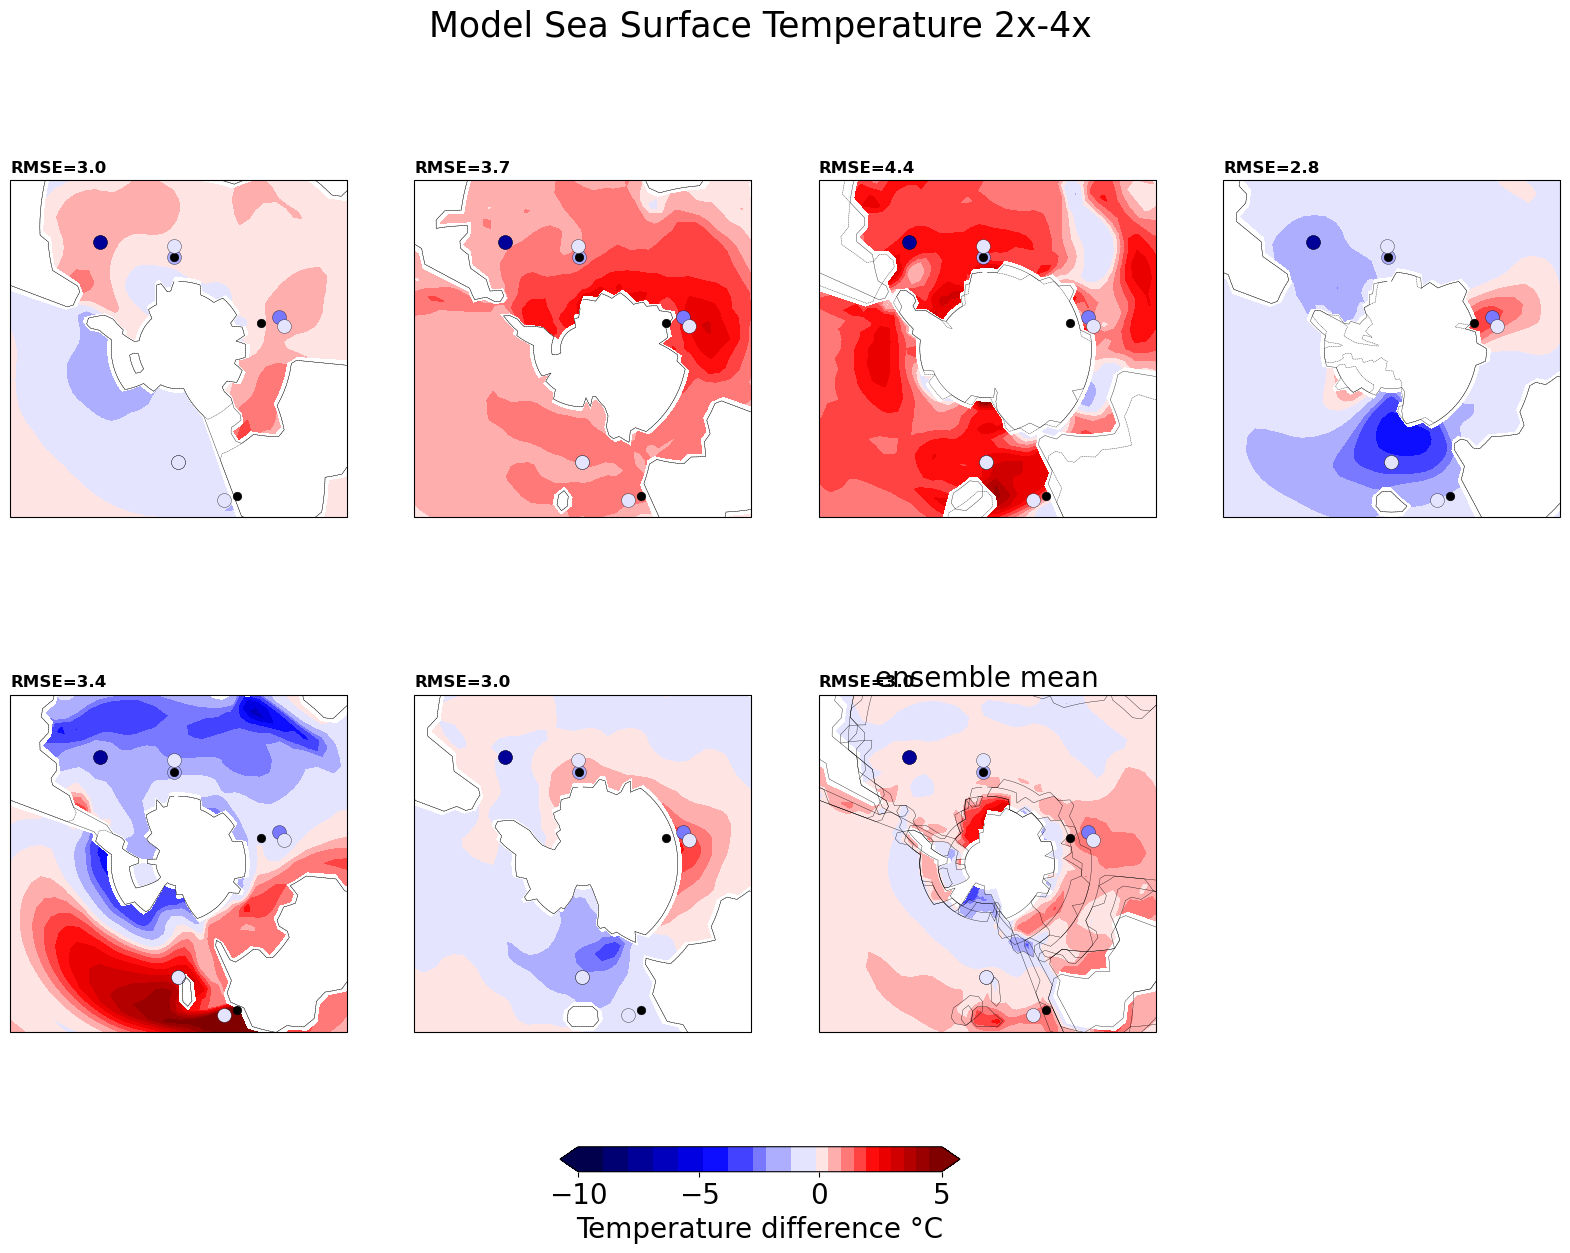

In [126]:
#EOT difference SST
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(diff_modelgeo_SST)):
    var = diff_modelgeo_SST[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=diff_modelgeo_SST.longitude)

# Make a filled contour plot
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    if j==6:
        for k in range(0,5):
            coast_all=landmask_preeot[k,:,:]*1
            ax.contour(landmask_preeot.longitude,landmask_preeot.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        coast=landmask_preeot[j,:,:]*1
        ax.contour(landmask_preeot.longitude,landmask_preeot.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        coast1=landmask_posteot[j,:,:]*1
        ax.contour(landmask_posteot.longitude,landmask_posteot.latitude,coast1, colors='k', linestyles='--',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffSST_geo[j]),fontweight='bold', fontsize=12,loc='left')
    datlist=[0,1,2,3,4,5,6,7,8]
    for i in range(0,len(proxy_SST)):
#Add in proxy datapoints and new point locations
        cd=ax.scatter(proxy_SST['Paleolongitude'][i],proxy_SST['Paleolatitude'][i],c='black',s=40,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
        cf=ax.scatter(proxy_SST['New paleolon'][i],proxy_SST['New paleolat'][i],c=proxy_SST['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature 2x-4x',fontsize=25)
plt.savefig('SST_geodiff_proxymodel.pdf')

Averaging of Errors for bar plots

In [127]:
mean_RMSCO2_EO=np.mean(rms_Eocene)
mean_RMSCO2_Oligo=np.mean(rms_Oligo)
mean_RMSCO2_diff=np.mean(rms_diffSAT)
meanSST_RMSCO2_EO=np.mean(rms_EOSST)
meanSST_RMSCO2_Oligo=np.mean(rms_OligoSST)
meanSST_RMSCO2_diff=np.mean(rms_diffSST)
mean_RMSice_EO=np.mean(rms_Eoceneice)
mean_RMSice_Oligo=np.mean(rms_Oligoice)
mean_RMSice_diff=np.mean(rms_diffice)
meanSST_RMSice_EO=np.mean(rms_EOSST_ice)
meanSST_RMSice_Oligo=np.mean(rms_OligoSST_ice)
meanSST_RMSice_diff=np.mean(rms_diffSST_ice)
mean_RMSgeo_EO=np.mean(rms_Eocene_geo)
mean_RMSgeo_Oligo=np.mean(rms_Oligo_geo)
mean_RMSgeo_diff=np.mean(rms_diffgeo)
meanSST_RMSgeo_EO=np.mean(rms_EOSST_geo)
meanSST_RMSgeo_Oligo=np.mean(rms_OligoSST_geo)
meanSST_RMSgeo_diff=np.mean(rms_diffSST_geo)

In [130]:
#standard deviation
std_RMSCO2_EO=np.std(rms_Eocene)
std_RMSCO2_Oligo=np.std(rms_Oligo)
std_RMSCO2_diff=np.std(rms_diffSAT)
stdSST_RMSCO2_EO=np.std(rms_EOSST)
stdSST_RMSCO2_Oligo=np.std(rms_OligoSST)
stdSST_RMSCO2_diff=np.std(rms_diffSST)
std_RMSice_EO=np.std(rms_Eoceneice)
std_RMSice_Oligo=np.std(rms_Oligoice)
std_RMSice_diff=np.std(rms_diffice)
stdSST_RMSice_EO=np.std(rms_EOSST_ice)
stdSST_RMSice_Oligo=np.std(rms_OligoSST_ice)
stdSST_RMSice_diff=np.std(rms_diffSST_ice)
std_RMSgeo_EO=np.std(rms_Eocene_geo)
std_RMSgeo_Oligo=np.std(rms_Oligo_geo)
std_RMSgeo_diff=np.std(rms_diffgeo)
stdSST_RMSgeo_EO=np.std(rms_EOSST_geo)
stdSST_RMSgeo_Oligo=np.std(rms_OligoSST_geo)
stdSST_RMSgeo_diff=np.std(rms_diffSST_geo)

mean_eocene=[mean_RMSCO2_EO,meanSST_RMSCO2_EO,mean_RMSice_EO,meanSST_RMSice_EO,mean_RMSgeo_EO,meanSST_RMSgeo_EO]
mean_oligo=[mean_RMSCO2_Oligo,meanSST_RMSCO2_Oligo,mean_RMSice_Oligo,meanSST_RMSice_Oligo,mean_RMSgeo_Oligo,meanSST_RMSgeo_Oligo]
mean_diff=[mean_RMSCO2_diff,meanSST_RMSCO2_diff,mean_RMSice_diff,meanSST_RMSice_diff,mean_RMSgeo_diff,meanSST_RMSgeo_diff]

std_eocene=[std_RMSCO2_EO,stdSST_RMSCO2_EO,std_RMSice_EO,stdSST_RMSice_EO,std_RMSgeo_EO,stdSST_RMSgeo_EO]
std_oligo=[std_RMSCO2_Oligo,stdSST_RMSCO2_Oligo,std_RMSice_Oligo,stdSST_RMSice_Oligo,std_RMSgeo_Oligo,stdSST_RMSgeo_Oligo]
std_diff=[std_RMSCO2_diff,stdSST_RMSCO2_diff,std_RMSice_diff,stdSST_RMSice_diff,std_RMSgeo_diff,stdSST_RMSgeo_diff]

labels=['CO2 MAT','CO2 SST','ice MAT','ice SST','geo MAT','geo SST']

In [144]:
#improvement to RMSE after scaling for EOT difference
error=[inval_1d[0:6],inval_1d_SST[0:6]]

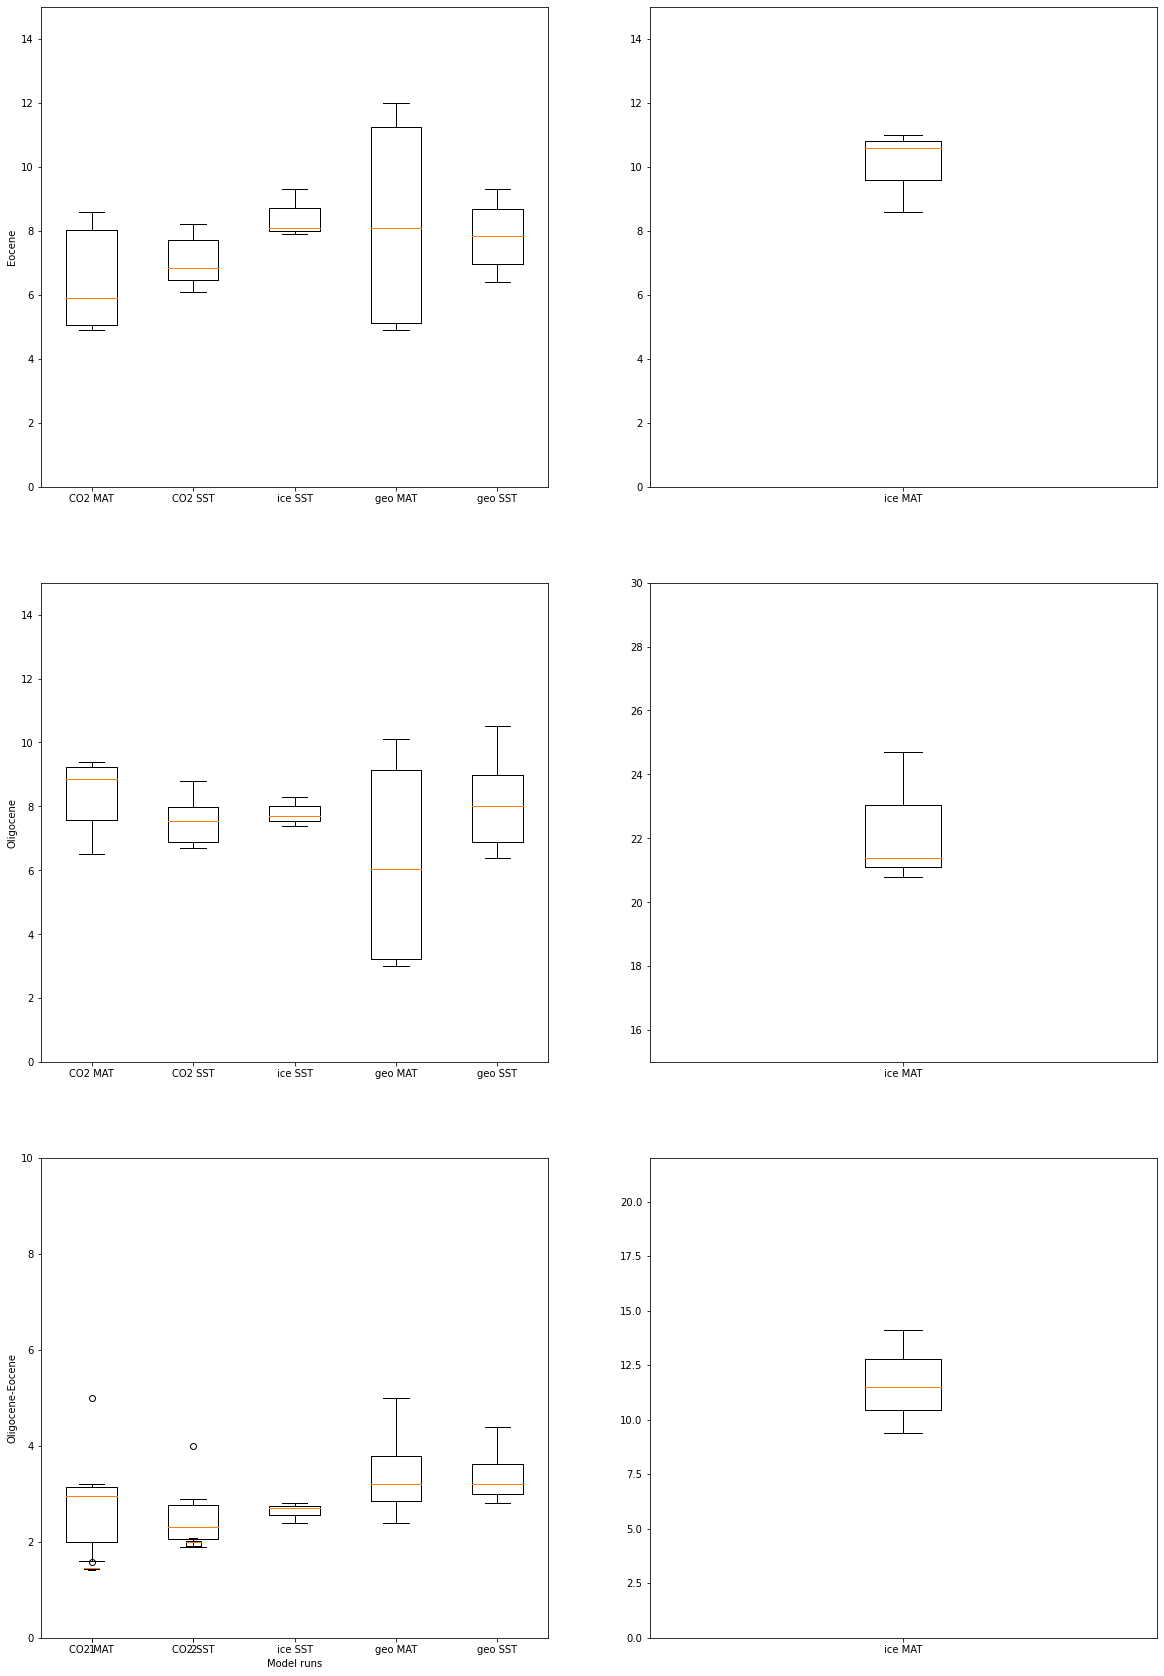

In [147]:
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(3,2,figsize=(20,30))

data_Eocene=[rms_Eocene[0:6],rms_EOSST[0:6],rms_EOSST_ice[0:3],rms_Eocene_geo[0:4],rms_EOSST_geo[0:6]]
data_Oligo=[rms_Oligo[0:6],rms_OligoSST[0:6],rms_OligoSST_ice[0:3],rms_Oligo_geo[0:4],rms_OligoSST_geo[0:6]]
data_diff=[rms_diffSAT[0:6],rms_diffSST[0:6],rms_diffSST_ice[0:3],rms_diffgeo[0:4],rms_diffSST_geo[0:6]]

axs[0,0].boxplot(data_Eocene,labels=['CO2 MAT','CO2 SST','ice SST','geo MAT','geo SST'])
axs[1,0].boxplot(data_Oligo,labels=['CO2 MAT','CO2 SST','ice SST','geo MAT','geo SST'])
axs[2,0].boxplot(data_diff,labels=['CO2 MAT','CO2 SST','ice SST','geo MAT','geo SST'])
axs[2,0].boxplot(error)

axs[0,1].boxplot(rms_Eoceneice[0:3],labels=['ice MAT'])
axs[1,1].boxplot(rms_Oligoice[0:3],labels=['ice MAT'])
axs[2,1].boxplot(rms_diffice[0:3],labels=['ice MAT'])

axs[0,0].set_ylabel('Eocene')
axs[1,0].set_ylabel('Oligocene')
axs[2,0].set_ylabel('Oligocene-Eocene')
axs[2,0].set_xlabel('Model runs')

axs[0,0].set_ylim(0,15)
axs[1,0].set_ylim(0,15)
axs[2,0].set_ylim(0,10)

axs[0,1].set_ylim(0,15)
axs[1,1].set_ylim(15,30)
axs[2,1].set_ylim(0,22)

plt.show()
fig.savefig('modelRMSE_boxplot.pdf',transparent=True,dpi=300)

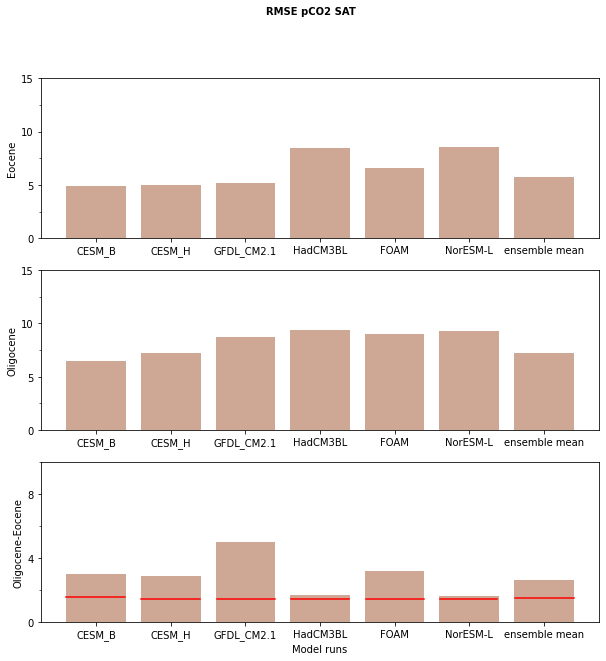

In [181]:
#plot model RMSE for each timeslice and improvement after CO2 scaling SAT
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(3,1,figsize=(10,10))

model_labels=['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESM-L','ensemble mean']

axs[0].bar(model_labels,rms_Eocene,align='center', alpha=0.5, ecolor='black', capsize=5,color='sienna')
axs[1].bar(model_labels,rms_Oligo,align='center', alpha=0.5, ecolor='black', capsize=5,color='sienna')
axs[2].bar(model_labels,rms_diffSAT,align='center', alpha=0.5, ecolor='black', capsize=5,color='sienna')



axs[0].set_ylabel('Eocene')
axs[1].set_ylabel('Oligocene')
axs[2].set_ylabel('Oligocene-Eocene')
axs[2].set_xlabel('Model runs')


axs[0].set_ylim(0,15)
axs[1].set_ylim(0,15)
axs[2].set_ylim(0,10)
axs[0].set_yticks([0,5,10,15])
axs[1].set_yticks([0,5,10,15])
axs[2].set_yticks([0,4,8])

axs[0].yaxis.set_minor_locator(MultipleLocator(2.5))
axs[1].yaxis.set_minor_locator(MultipleLocator(2.5))
axs[2].yaxis.set_minor_locator(MultipleLocator(2))

axs[2].axhline(y = inval_1d[0], xmin=0.045,xmax=0.15,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d[1], xmin=0.18,xmax=0.285,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d[2], xmin=0.315,xmax=0.42,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d[3], xmin=0.448,xmax=0.552,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d[4], xmin=0.583,xmax=0.686,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d[5], xmin=0.715,xmax=0.818,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d[6], xmin=0.85,xmax=0.955,color = 'r', linestyle = '-')

fig.suptitle('RMSE pCO2 SAT',fontweight='bold', fontsize=10)
plt.show()

fig.savefig('modelRMSE_CO2SAT_barplot.pdf',transparent=True,dpi=300)

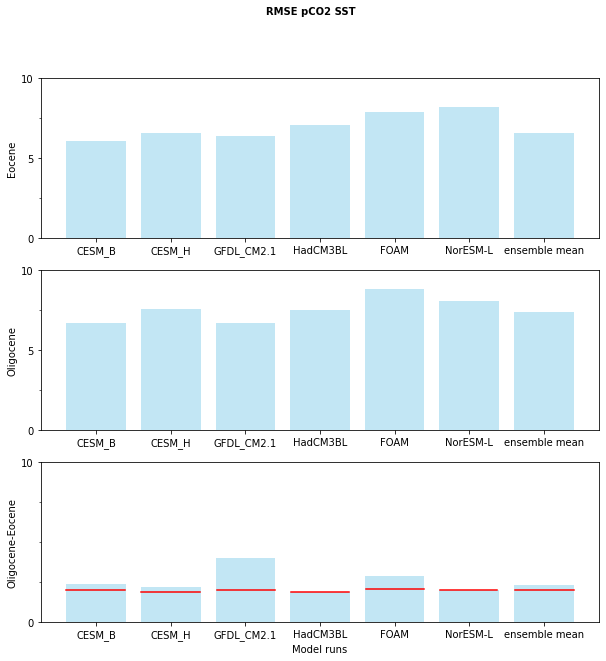

In [183]:
#plot model RMSE for each timeslice and improvement after CO2 scaling SST
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(3,1,figsize=(10,10))

model_labels=['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESM-L','ensemble mean']

axs[0].bar(model_labels,rms_EOSST,align='center', alpha=0.5, ecolor='black', capsize=5,color='skyblue')
axs[1].bar(model_labels,rms_OligoSST,align='center', alpha=0.5, ecolor='black', capsize=5,color='skyblue')
axs[2].bar(model_labels,rms_diffSST,align='center', alpha=0.5, ecolor='black', capsize=5,color='skyblue')



axs[0].set_ylabel('Eocene')
axs[1].set_ylabel('Oligocene')
axs[2].set_ylabel('Oligocene-Eocene')
axs[2].set_xlabel('Model runs')


axs[0].set_ylim(0,10)
axs[1].set_ylim(0,10)
axs[2].set_ylim(0,5)
axs[0].set_yticks([0,5,10])
axs[1].set_yticks([0,5,10])
axs[2].set_yticks([0,10])

axs[0].yaxis.set_minor_locator(MultipleLocator(2.5))
axs[1].yaxis.set_minor_locator(MultipleLocator(2.5))
axs[2].yaxis.set_minor_locator(MultipleLocator(2.5))

axs[2].axhline(y = inval_1d_SST[0], xmin=0.045,xmax=0.15,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d_SST[1], xmin=0.18,xmax=0.285,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d_SST[2], xmin=0.315,xmax=0.42,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d_SST[3], xmin=0.448,xmax=0.552,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d_SST[4], xmin=0.583,xmax=0.686,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d_SST[5], xmin=0.715,xmax=0.818,color = 'r', linestyle = '-')
axs[2].axhline(y = inval_1d_SST[6], xmin=0.85,xmax=0.955,color = 'r', linestyle = '-')

fig.suptitle('RMSE pCO2 SST',fontweight='bold', fontsize=10)
plt.show()
fig.savefig('modelRMSE_CO2SST_barplot.pdf',transparent=True,dpi=300)

pCO2 scaling for site 511

In [187]:
#separate out the two proxies
proxy_SST = EOT_proxy_SST[EOT_proxy_SST['EOT diff'].notnull()].reset_index(drop=True)

proxy_SSTwo511alk=proxy_SST.drop([8]).reset_index(drop=True)
proxy_SSTwobayspar=proxy_SST.drop([4]).reset_index(drop=True)

Run the scaling without the Uk37prime data

In [193]:
diffmodel_SST=np.empty((8,7))
for i in range(0,len(proxy_SSTwo511alk)):
    for j in range(0,len(diff_modelconc_SST)):
        diffmodel_SST[i,j]=(diff_modelconc_SST[j].sel(latitude=proxy_SSTwo511alk['New paleolat'][i],longitude=proxy_SSTwo511alk['New paleolon'][i],method='nearest'))

In [194]:
array_SST=np.empty((101,8,7))
vect_SST=xr.DataArray(array_SST,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,len(diffmodel_SST)):
        vect_SST[j,i,:]=testarray[j]*diffmodel_SST[i,:]

In [195]:
errs_1d_SST=np.empty((101,7))
for i in range(0,len(vect_SST.nxx)):
    for j in range(0,len(vect_SST.nmodels)):
        errs_1d_SST[i,j]=SKILL(vect_SST[i,:,j],proxy_SSTwo511alk['EOT diff'],8)


inval_1d_SST=np.min(errs_1d_SST,axis=0)
ind_1d_SST=np.argmin(errs_1d_SST,axis=0)

In [196]:
print(inval_1d_SST)

[0.77925991 0.66864587 0.75835727 0.7345271  0.71906922 0.80781712
 0.70667754]


In [197]:
CO2drop_SST=560*2**testarray[ind_1d_SST]
percentdecrease_SST=(CO2drop_SST-560)/CO2drop_SST*100
print(percentdecrease_SST)

[23.15624094 25.25753757 15.32546876 37.58347255 19.89301224 39.29025578
 24.21417167]


In [146]:
Co2change_SST=CO2drop_SST-560
print(Co2change_SST)

[168.75143905 189.23943068 101.3558904  337.1982629  139.06510738
 277.11557924 178.92443003]


In [198]:
modelscalewo511alk_SST=diff_modelconc_SST.copy(deep=True)
for i in range (0,len(ind_1d)):
        modelscalewo511alk_SST[i,:,:]=testarray[ind_1d_SST[i]]*diff_modelconc_SST[i,:,:]
ensemblemean_wo511alk=modelscalewo511alk_SST[6,:,:]

In [199]:
#offsetting points to plot data from same cores
proxy_SSTwo511alk['New paleolon'][3]=352
proxy_SSTwo511alk['New paleolon'][4]=317
proxy_SSTwo511alk['New paleolon'][5]=185


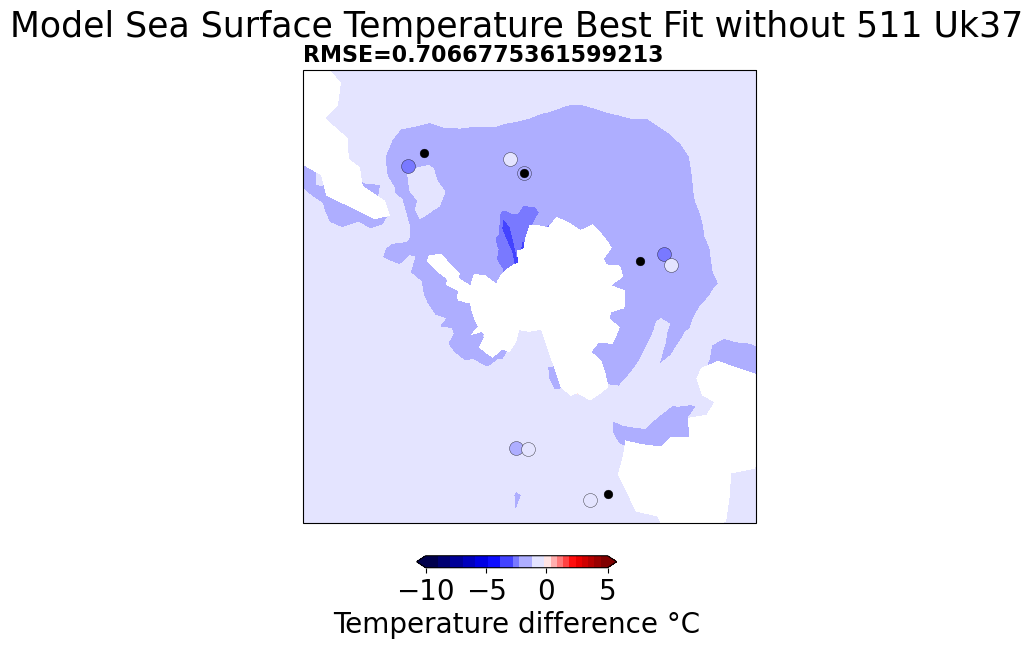

In [200]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(10,6),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

var = ensemblemean_wo511alk[lats,lons]
    
# Set the axes using the specified map projection
ax = fig.add_subplot(1, 1, 1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
data,lon= add_cyclic_point(var,coord=ensemblemean_wo511alk.longitude)

# Make a filled contour plot
    
cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.set_title('RMSE='+str(inval_1d_SST[6]),fontweight='bold', fontsize=16,loc='left')
for i in range(0,len(proxy_SSTwo511alk)):
#Add in proxy datapoints and new point locations
    cd=ax.scatter(proxy_SSTwo511alk['Paleolongitude'][i],proxy_SSTwo511alk['Paleolatitude'][i],c='black',s=40,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
    cf=ax.scatter(proxy_SSTwo511alk['New paleolon'][i],proxy_SSTwo511alk['New paleolat'][i],c=proxy_SST['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature Best Fit without 511 Uk37',fontsize=25)
plt.savefig('SST_CO2bestfitwoalk_proxymodel.pdf')

Run the pCO2 scaling wihtout the TEX86 data

In [201]:
diffmodel_SST=np.empty((8,7))
for i in range(0,len(proxy_SSTwobayspar)):
    for j in range(0,len(diff_modelconc_SST)):
        diffmodel_SST[i,j]=(diff_modelconc_SST[j].sel(latitude=proxy_SSTwobayspar['New paleolat'][i],longitude=proxy_SSTwobayspar['New paleolon'][i],method='nearest'))

In [202]:
array_SST=np.empty((101,8,7))
vect_SST=xr.DataArray(array_SST,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,len(diffmodel_SST)):
        vect_SST[j,i,:]=testarray[j]*diffmodel_SST[i,:]

In [203]:
errs_1d_SST=np.empty((101,7))
for i in range(0,len(vect_SST.nxx)):
    for j in range(0,len(vect_SST.nmodels)):
        errs_1d_SST[i,j]=SKILL(vect_SST[i,:,j],proxy_SSTwobayspar['EOT diff'],8)

inval_1d_SST=np.min(errs_1d_SST,axis=0)
ind_1d_SST=np.argmin(errs_1d_SST,axis=0)

In [204]:
print(inval_1d_SST)

[2.11614903 1.99942683 2.11512407 2.00079664 2.15587431 2.09840691
 2.06842936]


In [205]:
CO2drop_SST=560*2**testarray[ind_1d_SST]
percentdecrease_SST=(CO2drop_SST-560)/CO2drop_SST*100
Co2change_SST=CO2drop_SST-560
CO2drop_SST,percentdecrease_SST,Co2change_SST

(array([ 814.2246097 ,  860.65010152,  708.82369262, 1135.63461736,
         759.69842337, 1167.56165214,  837.11557924]),
 array([31.22290909, 34.93290723, 20.99586881, 50.68836478, 26.28653914,
        52.03679403, 33.10362226]),
 array([254.2246097 , 300.65010152, 148.82369262, 575.63461736,
        199.69842337, 607.56165214, 277.11557924]))

Inclusion of paleogeo models 

UViC due to direct changes in paleogeo in Antarctica

In [221]:
proxy_SST = EOT_proxy_SST[EOT_proxy_SST['EOT diff'].notnull()].reset_index(drop=True)

proxy_SSTwo511alk=proxy_SST.drop([8]).reset_index(drop=True)
proxy_SSTwobayspar=proxy_SST.drop([4]).reset_index(drop=True)

In [222]:
ensemblemean_SST=diff_modelconc_SST[6]

In [223]:
# combine ensemble mean and geo diff from UVIC
UVICdiff=diff_modelgeo_SST[4]
ensembleco2_uvic=ensemblemean_SST+UVICdiff

In [224]:
diff_mean_SST=np.empty((8))
for i in range(0,len(proxy_SSTwo511alk)):
    diff_mean_SST[i]=(ensembleco2_uvic.sel(latitude=proxy_SSTwo511alk['New paleolat'][i],longitude=proxy_SSTwo511alk['New paleolon'][i],method='nearest'))

In [225]:
array_SST=np.empty((101,8))
vect_SST=xr.DataArray(array_SST,dims=['nxx','nproxies'])
for j in range (0,len(testarray)):
    for i in range (0,len(diff_mean_SST)):
        vect_SST[j,i]=testarray[j]*diff_mean_SST[i]

In [226]:
errs_1d_SST=np.empty((101))
for i in range(0,len(vect_SST.nxx)):
    errs_1d_SST[i]=SKILL(vect_SST[i,:],proxy_SSTwo511alk['EOT diff'],8)

inval_1d_SST=np.min(errs_1d_SST,axis=0)
ind_1d_SST=np.argmin(errs_1d_SST,axis=0)

In [227]:
inval_1d_SST

0.9021431215081926

In [228]:
CO2drop_SST=560*2**testarray[ind_1d_SST]
percentdecrease_SST=(CO2drop_SST-560)/CO2drop_SST*100

In [229]:
percentdecrease_SST,CO2drop_SST

(17.64089827324269, 679.9491352612263)

In [230]:
Co2change_SST=CO2drop_SST-560
print(Co2change_SST)

119.94913526122627


In [231]:
geoCO2_scale_SST=testarray[ind_1d_SST]*ensembleco2_uvic

In [232]:
#offsetting points to plot data from same cores
proxy_SSTwo511alk['New paleolon'][3]=352
proxy_SSTwo511alk['New paleolon'][4]=317
proxy_SSTwo511alk['New paleolon'][5]=185


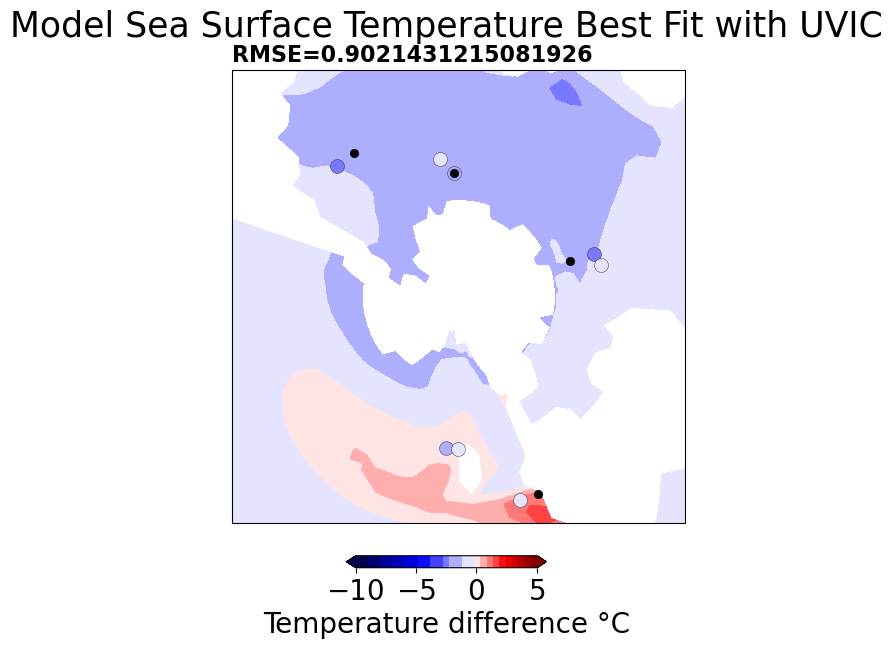

In [233]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(10,6),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)


var = geoCO2_scale_SST[lats,lons]
    
# Set the axes using the specified map projection
ax = fig.add_subplot(1, 1, 1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
data,lon= add_cyclic_point(var,coord=geoCO2_scale_SST.longitude)

# Make a filled contour plot
    
cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.set_title('RMSE='+str(inval_1d_SST),fontweight='bold', fontsize=16,loc='left')
for i in range(0,len(proxy_SSTwo511alk)):
#Add in proxy datapoints and new point locations
    cd=ax.scatter(proxy_SSTwo511alk['Paleolongitude'][i],proxy_SSTwo511alk['Paleolatitude'][i],c='black',s=40,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
    cf=ax.scatter(proxy_SSTwo511alk['New paleolon'][i],proxy_SSTwo511alk['New paleolat'][i],c=proxy_SST['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature Best Fit with UVIC',fontsize=25)
plt.savefig('SST_CO2bestfitUVic_proxymodel.pdf')

CESM_H

In [234]:
proxy_SST = EOT_proxy_SST[EOT_proxy_SST['EOT diff'].notnull()].reset_index(drop=True)

proxy_SSTwo511alk=proxy_SST.drop([8]).reset_index(drop=True)
proxy_SSTwobayspar=proxy_SST.drop([4]).reset_index(drop=True)

In [235]:
#CESM_H
CESMH_diff=diff_modelgeo_SST[0]

ensembleco2_CESMH=ensemblemean_SST+CESMH_diff

In [236]:
diff_mean_SST=np.empty((8))
for i in range(0,len(proxy_SSTwo511alk)):
    diff_mean_SST[i]=(ensembleco2_CESMH.sel(latitude=proxy_SSTwo511alk['New paleolat'][i],longitude=proxy_SSTwo511alk['New paleolon'][i],method='nearest'))

In [237]:
array_SST=np.empty((101,8))
vect_SST=xr.DataArray(array_SST,dims=['nxx','nproxies'])
for j in range (0,len(testarray)):
    for i in range (0,len(diff_mean_SST)):
        vect_SST[j,i]=testarray[j]*diff_mean_SST[i]

In [238]:
errs_1d_SST=np.empty((101))
for i in range(0,len(vect_SST.nxx)):
    errs_1d_SST[i]=SKILL(vect_SST[i,:],proxy_SSTwo511alk['EOT diff'],8)

inval_1d_SST=np.min(errs_1d_SST,axis=0)
ind_1d_SST=np.argmin(errs_1d_SST,axis=0)

In [239]:
CO2drop_SST=560*2**testarray[ind_1d_SST]
percentdecrease_SST=(CO2drop_SST-560)/CO2drop_SST*100
Co2change_SST=CO2drop_SST-560

percentdecrease_SST,CO2drop_SST,inval_1d_SST,Co2change_SST

(22.083542033950017, 718.7185026352264, 0.8866082430364716, 158.7185026352264)

In [240]:
#offsetting points to plot data from same cores
proxy_SSTwo511alk['New paleolon'][3]=352
proxy_SSTwo511alk['New paleolon'][4]=317
proxy_SSTwo511alk['New paleolon'][5]=185


In [241]:
geoCO2_scaleCESMH_SST=testarray[ind_1d_SST]*ensembleco2_CESMH

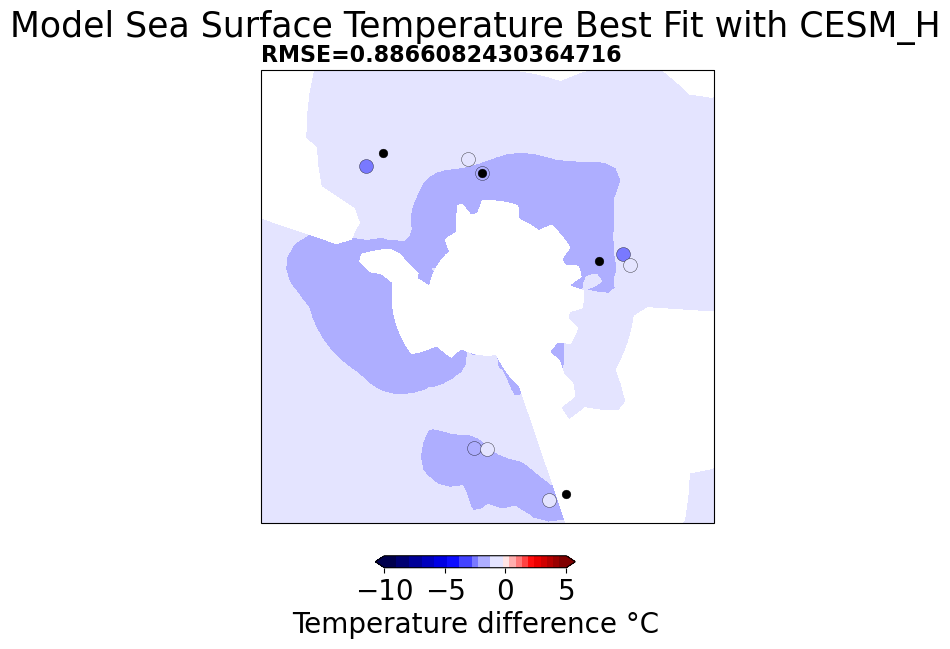

In [242]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(10,6),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)


var = geoCO2_scaleCESMH_SST[lats,lons]
    
# Set the axes using the specified map projection
ax = fig.add_subplot(1, 1, 1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
data,lon= add_cyclic_point(var,coord=geoCO2_scaleCESMH_SST.longitude)

# Make a filled contour plot
    
cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.set_title('RMSE='+str(inval_1d_SST),fontweight='bold', fontsize=16,loc='left')
for i in range(0,len(proxy_SSTwo511alk)):
#Add in proxy datapoints and new point locations
    cd=ax.scatter(proxy_SSTwo511alk['Paleolongitude'][i],proxy_SSTwo511alk['Paleolatitude'][i],c='black',s=40,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
    cf=ax.scatter(proxy_SSTwo511alk['New paleolon'][i],proxy_SSTwo511alk['New paleolat'][i],c=proxy_SSTwo511alk['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature Best Fit with CESM_H',fontsize=25)
plt.savefig('SST_CO2bestfitCESMH_proxymodel.pdf')

FOAM

In [243]:
proxy_SST = EOT_proxy_SST[EOT_proxy_SST['EOT diff'].notnull()].reset_index(drop=True)

proxy_SSTwo511alk=proxy_SST.drop([8]).reset_index(drop=True)
proxy_SSTwobayspar=proxy_SST.drop([4]).reset_index(drop=True)

In [244]:
#FOAM
FOAM_diff=diff_modelgeo_SST[3]

ensembleco2_FOAM=ensemblemean_SST+FOAM_diff

In [245]:
diff_mean_SST=np.empty((8))
for i in range(0,len(proxy_SSTwo511alk)):
    diff_mean_SST[i]=(ensembleco2_FOAM.sel(latitude=proxy_SSTwo511alk['New paleolat'][i],longitude=proxy_SSTwo511alk['New paleolon'][i],method='nearest'))

In [246]:
array_SST=np.empty((101,8))
vect_SST=xr.DataArray(array_SST,dims=['nxx','nproxies'])
for j in range (0,len(testarray)):
    for i in range (0,len(diff_mean_SST)):
        vect_SST[j,i]=testarray[j]*diff_mean_SST[i]

In [247]:
errs_1d_SST=np.empty((101))
for i in range(0,len(vect_SST.nxx)):
    errs_1d_SST[i]=SKILL(vect_SST[i,:],proxy_SSTwo511alk['EOT diff'],8)

inval_1d_SST=np.min(errs_1d_SST,axis=0)
ind_1d_SST=np.argmin(errs_1d_SST,axis=0)

In [248]:
CO2drop_SST=560*2**testarray[ind_1d_SST]
percentdecrease_SST=(CO2drop_SST-560)/CO2drop_SST*100
Co2change_SST=CO2drop_SST-560
percentdecrease_SST,CO2drop_SST,inval_1d_SST,Co2change_SST

(15.325468763747278, 661.355890400537, 0.970919286951451, 101.35589040053696)

In [249]:
#offsetting points to plot data from same cores
proxy_SSTwo511alk['New paleolon'][3]=352
proxy_SSTwo511alk['New paleolon'][4]=317
proxy_SSTwo511alk['New paleolon'][5]=185

In [250]:
geoCO2_scaleFOAM_SST=testarray[ind_1d_SST]*ensembleco2_FOAM

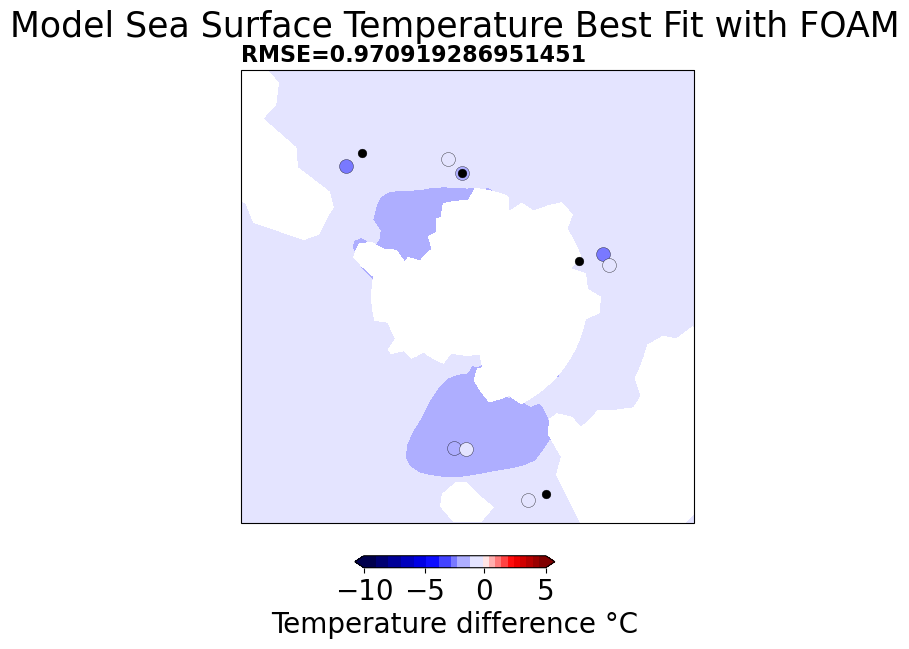

In [251]:
lats=range(0,73)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(10,6),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)


var = geoCO2_scaleFOAM_SST[lats,lons]
    
# Set the axes using the specified map projection
ax = fig.add_subplot(1, 1, 1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
data,lon= add_cyclic_point(var,coord=geoCO2_scaleFOAM_SST.longitude)

# Make a filled contour plot
    
cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
ax.set_title('RMSE='+str(inval_1d_SST),fontweight='bold', fontsize=16,loc='left')
for i in range(0,len(proxy_SSTwo511alk)):
#Add in proxy datapoints and new point locations
    cd=ax.scatter(proxy_SSTwo511alk['Paleolongitude'][i],proxy_SSTwo511alk['Paleolatitude'][i],c='black',s=40,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree())
    cf=ax.scatter(proxy_SSTwo511alk['New paleolon'][i],proxy_SSTwo511alk['New paleolat'][i],c=proxy_SST['EOT diff'][i],s=100,cmap=cmap,norm=norm,edgecolor='black',linewidth=0.25,transform=ccrs.PlateCarree()) #the artificial center of the averaging region
   

colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature Best Fit with FOAM',fontsize=25)
plt.savefig('SST_CO2bestfitFOAM_proxymodel.pdf')